In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
import scipy 
import datetime
import json

In [2]:
L = 50
u = 0.0001
k1 = 1
k2 = 0.04
eps = 0.01  
alpha = 0.0001
F0 = 1
m = 1
h = 0.1
eps2 = 0.007     

In [3]:
@njit
def acc(x,v,t):
    xIntoLeft = np.roll(x,-1)
    xIntoRight = np.roll(x,1)
    xIntoLeft[-1] = 0
    xIntoRight[0] = 0

    return (-x*(2*k1 + k2) + (xIntoRight + xIntoLeft)*k1 + k2*u*t - f(x,v,t) )/m

In [4]:
@njit
def f(x,v,t):
     xIntoLeft = np.roll(x,-1)
     xIntoRight = np.roll(x,1)
     xIntoLeft[-1] = 0
     xIntoRight[0] = 0
     return np.where(v==0,
     np.where(np.abs(-x*(2*k1 + k2) + (xIntoRight + xIntoLeft)*k1 + k2*u*t) < F0, -x*(2*k1 + k2) + (xIntoRight + xIntoLeft)*k1 + k2*u*t ,F0*(1-eps) ),
     F0*(1-eps)/(1+alpha*np.abs(v)))
     ### TODO check for v<0

In [5]:
@njit
def tenstion(x,v,t):
    return m*acc(x,v,t) + f(x,v,t)

In [6]:
@njit
def step(x,v,t):
    if np.all(v==0):
        t += (F0-np.max(tenstion(x,v,t)))/(k2*u)


        k_1 = v
        l_1 = acc(x,v,t)

        k_2 = v + l_1*h/2
        l_2 = acc(x+k_1*h/2,v + l_1*h/2,t + h/2)

        k_3 = v + l_2*h/2
        l_3 = acc(x+k_2*h/2,v + l_2*h/2,t + h/2)

        k_4 = v + l_3/2
        l_4 = acc(x+k_3*h,v + l_3*h, t + h)

        x = x +  (k_1 + 2*k_2 + 2*k_3 + k_4)*h/6
        v = v +  (l_1 + 2*l_2 + 2*l_3 + l_4)*h/6

        v = np.where(v<0, 0, v)
        

    else: 
        #print("event")
        k_1 = v
        l_1 = acc(x,v,t)

        k_2 = v + l_1*h/2
        l_2 = acc(x+k_1*h/2,v + l_1*h/2,t + h/2)

        k_3 = v + l_2*h/2
        l_3 = acc(x+k_2*h/2,v + l_2*h/2,t + h/2)

        k_4 = v + l_3/2
        l_4 = acc(x+k_3*h,v + l_3*h, t + h)

        x = x +  (k_1 + 2*k_2 + 2*k_3 + k_4)*h/6
        v = v +  (l_1 + 2*l_2 + 2*l_3 + l_4)*h/6

        v = np.where(v<0, 0, v)

    return x, v,t+h

In [7]:
@njit(cache=True)
def np_any_axis1(x):
    """Numba compatible version of np.any(x, axis=1)."""
    out = np.zeros(x.shape[0], dtype=np.bool8)
    for i in range(x.shape[1]):
        out = np.logical_or(out, x[:, i])
    return out

In [8]:
dataDic1 = {}
dataDic2 = {}
dataDic3 = {}

for i in range(0,L+1):
    dataDic1[i] = []
    dataDic2[i] = []
    dataDic3[i] = []

In [17]:
@njit
def run(x,v,t,steps=1_000_000):
    xdata = np.zeros((steps,L),dtype=np.float64)
    vdata = np.zeros((steps,L),dtype=np.float64)
    tenstionData = np.zeros((steps,L),dtype=np.float64)
    for i in range(steps):
        x,v,t = step(x,v,t)
        xdata[i] = x
        vdata[i] = v
        tenstionData[i] = tenstion(x,v,t)

    # slipping = np.any(vdata>0,axis=1)
    slipping = np_any_axis1(vdata>0)

    slippingR = np.roll(slipping,+1)
    slippingL = np.roll(slipping,-1)

    slippingR[0] = False
    slippingL[-1] = False 

    ends  = np.logical_xor( slipping ,(slipping *slippingL))
    starts  = np.logical_xor( slipping ,(slipping *slippingR))

    totalX = np.sum(xdata,axis = 1)

    eventsSize = totalX[np.argwhere(ends)[:,0]] - totalX[np.argwhere(starts)[:,0]]
    eventsBlocks = np.sum(xdata[ends]!=xdata[starts],axis=1).reshape(-1,1)

    # eventsBlocks2 = np.sum(np.sum(arr > np.roll(arr,1) ))


    arr1 = vdata>0
    arr2 = arr1 > np.roll(arr1,1)
    arr3 = np.sum(arr2,axis=1)
    arr4 = sum2(arr3)

    arr5 = arr4[np.argwhere(starts)[:,0]]
    arr6 = arr4[np.argwhere(ends)[:,0]]

    eventsBlocks2 = arr6-arr5



    #print(np.argwhere(ends)-np.argwhere(starts))

    # time = str(datetime.datetime.now())
    # np.save("xdata-"+time,xdata)
    # np.save("vdata-"+time,vdata)

    ls = np.sum(tenstionData[np.argwhere(starts)[:,0]] >= (1-eps2),axis=1)


    return x,v,t,eventsSize,eventsBlocks,eventsBlocks2,ls


In [18]:
run(x,v,t,1_000_000)

/tmp/ipykernel_19095/398607127.py:7: NumbaExperimentalFeatureWarning: Use of isinstance() detected. This is an experimental feature.
  x,v,t = step(x,v,t)


(array([ 64.26840698, 116.89474907, 159.98988668, 195.27853012,
        224.1799067 , 247.84791648, 267.22767729, 283.09509288,
        296.08698855, 306.72386616, 315.43044015, 322.55315788,
        328.37650623, 333.13315545, 337.0130233 , 340.17164791,
        342.73411517, 344.80274794, 346.46109153, 347.77616871,
        348.80047419, 349.57432058, 350.12874863, 350.48555251,
        350.65952285, 350.65749336, 350.479305  , 350.11780718,
        349.55939241, 348.78160649, 347.7528987 , 346.43266571,
        344.76882933, 342.69462058, 340.12601639, 336.96176329,
        333.07809275, 328.31925869, 322.49841797, 315.38536278,
        306.69220237, 296.07034901, 283.0929606 , 267.23889653,
        247.87080069, 224.20999053, 195.30760573, 160.00916073,
        116.90445695,  64.26952894]),
 array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.

In [11]:
x = 0.1*np.random.uniform(-1,1,L).astype(dtype=np.float64) 
v = np.zeros(L,dtype=np.float64)
t = 0

In [20]:
# with open('dataDics4.json') as json_data:
#     dataDic = json.loads(json_data)
#     json_data.close()

In [14]:
@njit 
def sum2(a):
    sh = a.shape[0]
    b =  np.zeros(sh)
    b[0] = a[0]
    for i in range(1,sh):
        b[i] = b[i-1] + a[i]

    return b

In [26]:
x,v,t,eventsSize,eventsBlocks,eventsBlocks2,ls = run(x,v,t,1_000_000)

In [106]:
x,v,t,eventsSize,eventsBlocks,ls

(array([ 66.97265821, 121.82271965, 166.73341559, 203.49717516,
        233.59267437, 258.23375081, 278.4104709 , 294.93049344,
        308.45451375, 319.52451846, 328.58339855, 335.99293824,
        342.05003006, 346.99818853, 351.03397484, 354.31893407,
        356.98419962, 359.13628919, 360.86109735, 362.22797297,
        363.29179186, 364.09533096, 364.6711858 , 365.04238287,
        365.22390803, 365.22273217, 365.0386356 , 364.66470696,
        364.08631359, 363.28004011, 362.21384055, 360.84527907,
        359.11883062, 356.96540508, 354.29906234, 351.01258285,
        346.97473079, 342.02440856, 335.96292823, 328.54777329,
        319.48293279, 308.40474561, 294.87155287, 278.34159442,
        258.15341395, 233.49908788, 203.3885831 , 166.6313309 ,
        121.74431459,  66.93102545]),
 array([0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.   

In [ ]:
for j in range(400):
    x,v,t,eventsSize,eventsBlocks,eventsBlocks2,ls= run(x,v,t,5_000_000)

    time = str(datetime.datetime.now())
    
    np.save("eventsSize-"+time,eventsSize)
    np.save("eventsBlocks-"+time,eventsBlocks)
    np.save("eventsBlocks2-"+time,eventsBlocks2)
    np.save("ls-"+time,ls)

    for i in range(eventsSize.shape[0]):
        dataDic1[int(ls[i])].append(float(eventsSize[i]))
        dataDic2[int(ls[i])].append(float(eventsBlocks[i]))
        dataDic3[int(ls[i])].append(float(eventsBlocks2[i]))

    print(j)

In [40]:
num = 0
for i in list(dataDic1.values()):
    num += len(i)

print(num)

2003017


In [37]:
dataDic

{0: [],
 1: [],
 2: [],
 3: [],
 4: [],
 5: [],
 6: [],
 7: [],
 8: [],
 9: [],
 10: [],
 11: [],
 12: [],
 13: [],
 14: [],
 15: [],
 16: [],
 17: [],
 18: [],
 19: [],
 20: [],
 21: [],
 22: [],
 23: [],
 24: [],
 25: [],
 26: [],
 27: [],
 28: [],
 29: [],
 30: [],
 31: [],
 32: [],
 33: [],
 34: [],
 35: [],
 36: [],
 37: [],
 38: [],
 39: [],
 40: [],
 41: [],
 42: [],
 43: [],
 44: [],
 45: [],
 46: [],
 47: [],
 48: [],
 49: [],
 50: []}

In [41]:

with open("dataDics5_1.json", "w") as outfile: 
    json.dump(dataDic1, outfile)

with open("dataDics5_2.json", "w") as outfile: 
    json.dump(dataDic2, outfile)

In [42]:
means1 = np.zeros(L+1)
vars1 = np.zeros(L+1)

means2 = np.zeros(L+1)
vars2 = np.zeros(L+1)

for i in range(L+1):
    means1[i] = np.mean(dataDic1[i])
    vars1[i]=  np.var(dataDic1[i])

    means2[i] = np.mean(dataDic2[i])
    vars2[i]=  np.var(dataDic2[i])
    


/tmp/ipykernel_3323/1465354733.py:1: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(np.arange(L+1)),np.log(means1))
/tmp/ipykernel_3323/1465354733.py:2: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(np.arange(L+1)),np.log(means2))


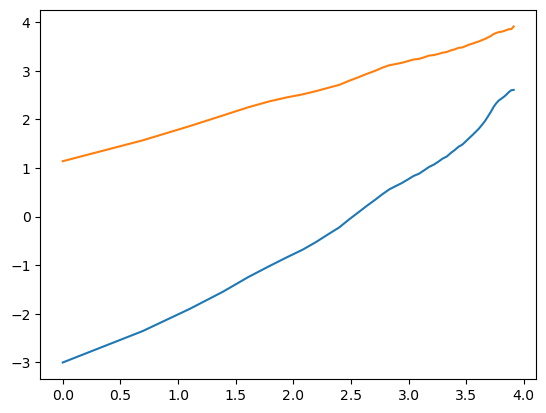

In [57]:
plt.plot(np.log(np.arange(L+1)),np.log(means1))
plt.plot(np.log(np.arange(L+1)),np.log(means2))

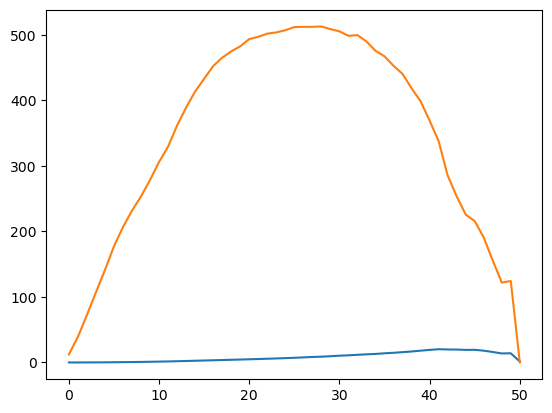

In [47]:
plt.plot(np.arange(L+1),vars1)
plt.plot(np.arange(L+1),vars2)

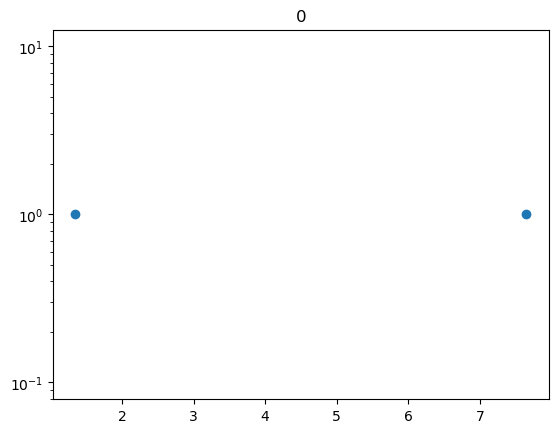

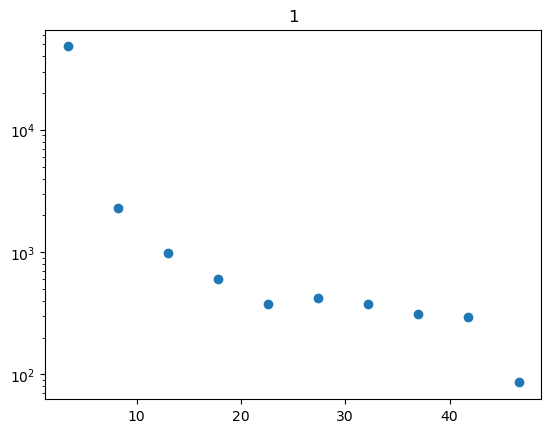

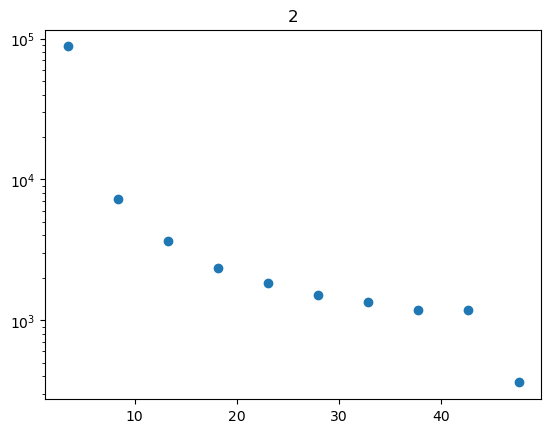

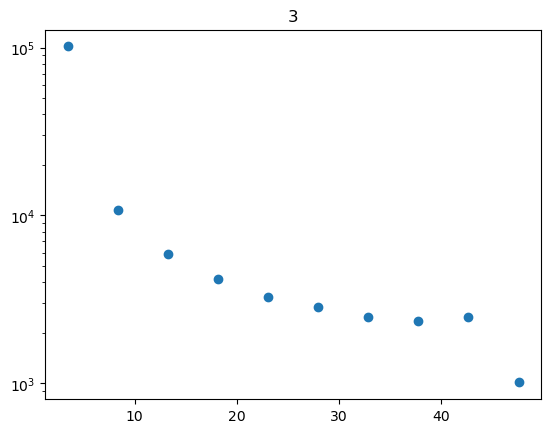

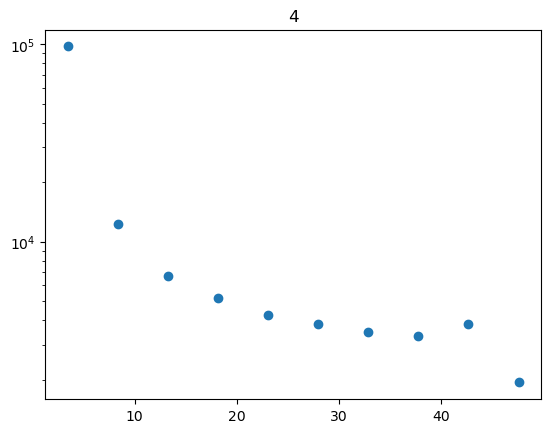

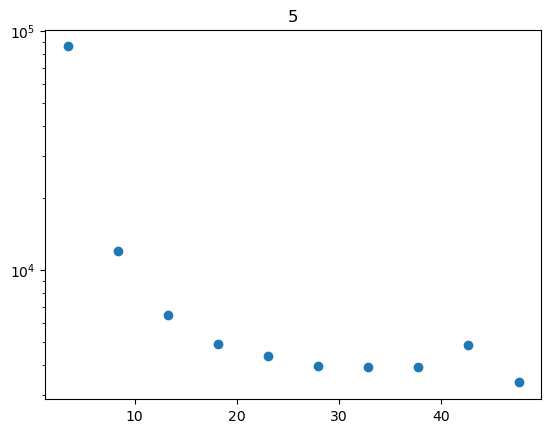

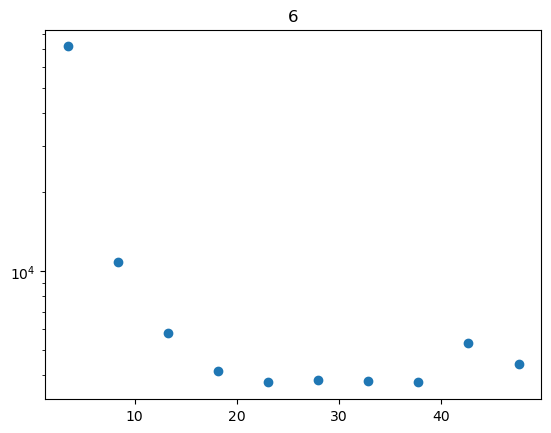

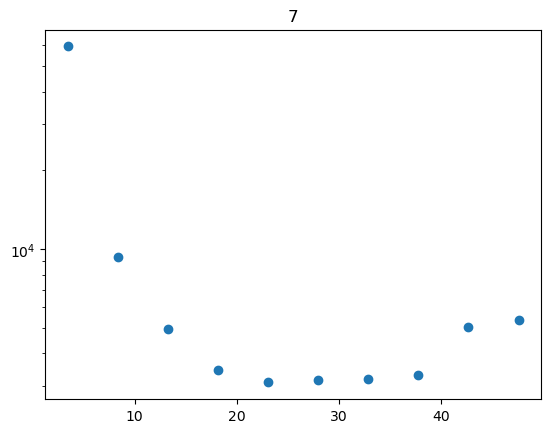

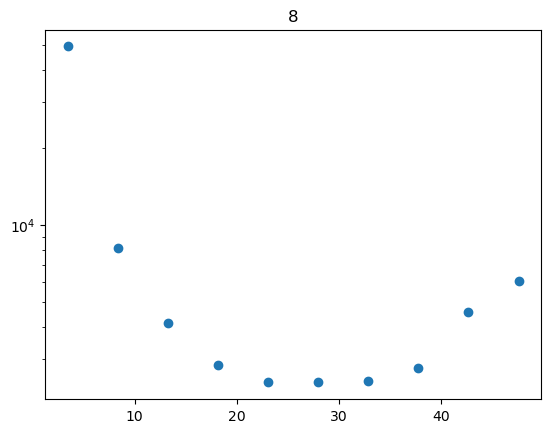

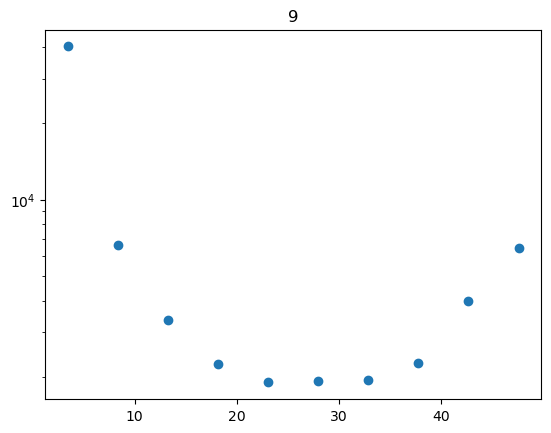

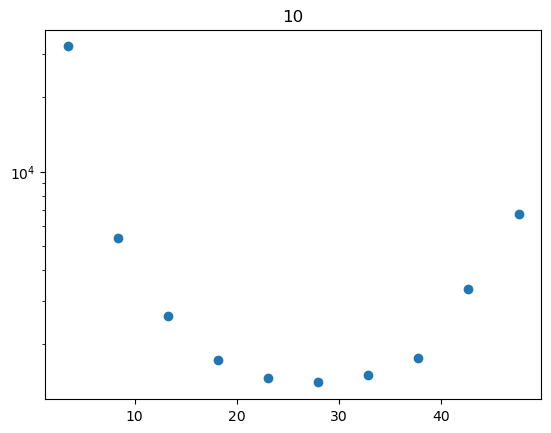

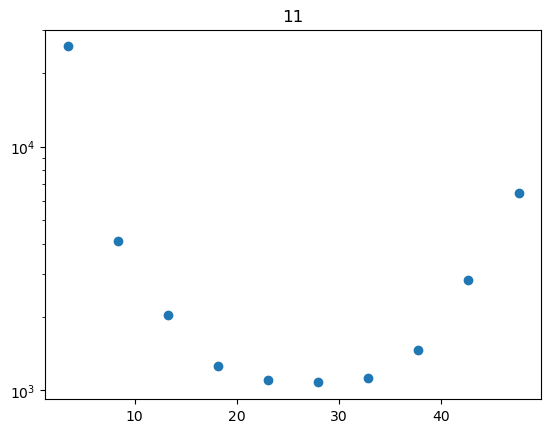

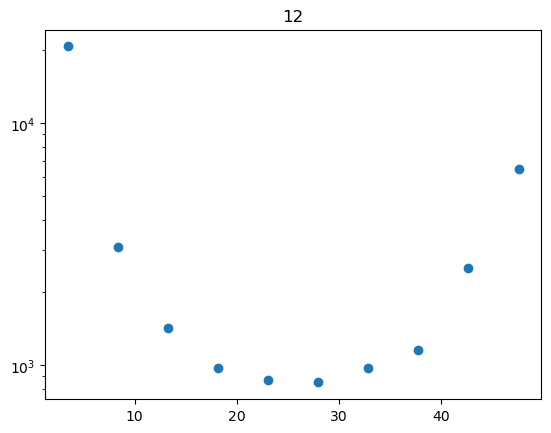

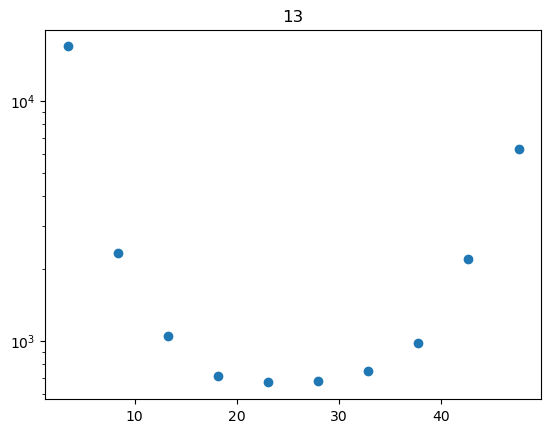

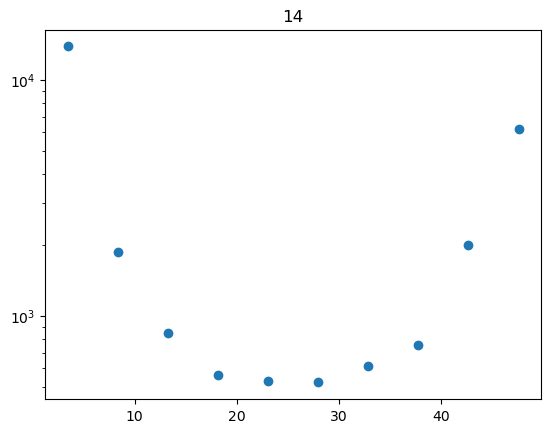

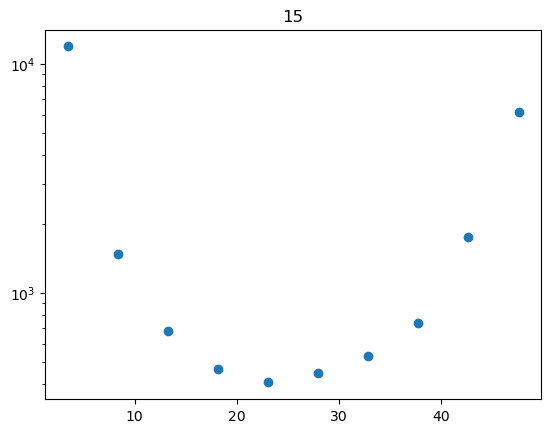

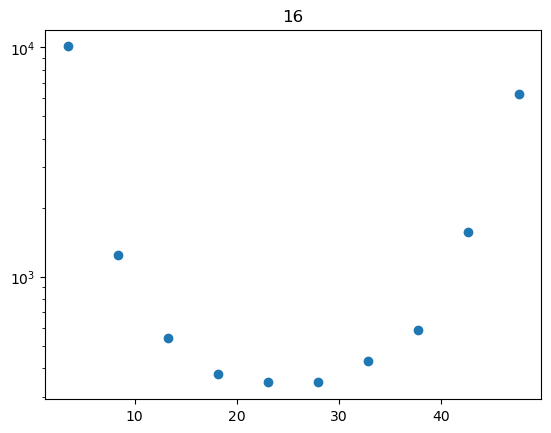

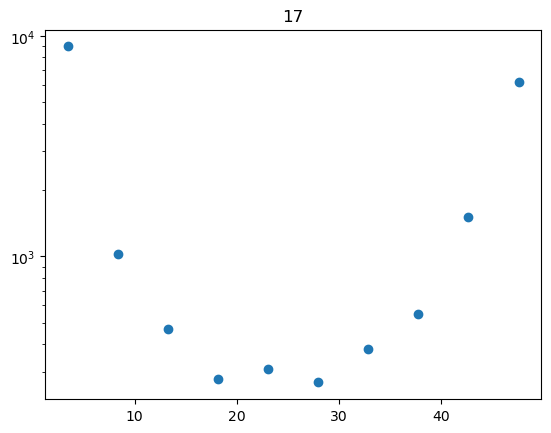

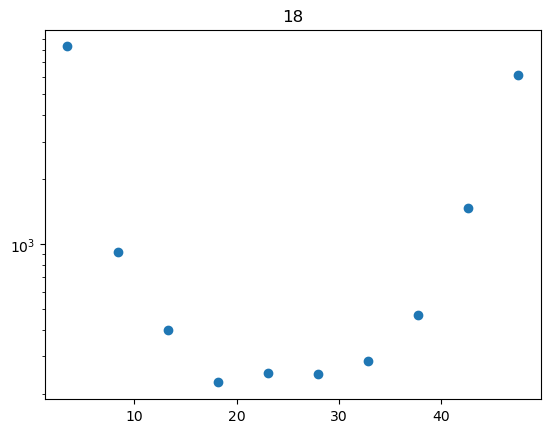

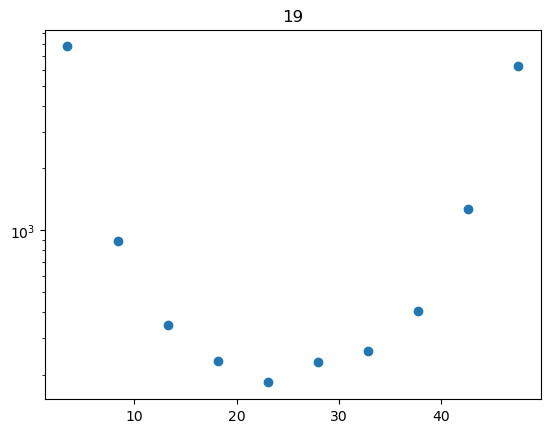

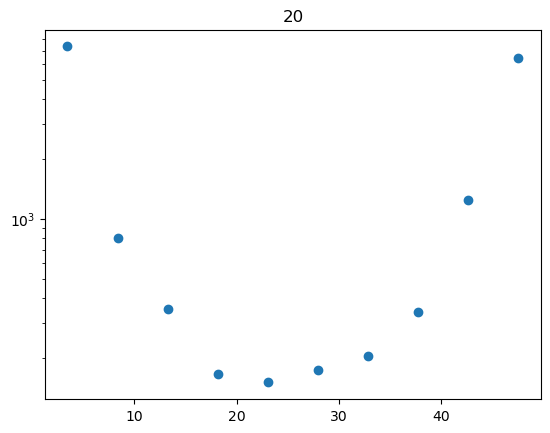

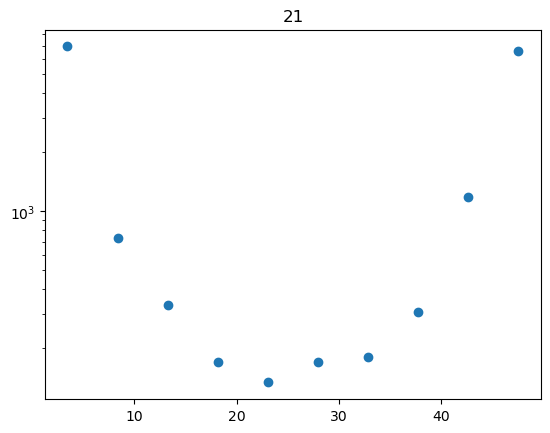

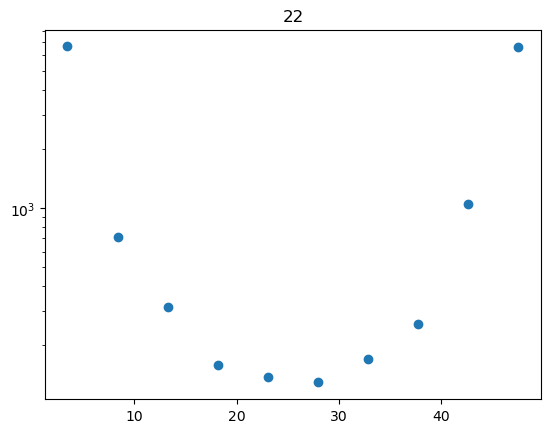

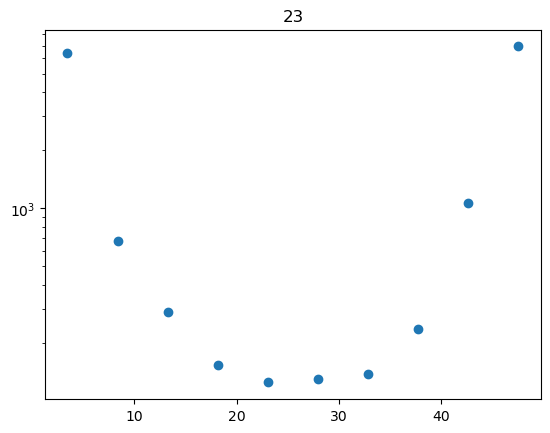

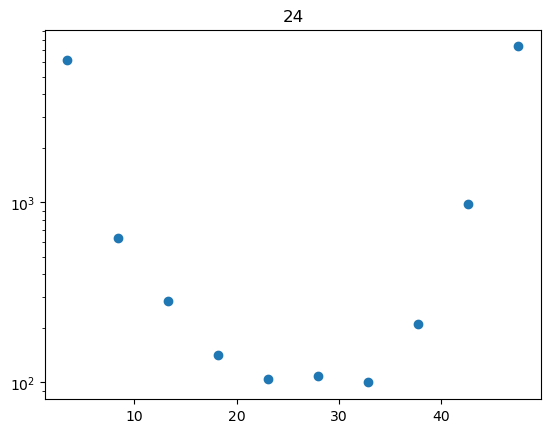

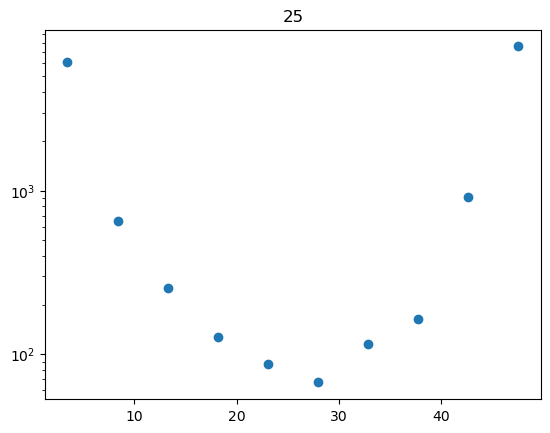

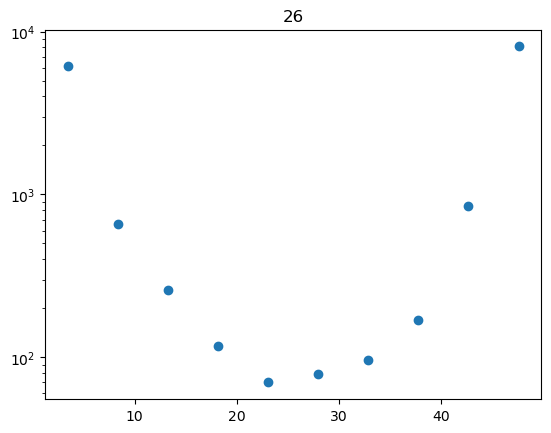

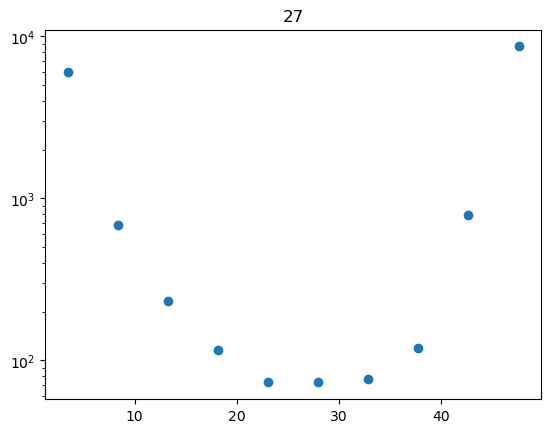

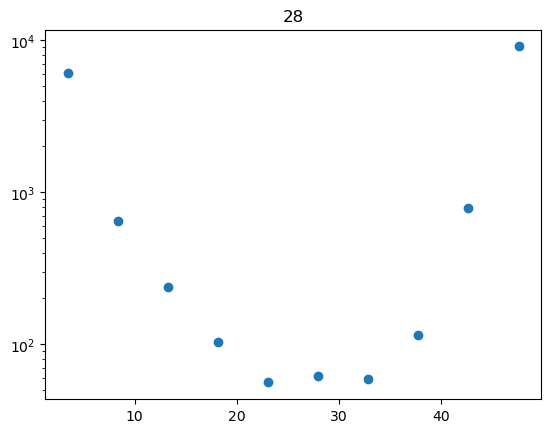

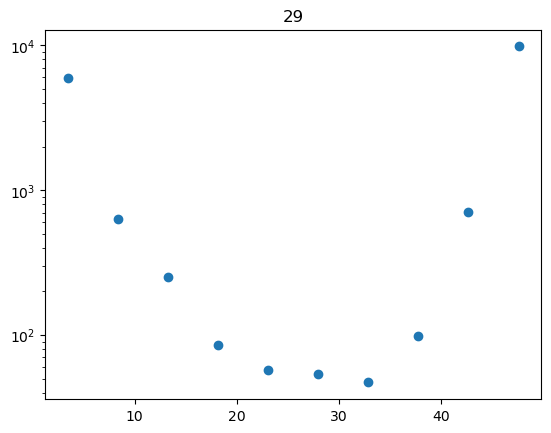

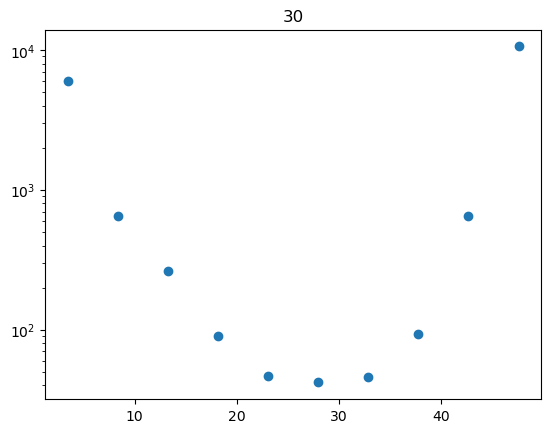

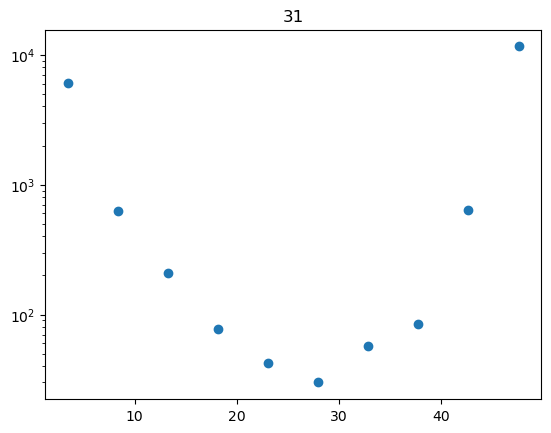

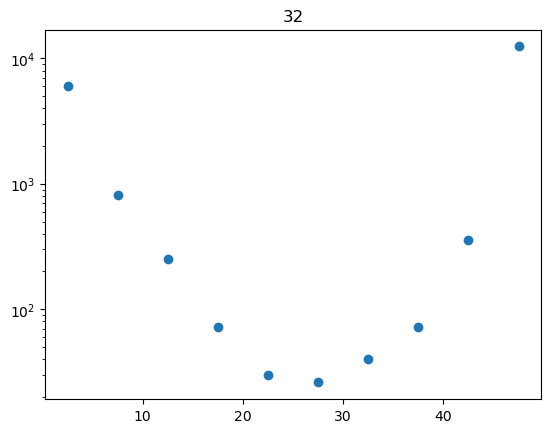

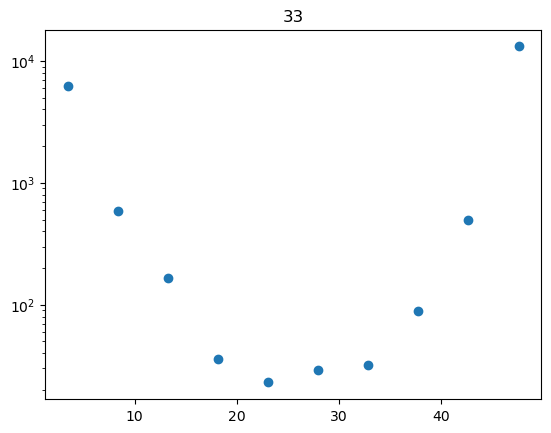

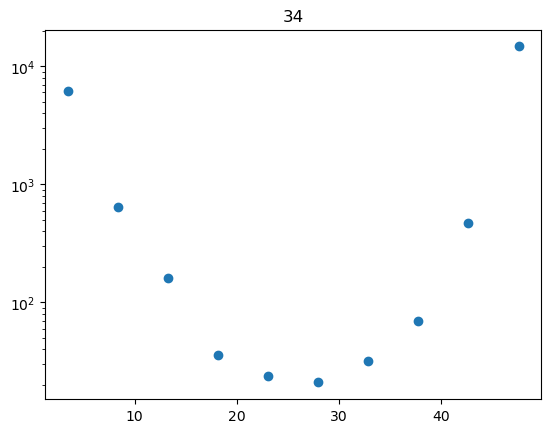

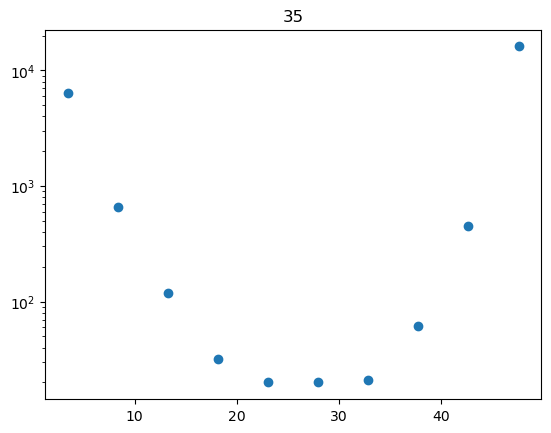

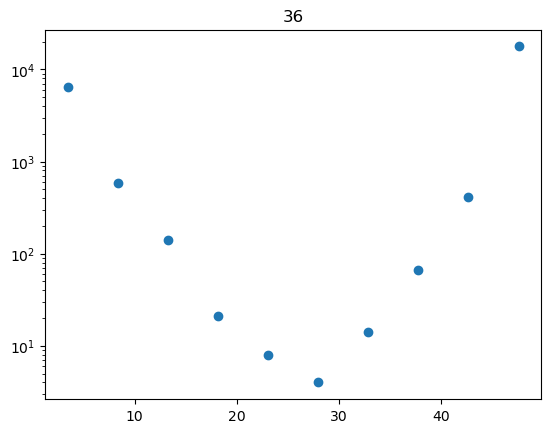

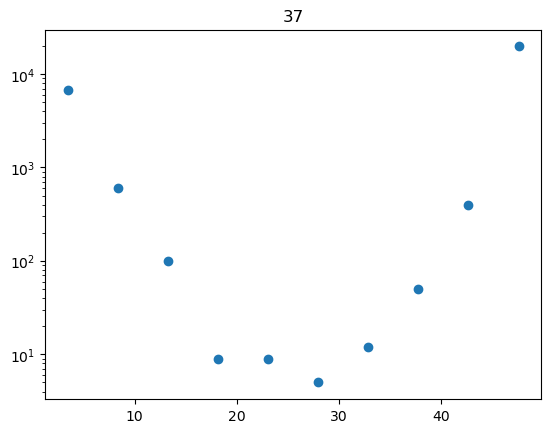

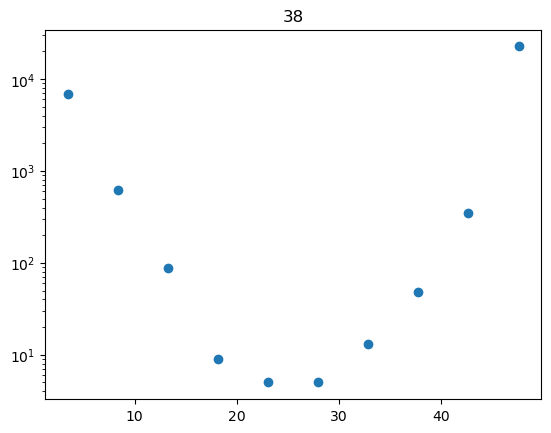

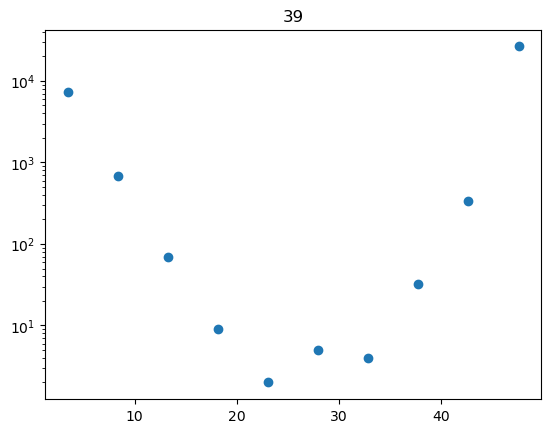

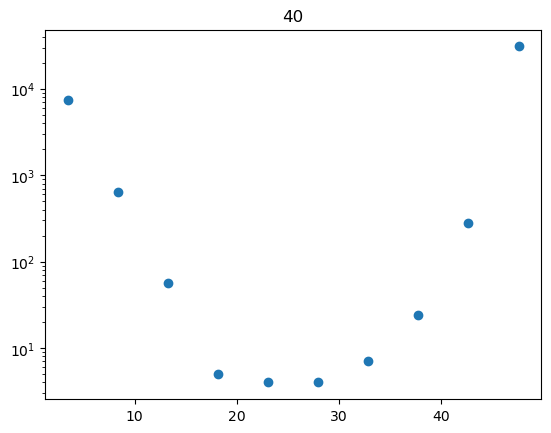

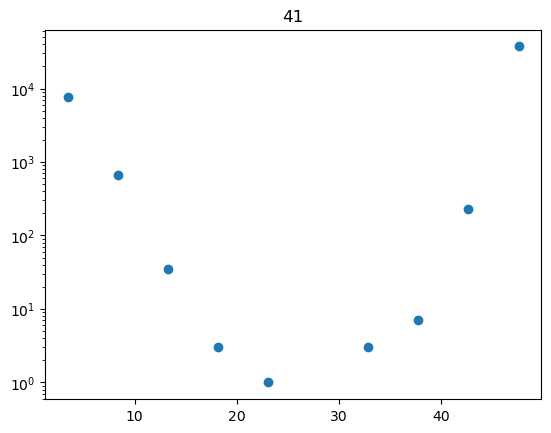

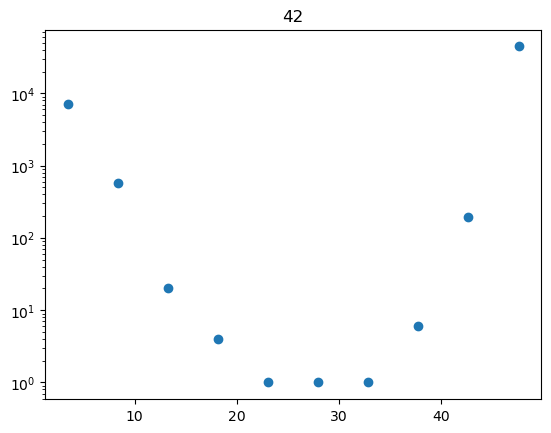

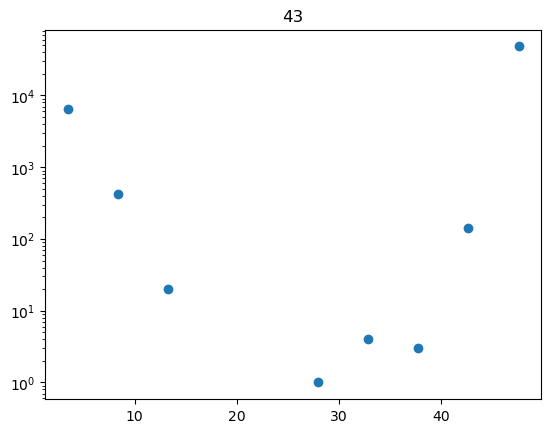

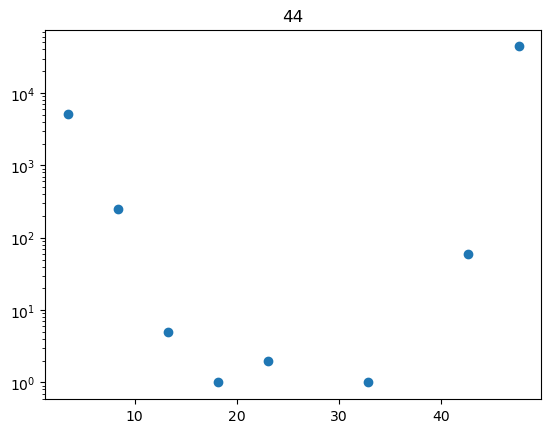

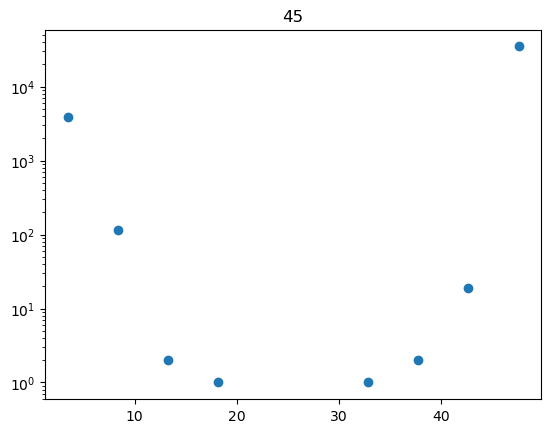

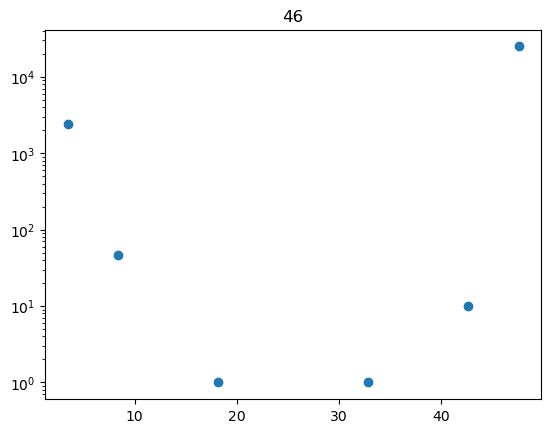

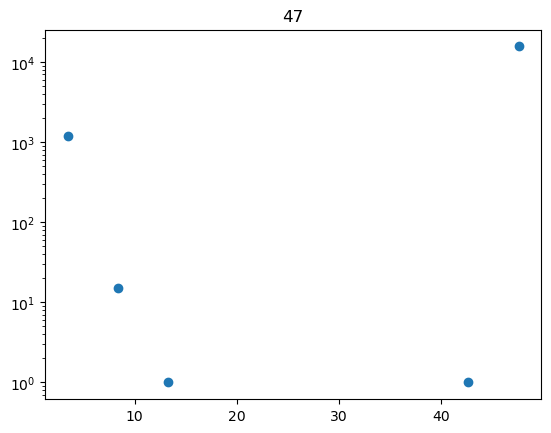

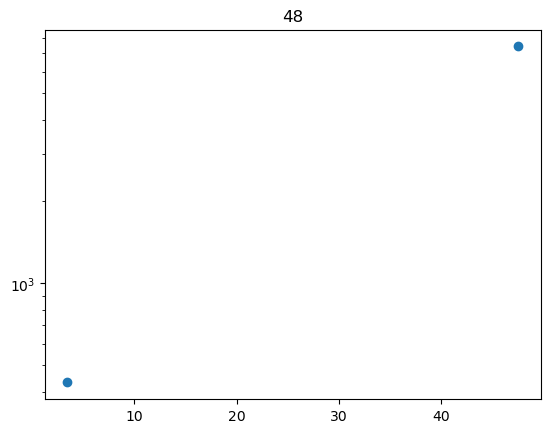

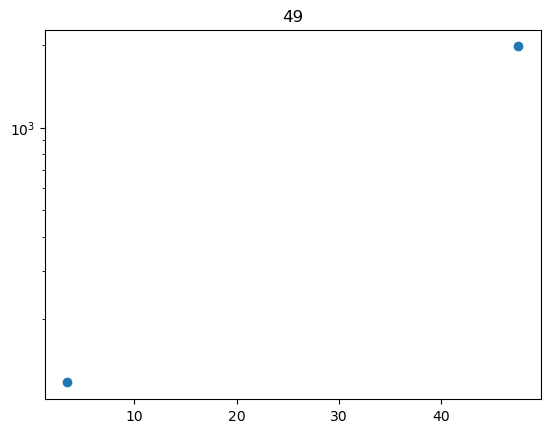

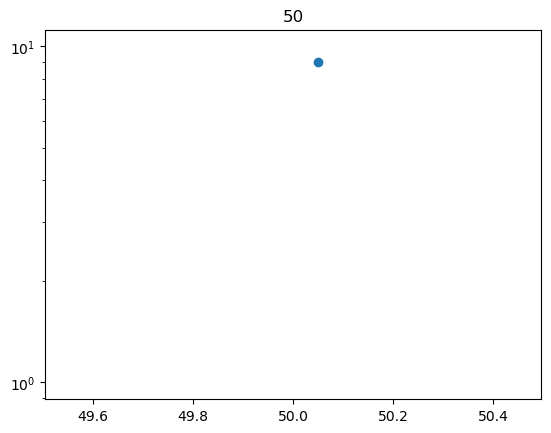

In [84]:
for i in range(L+1):
    plt.title(i)
    fig = plt.Figure()
    ax = plt.gca()

    x,y = np.histogram(dataDic2[i])
    y = ((np.roll(y,-1) + y)/2)[:-1]
    ax.scatter(y,x)
    ax.set_yscale("log")
    plt.show()


    

In [70]:
(np.roll(y,-1) + y)/2

array([1.35, 2.05, 2.75, 3.45, 4.15, 4.85, 5.55, 6.25, 6.95, 7.65, 4.5 ])

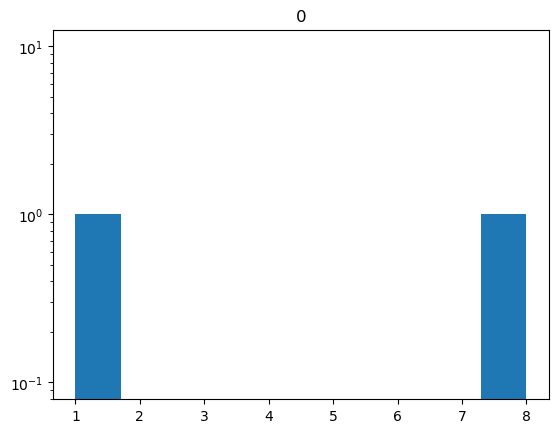

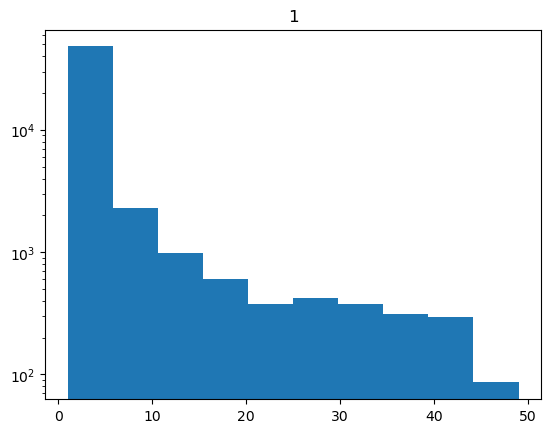

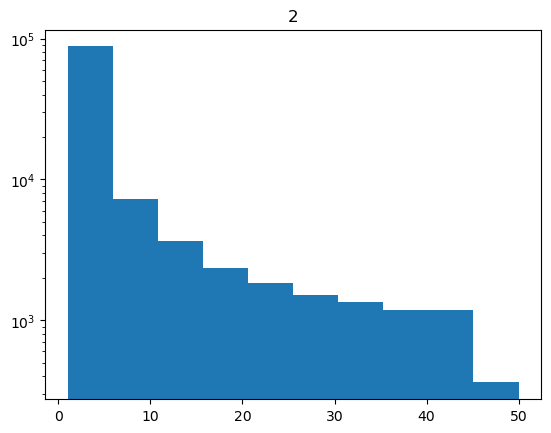

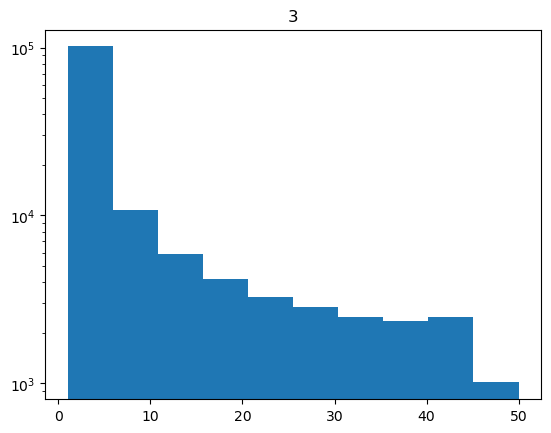

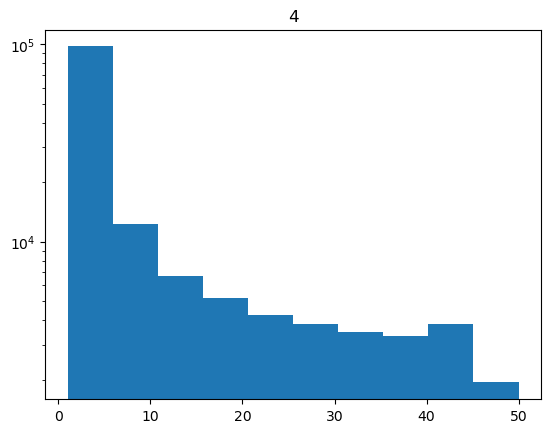

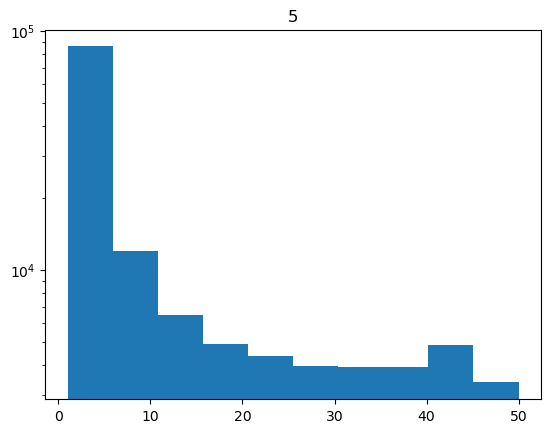

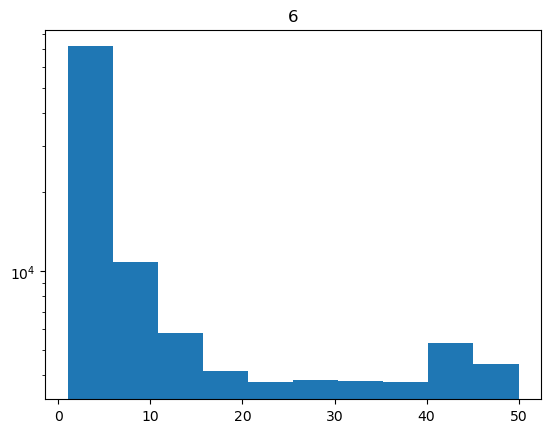

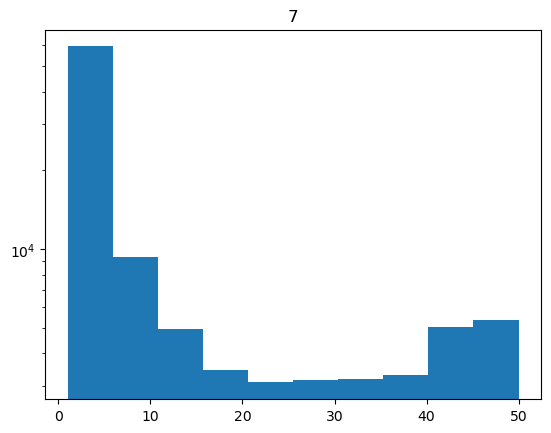

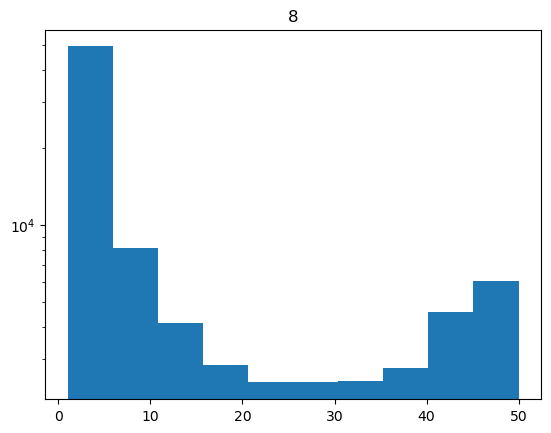

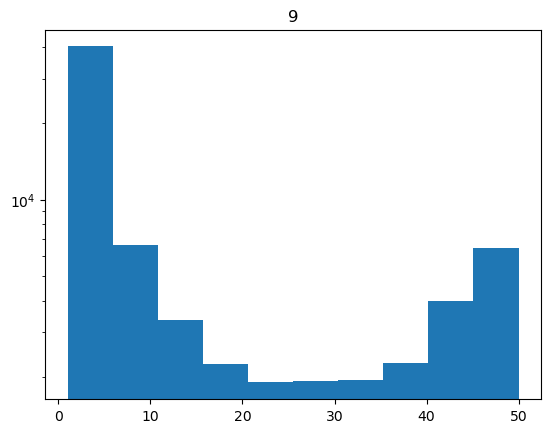

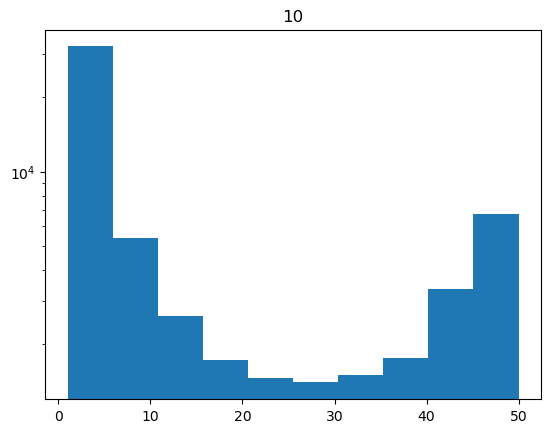

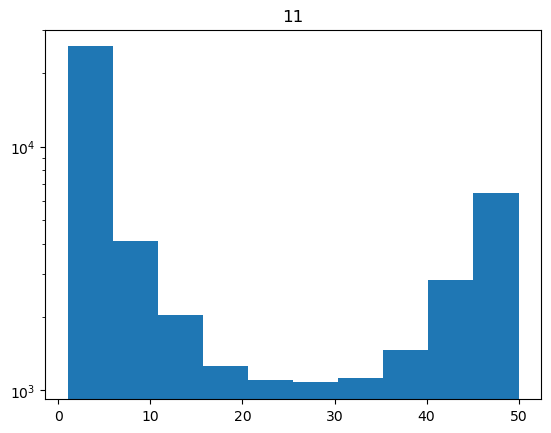

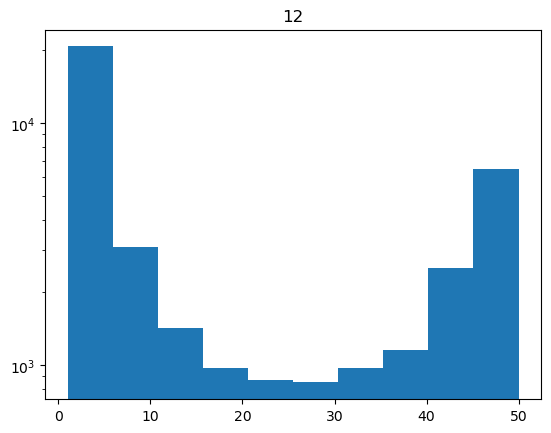

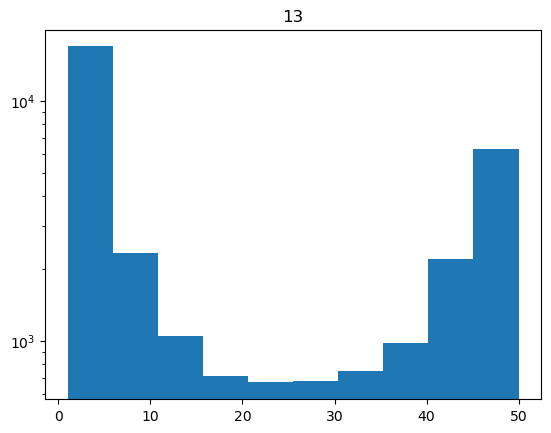

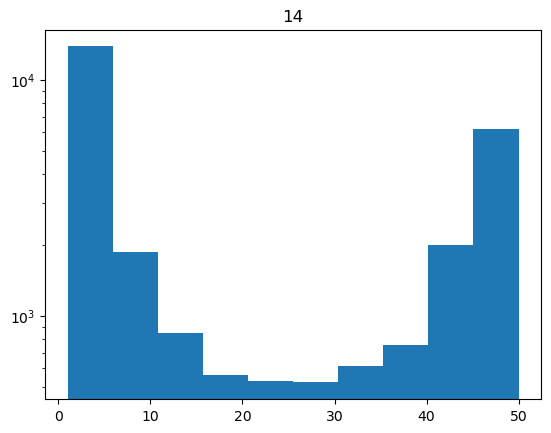

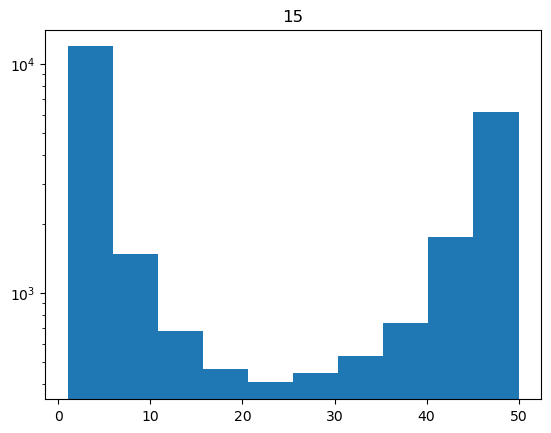

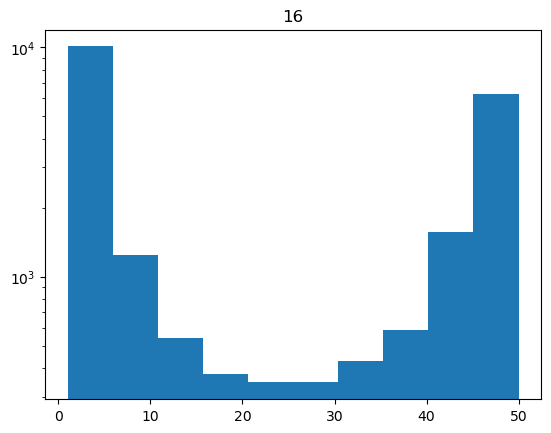

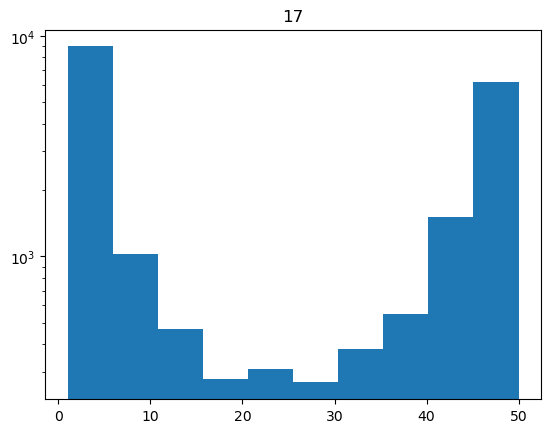

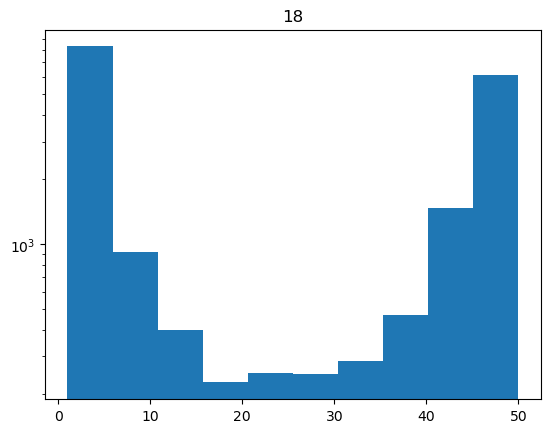

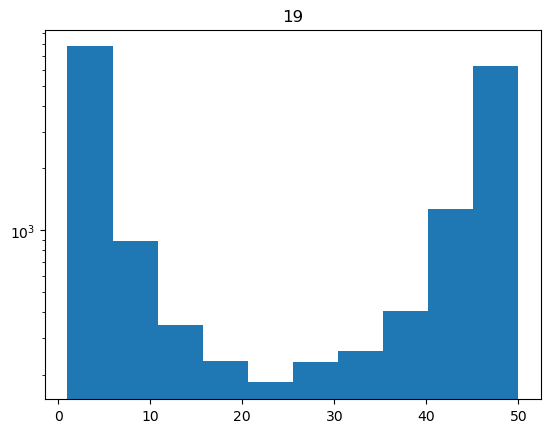

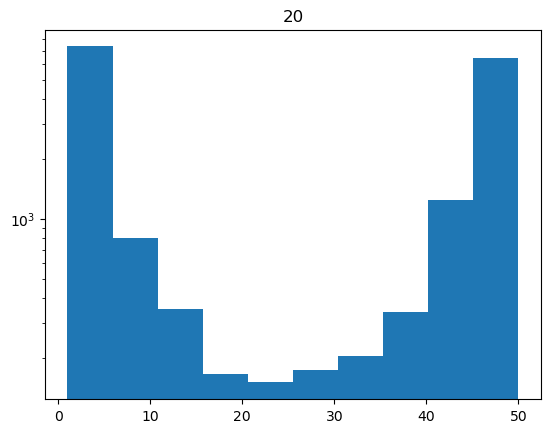

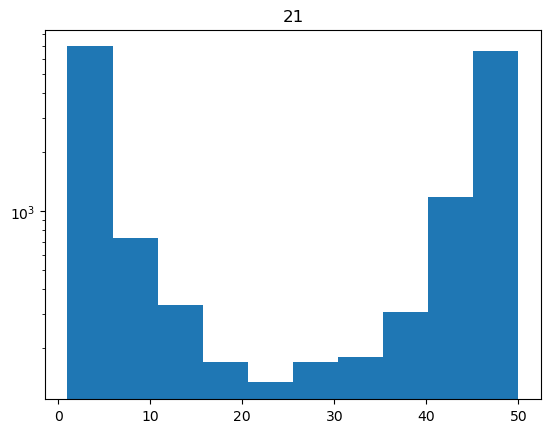

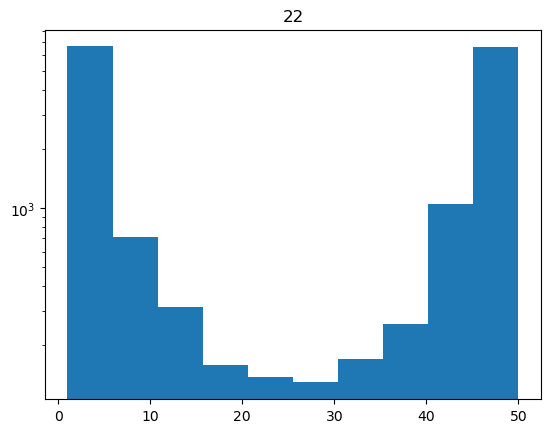

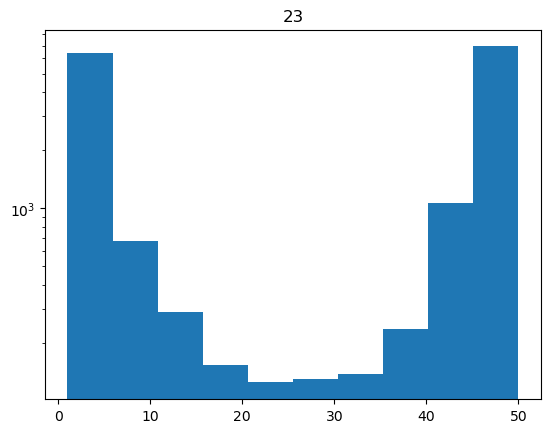

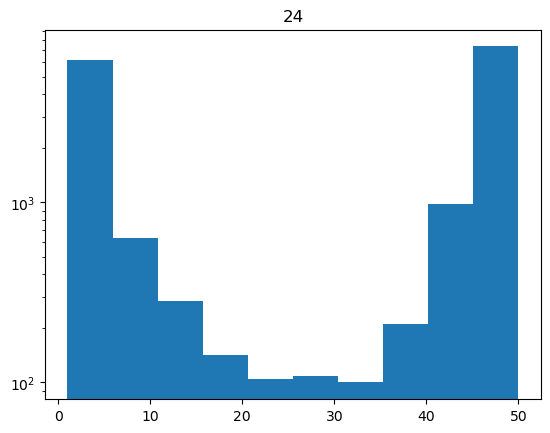

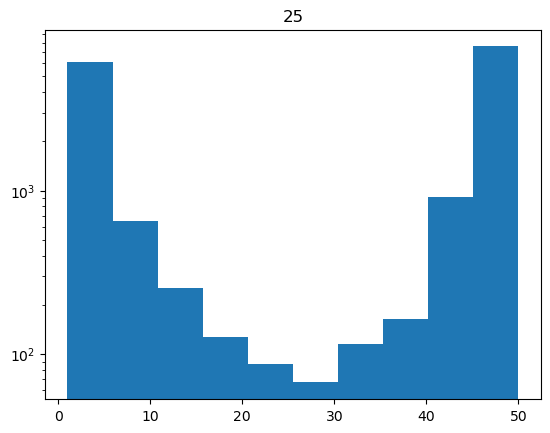

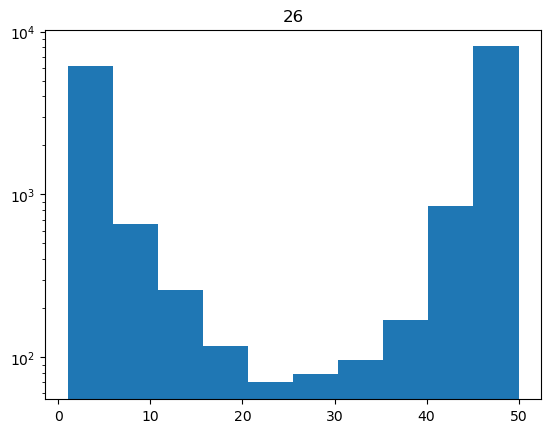

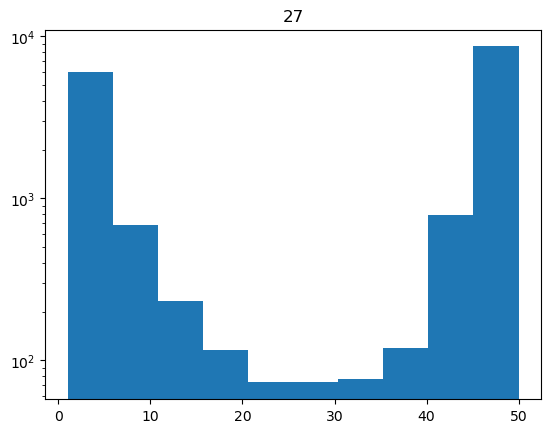

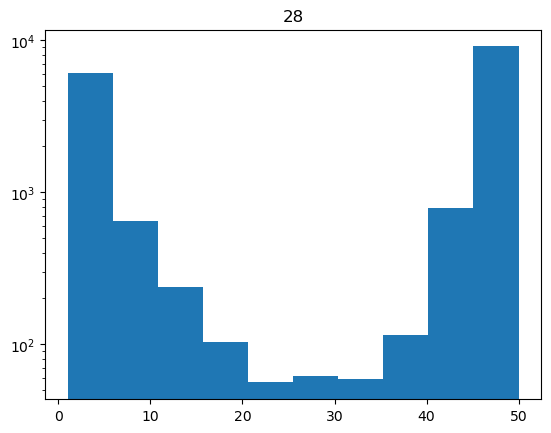

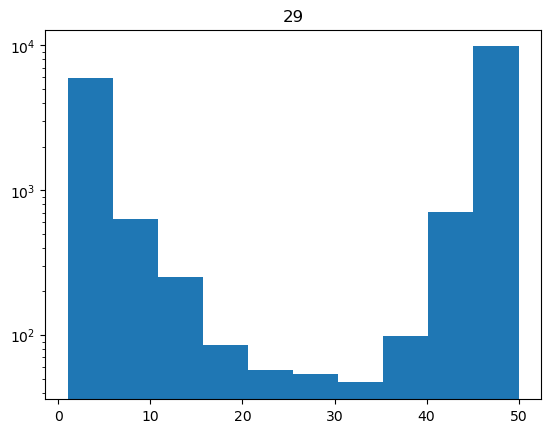

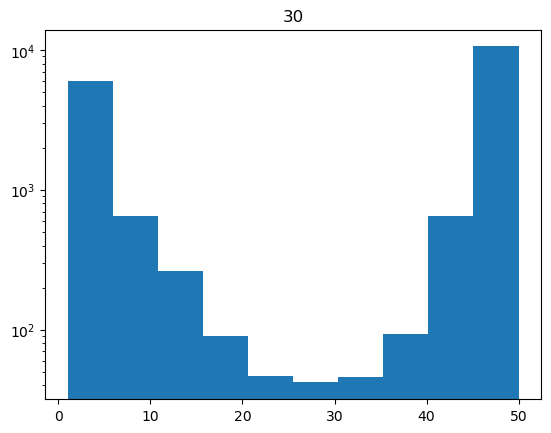

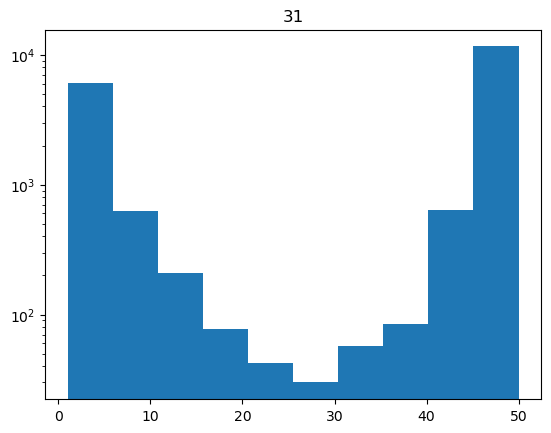

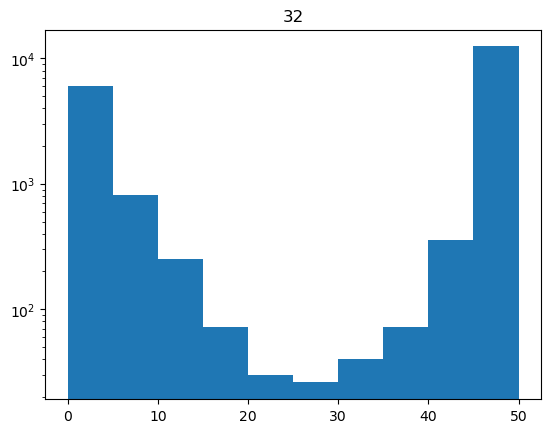

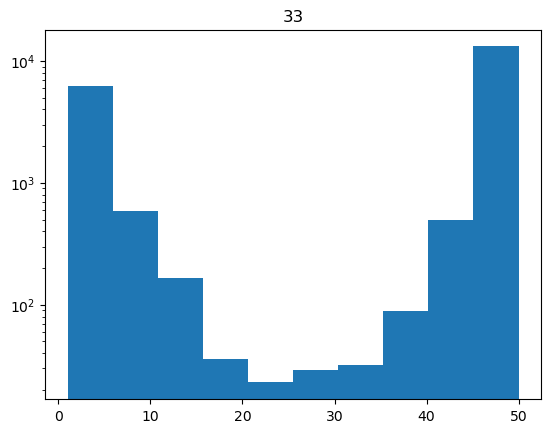

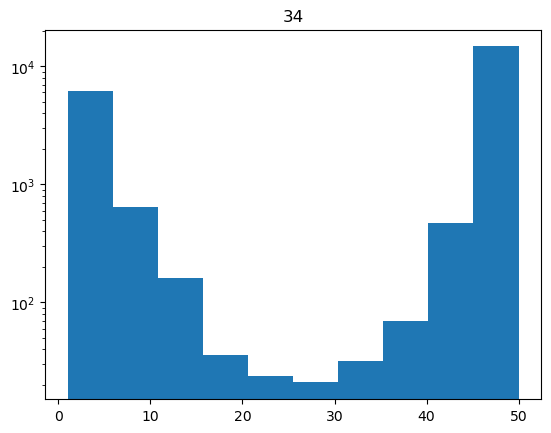

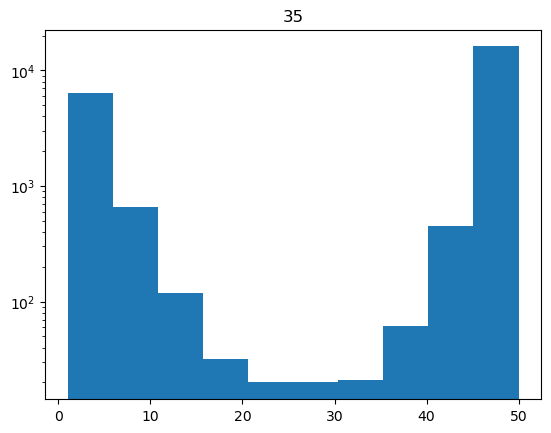

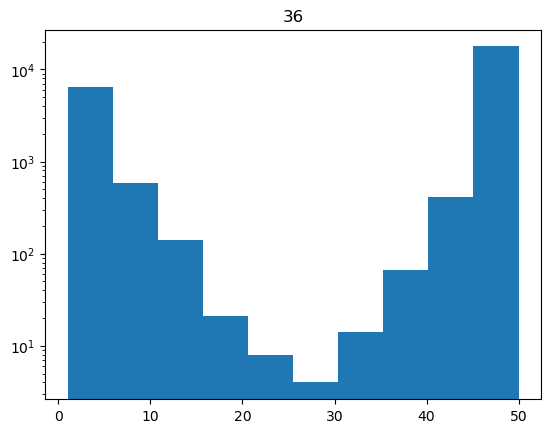

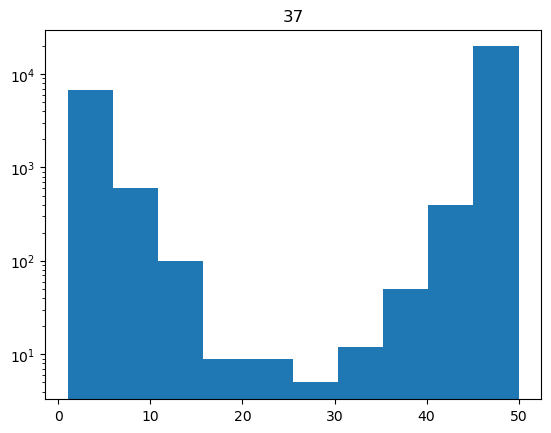

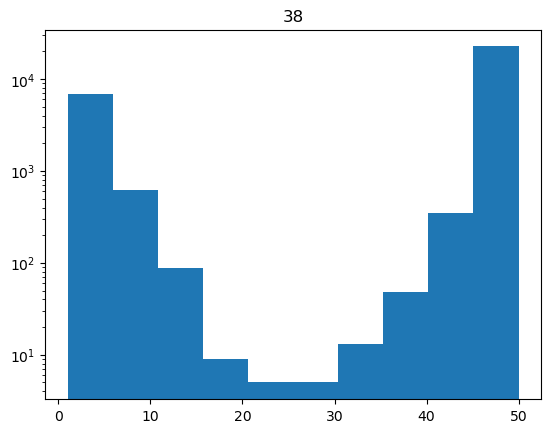

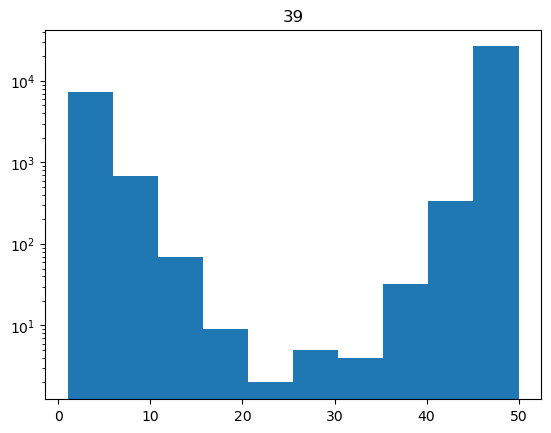

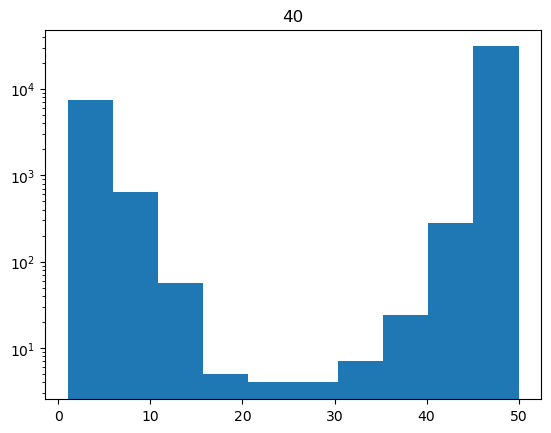

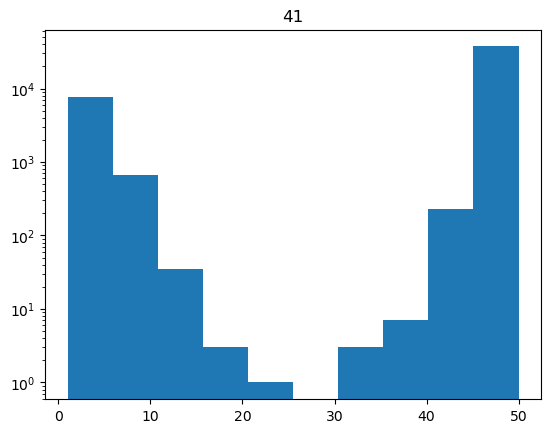

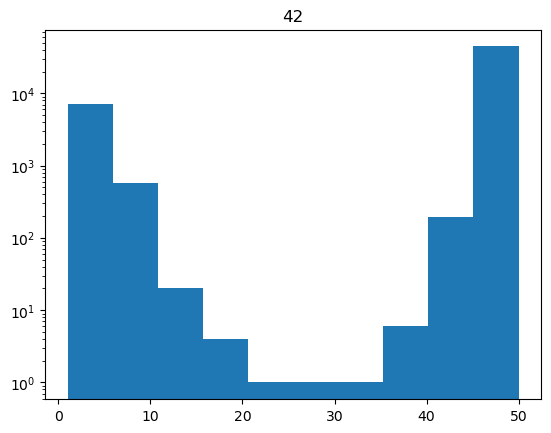

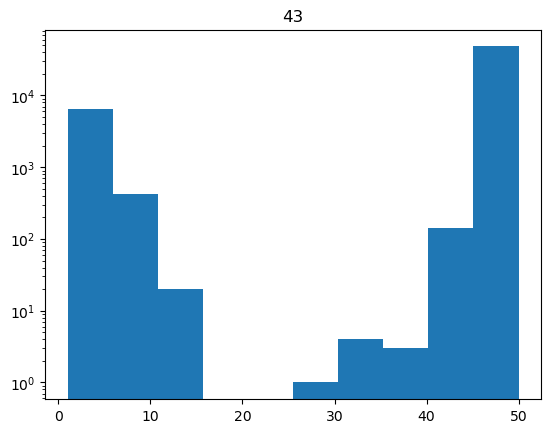

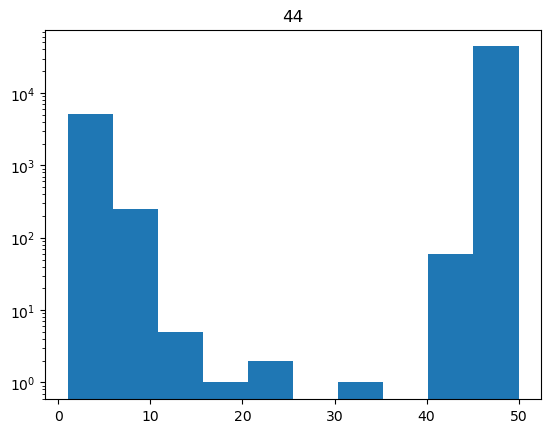

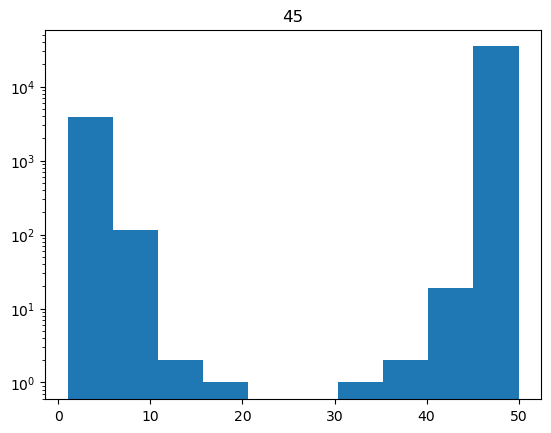

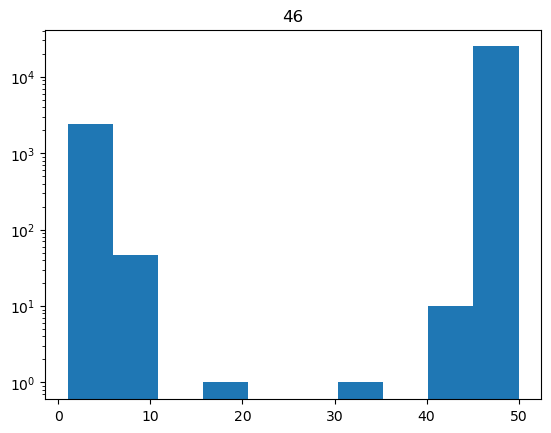

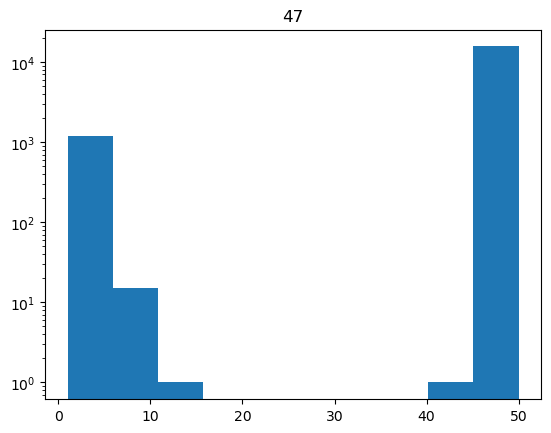

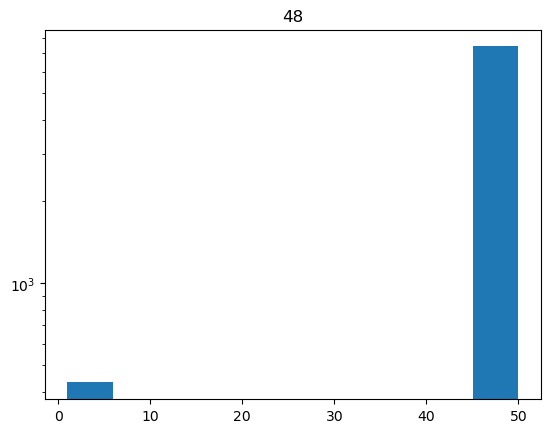

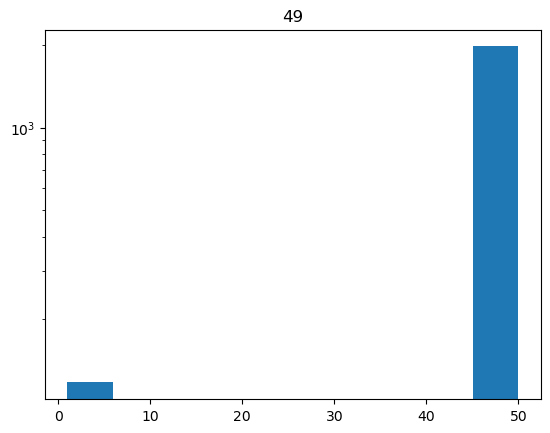

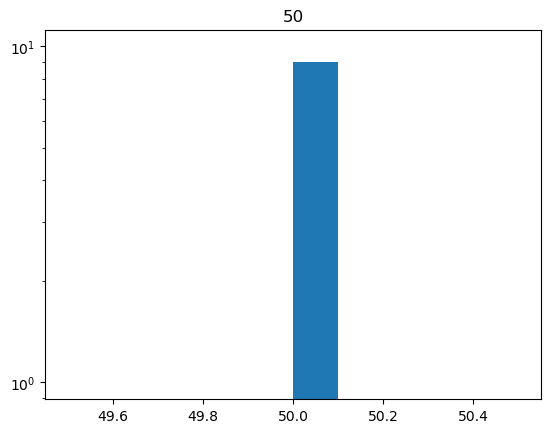

In [58]:
for i in range(L+1):
    plt.title(i)
    plt.hist(dataDic2[i],log=True)
    plt.show()

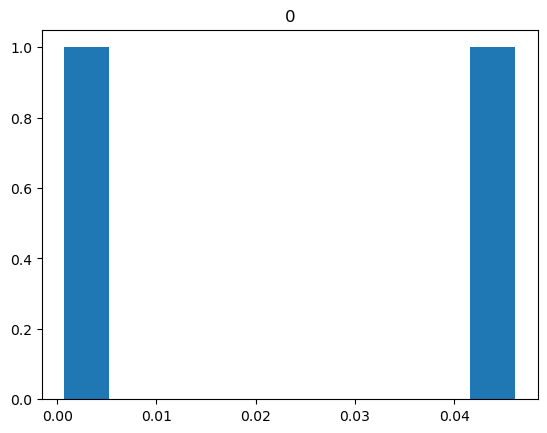

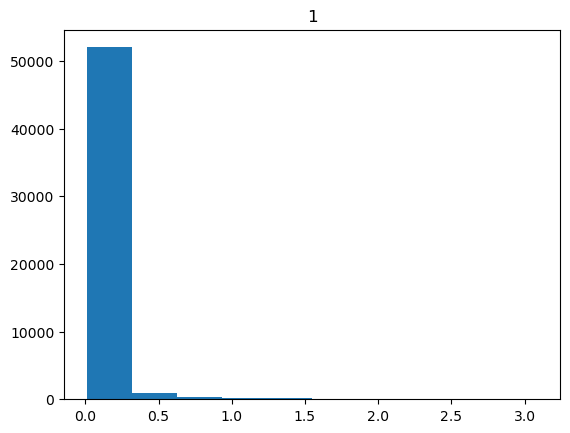

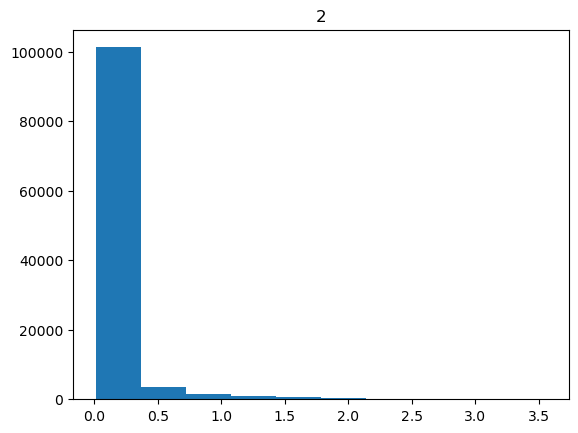

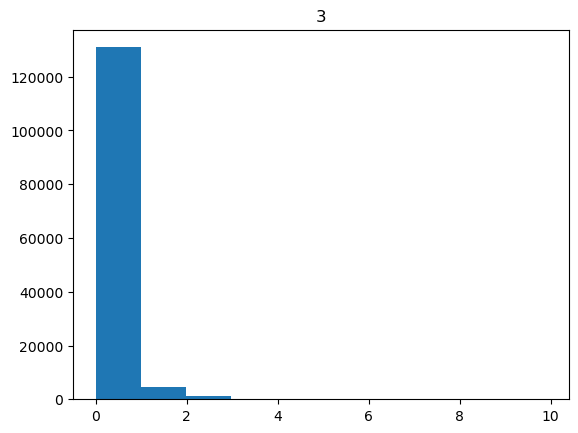

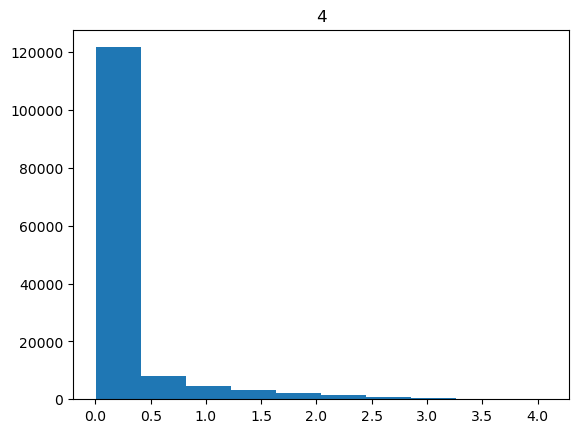

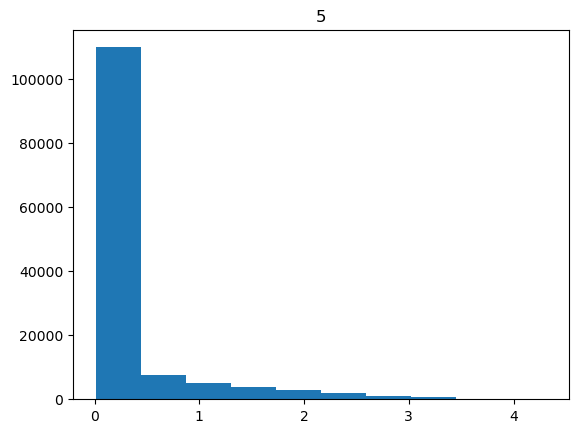

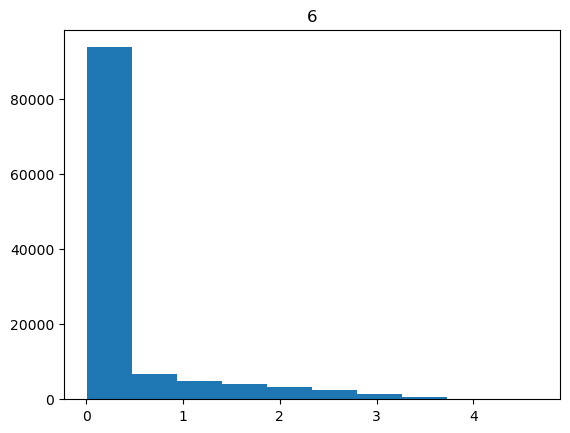

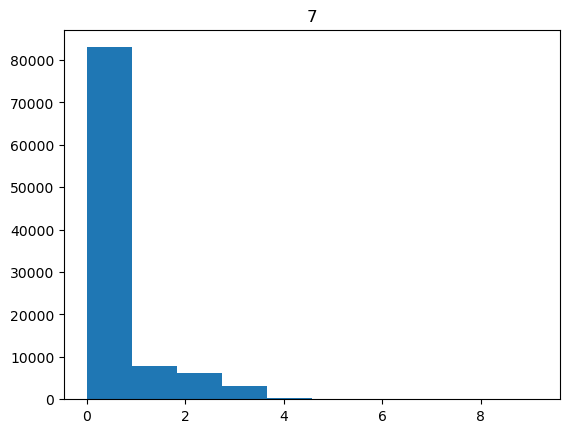

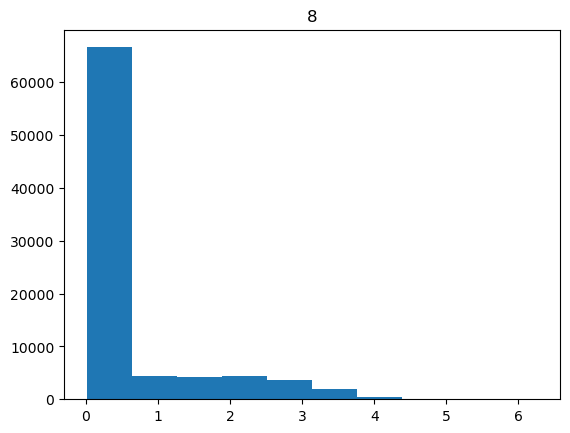

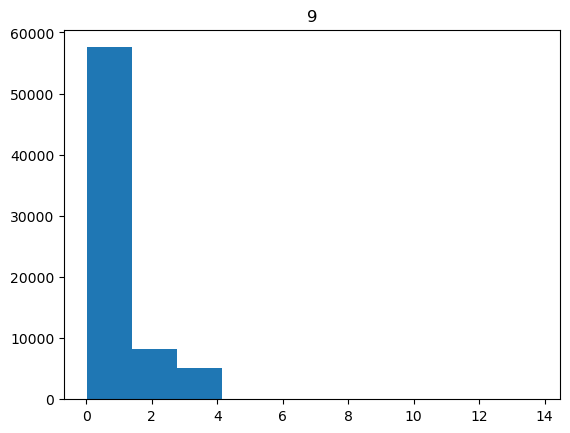

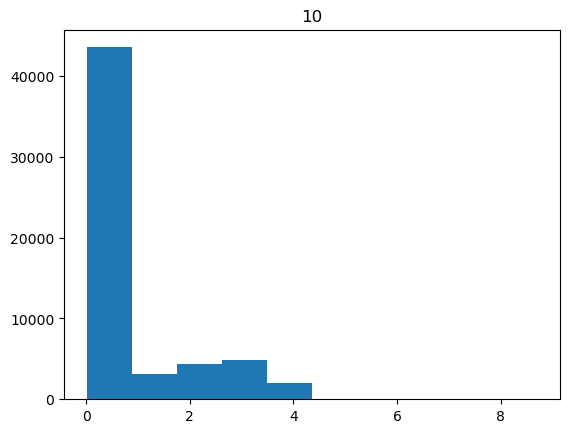

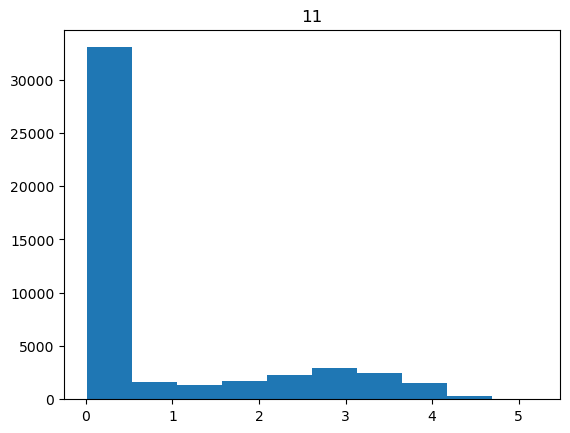

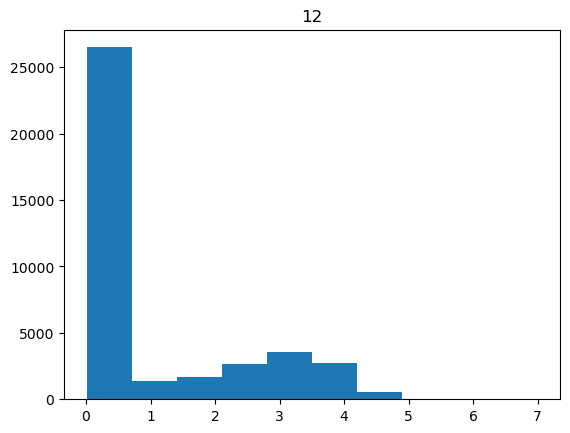

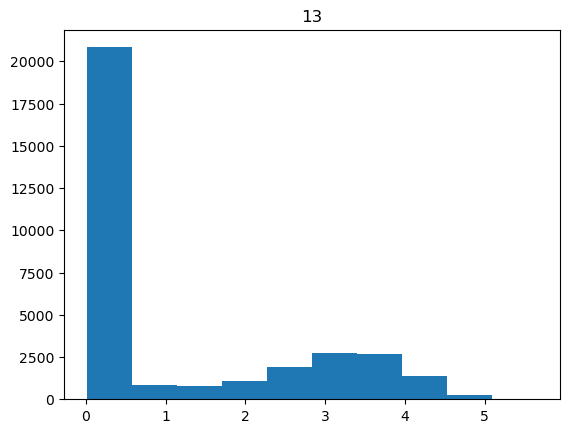

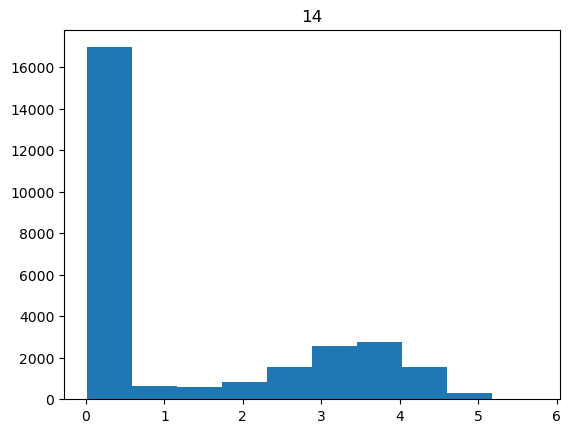

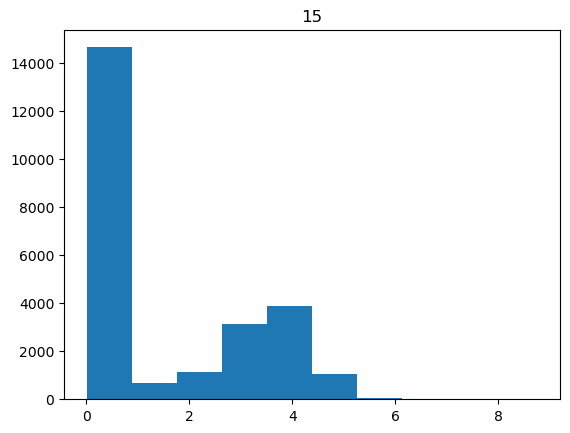

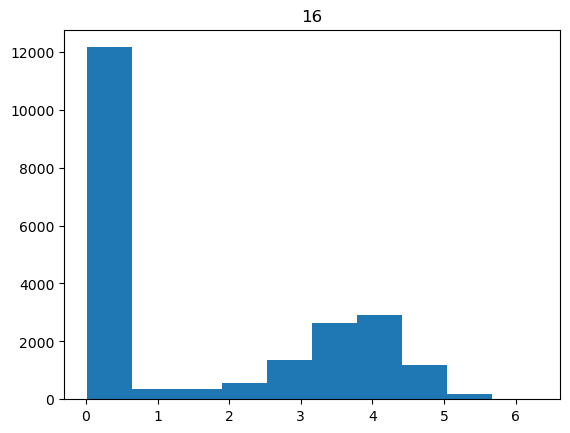

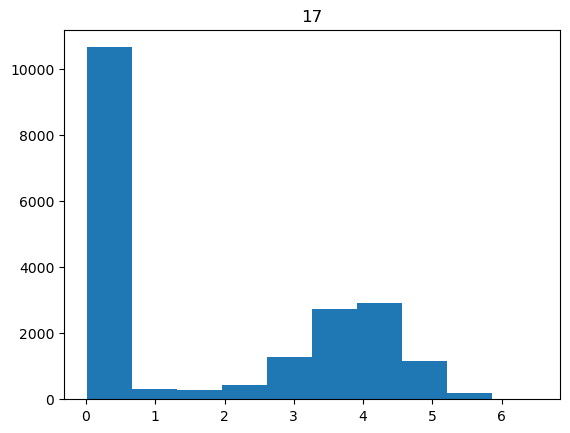

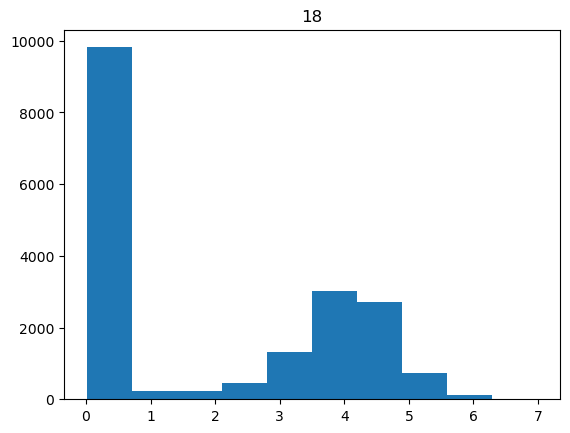

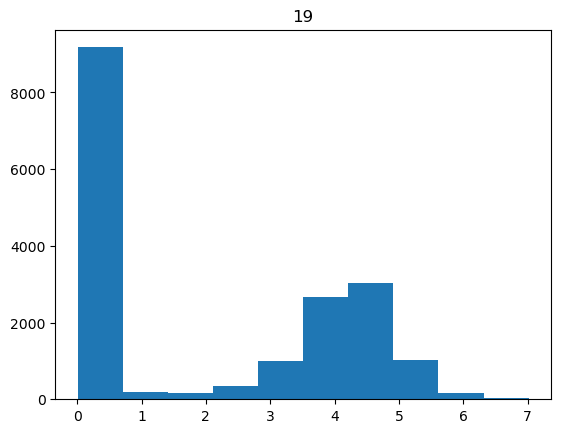

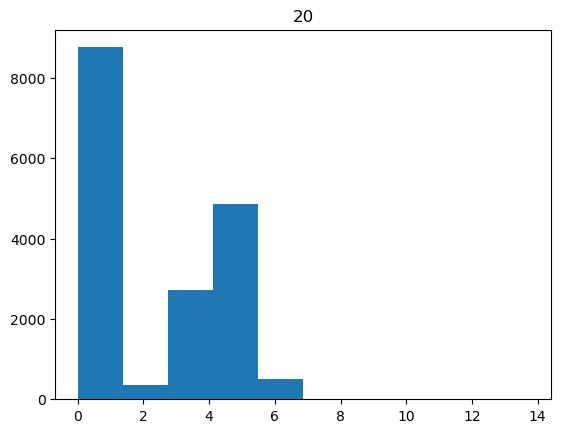

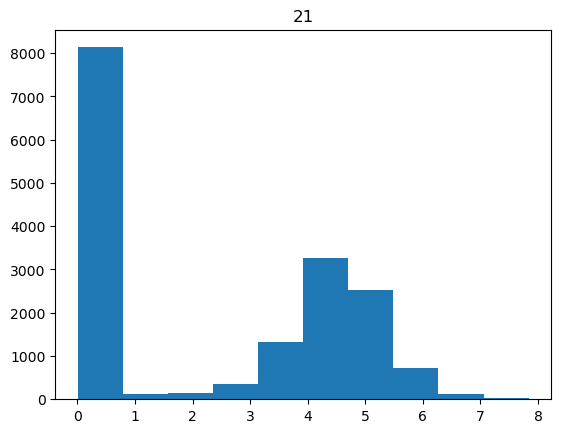

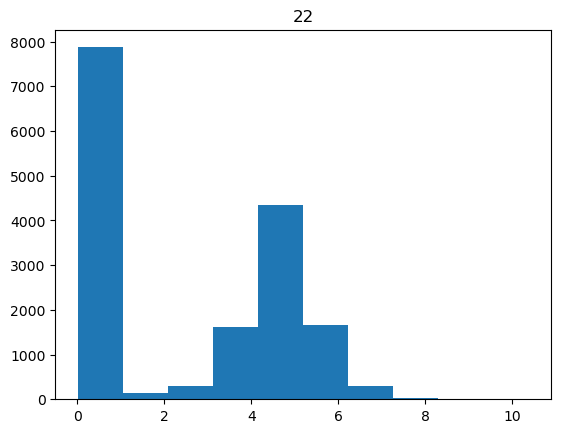

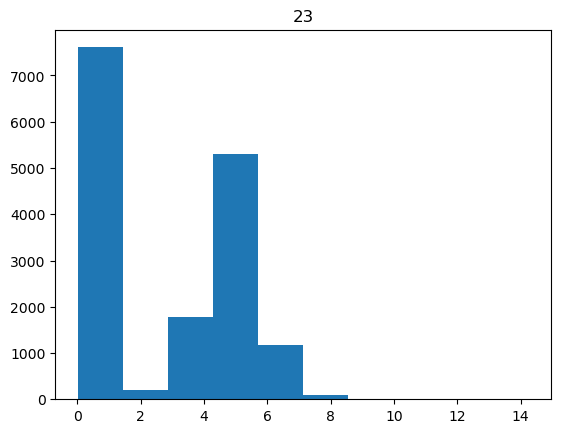

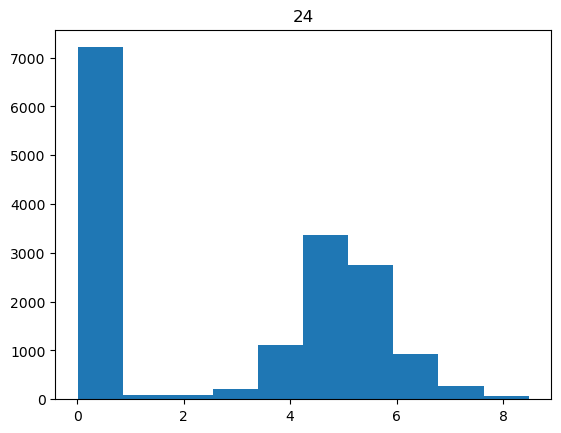

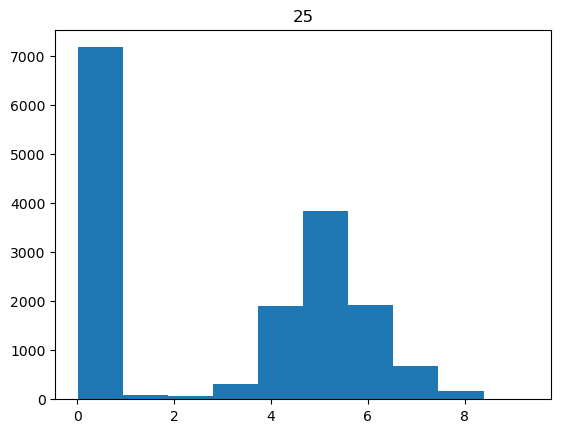

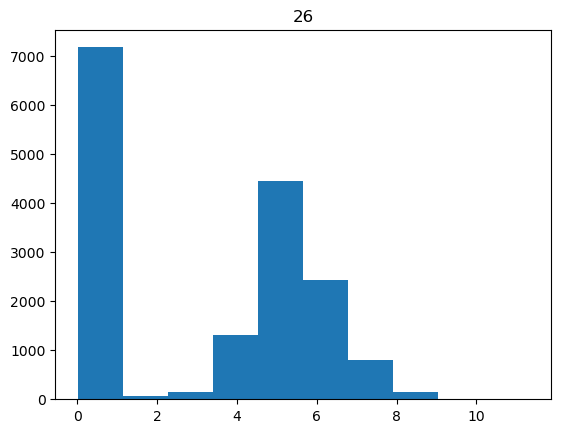

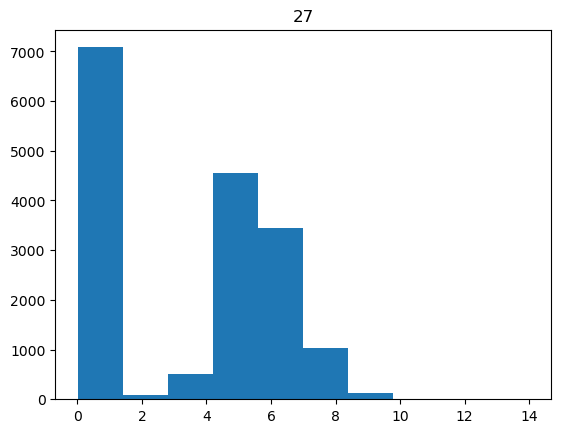

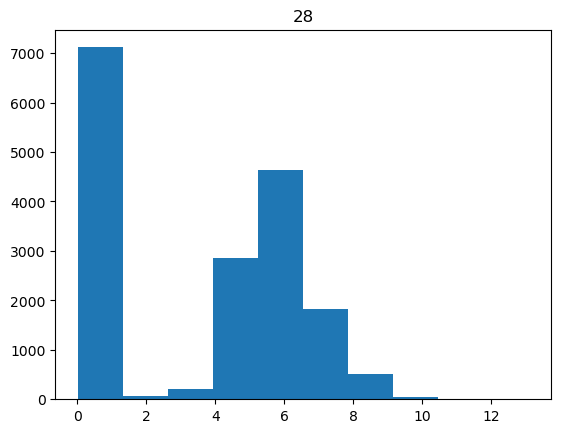

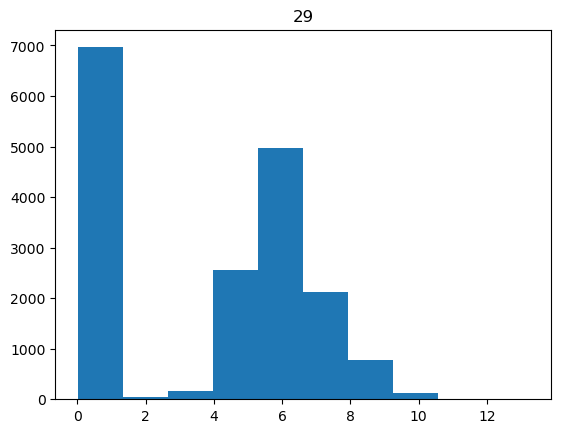

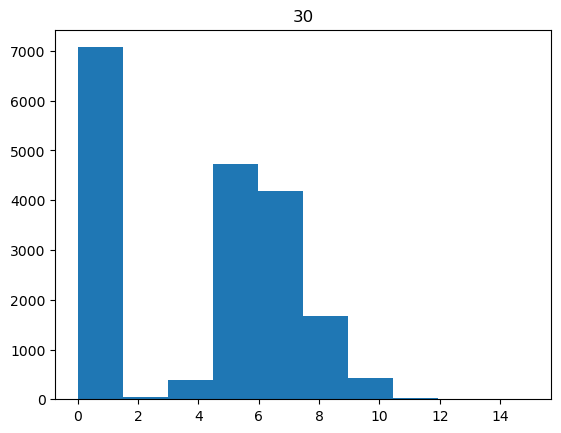

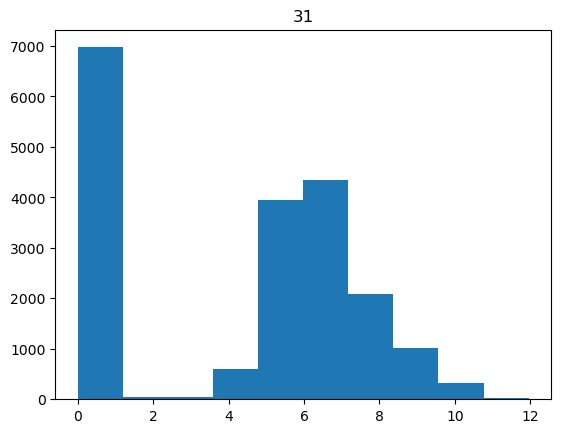

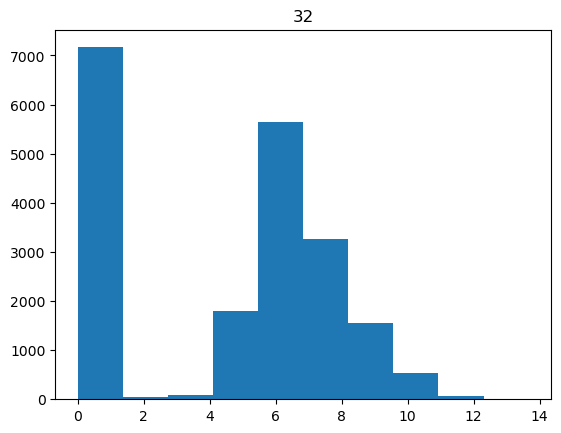

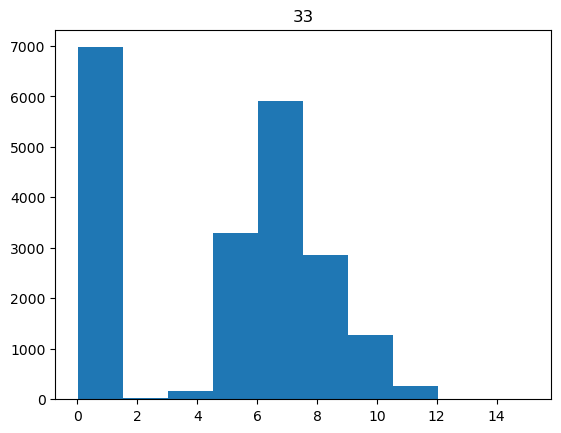

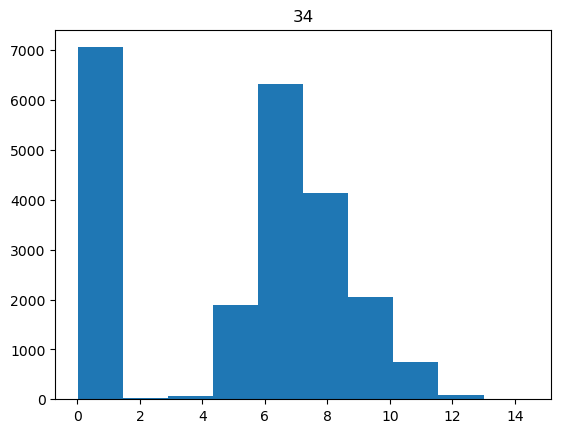

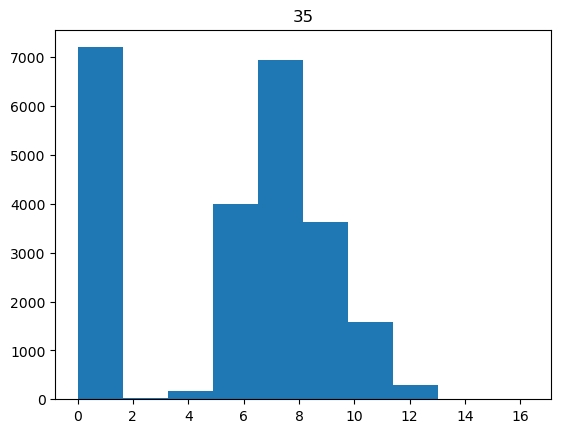

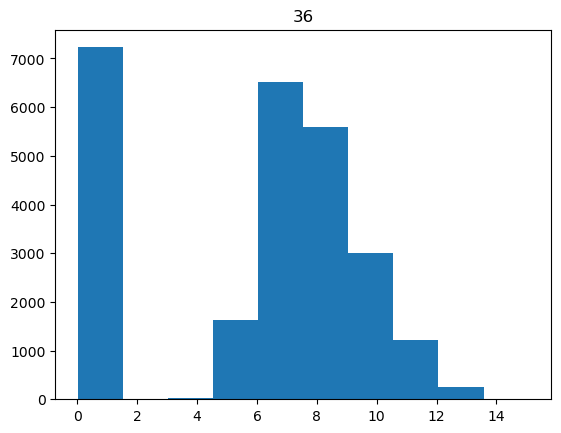

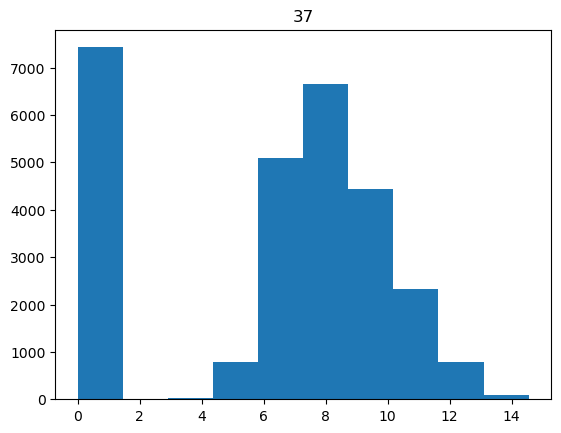

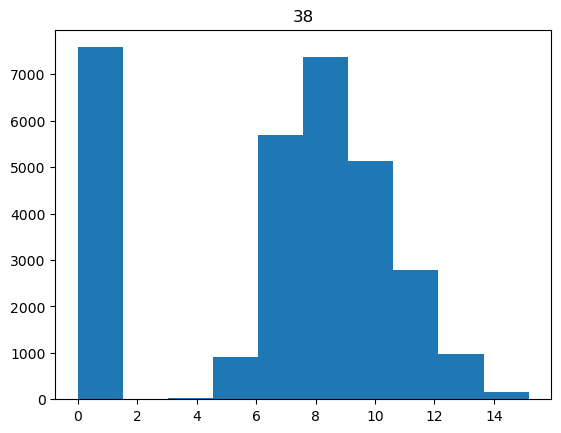

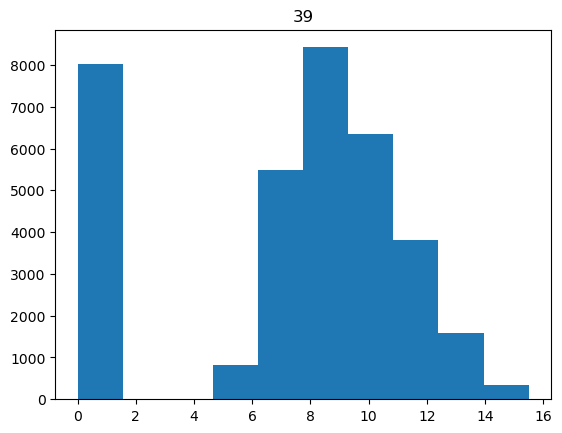

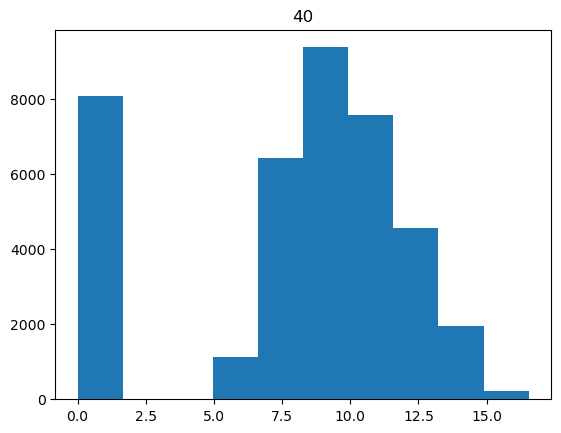

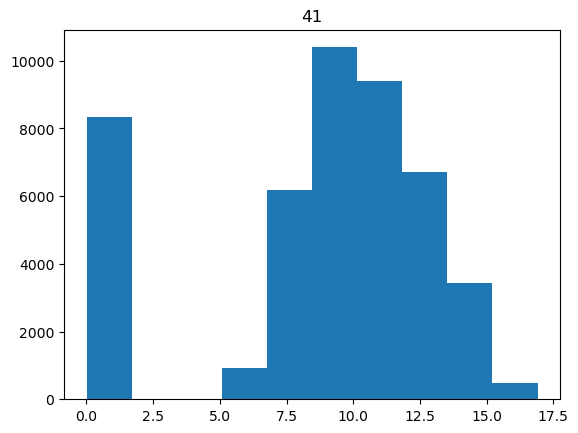

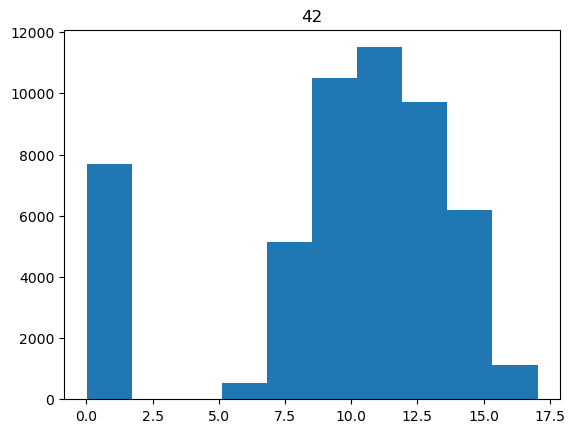

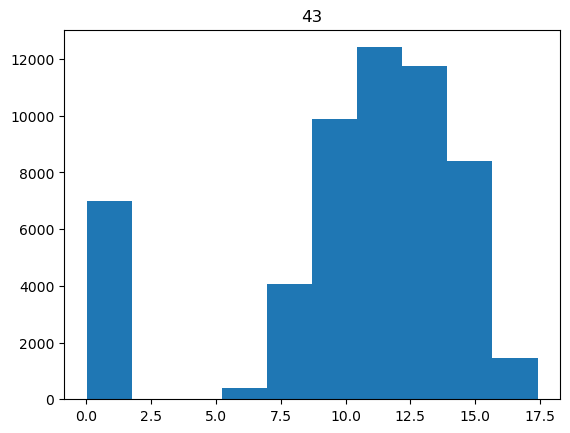

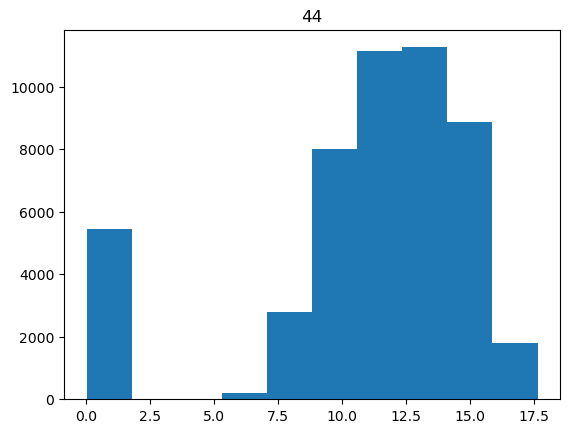

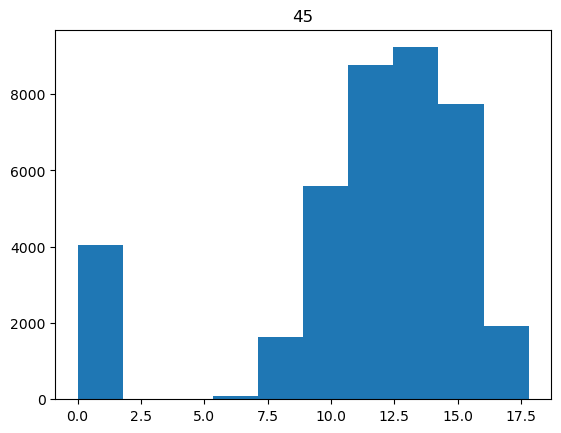

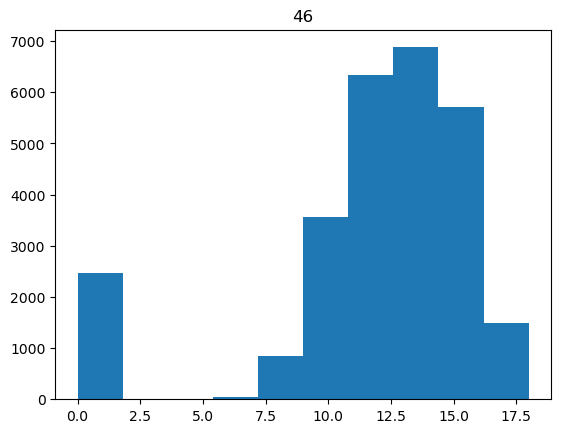

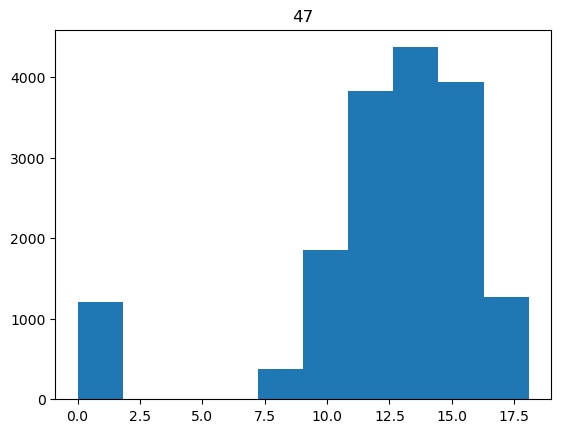

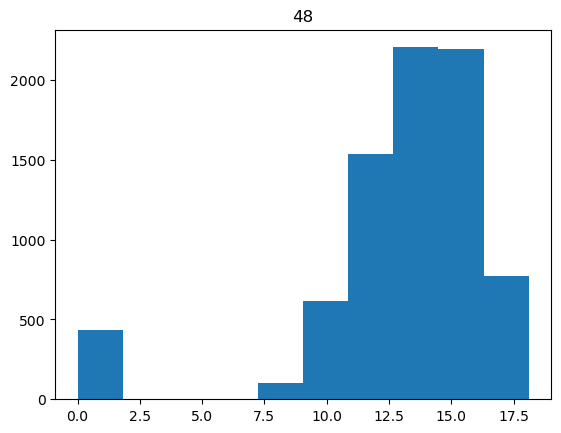

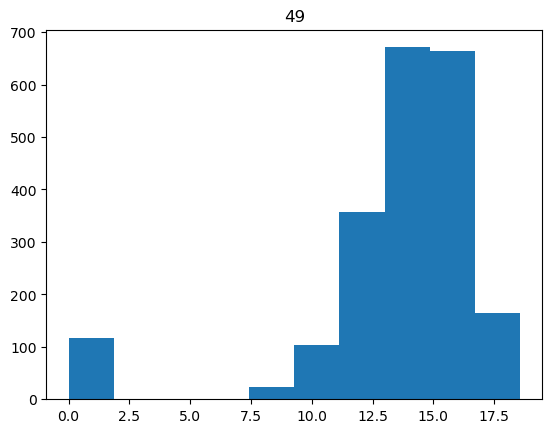

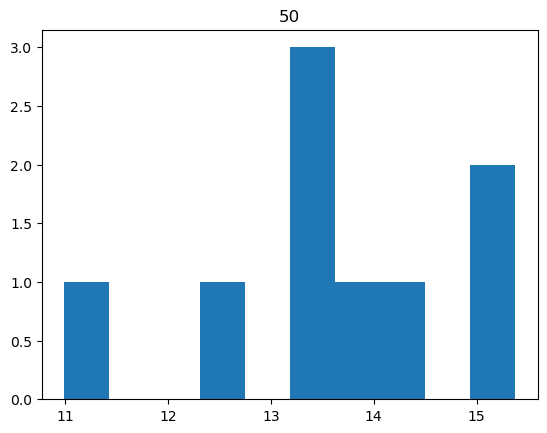

In [60]:
for i in range(L+1):
    plt.title(i)
    plt.hist(dataDic1[i],log=False)
    plt.show()

In [86]:
arr = np.random.randint(0,2,20)
arr

array([0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0])

array([0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0])

6

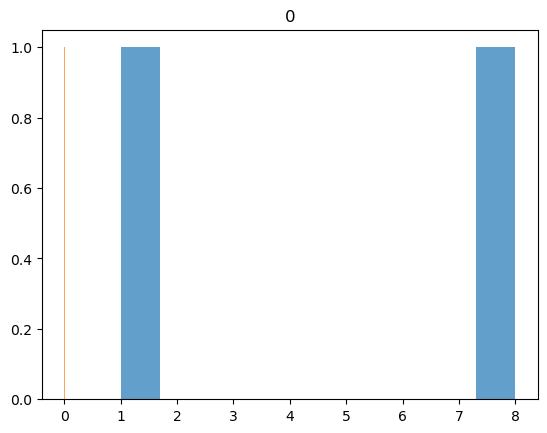

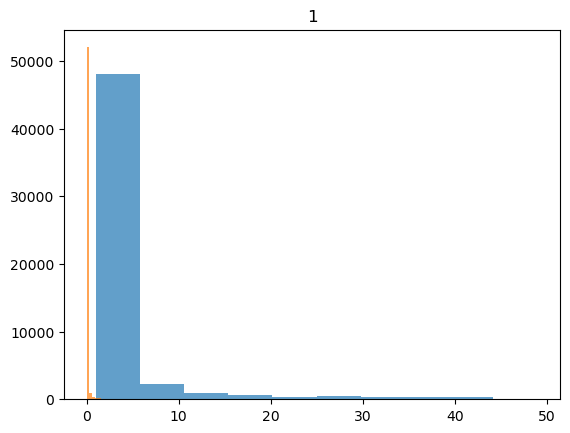

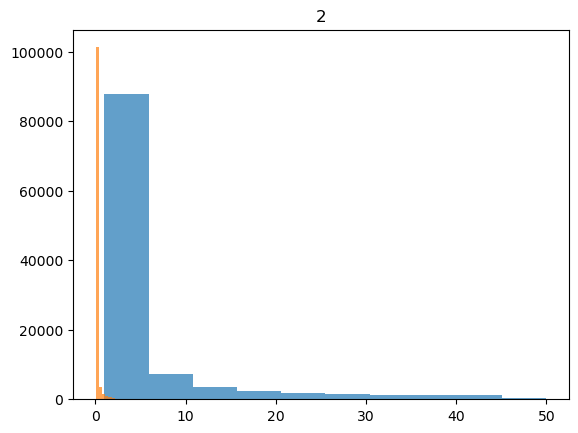

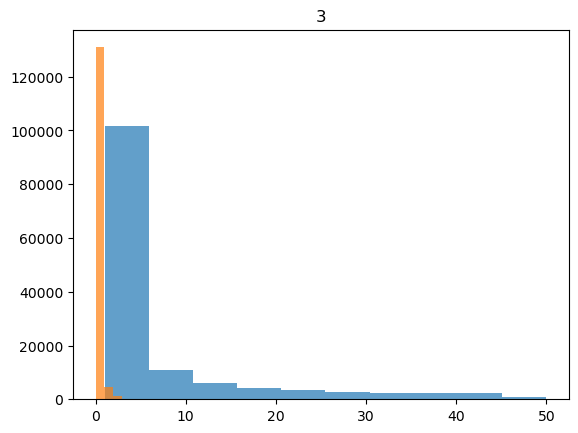

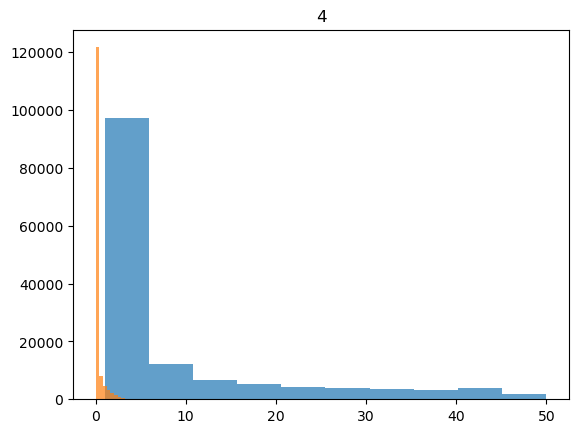

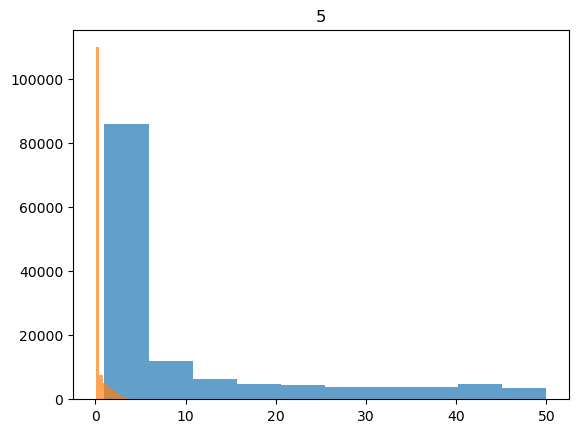

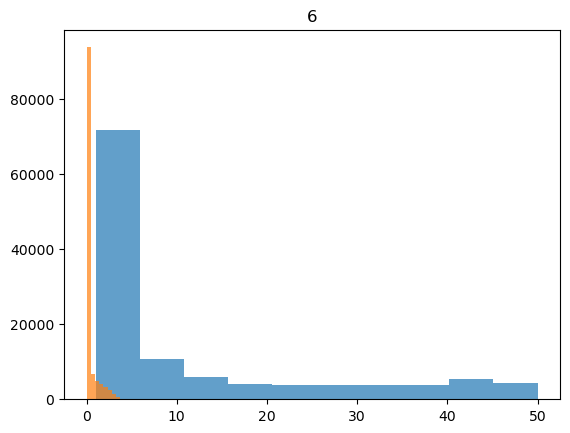

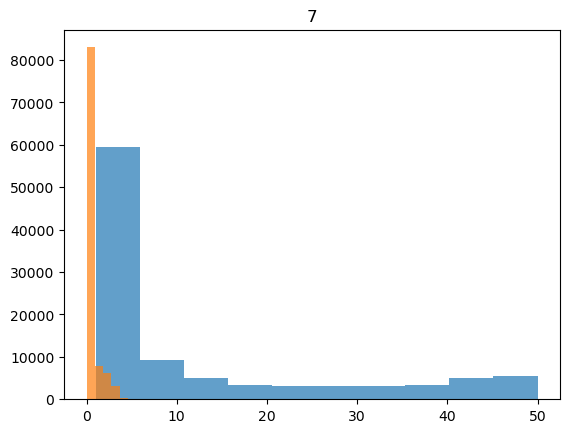

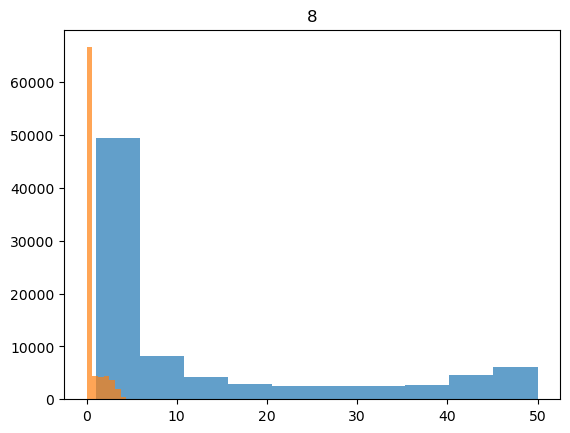

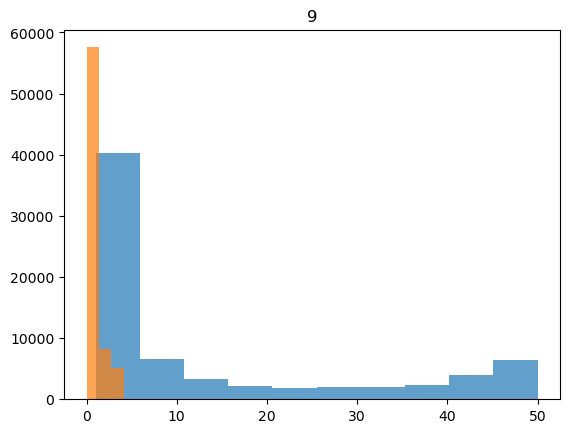

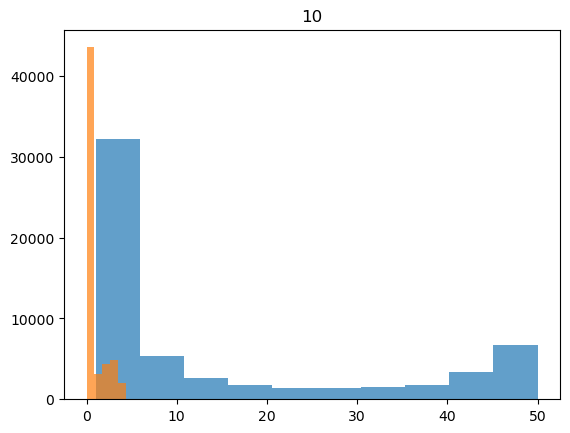

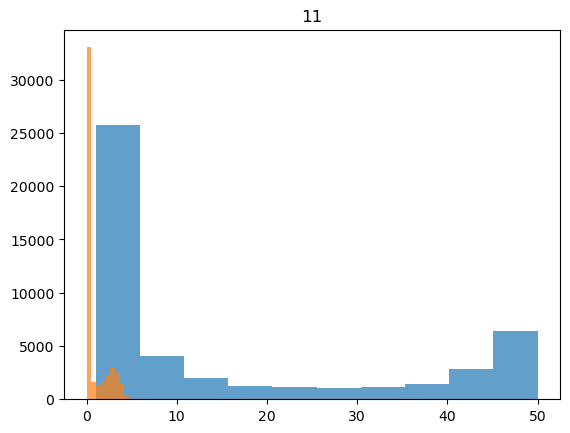

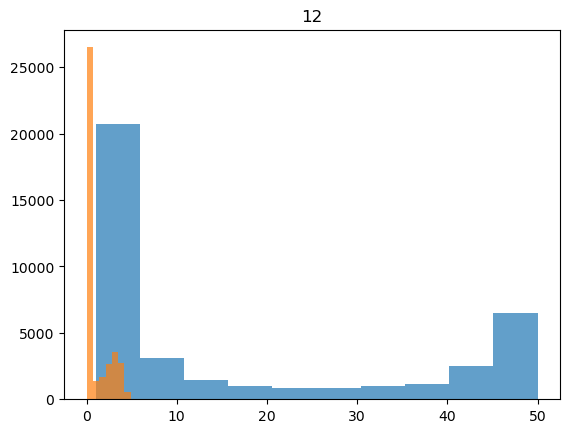

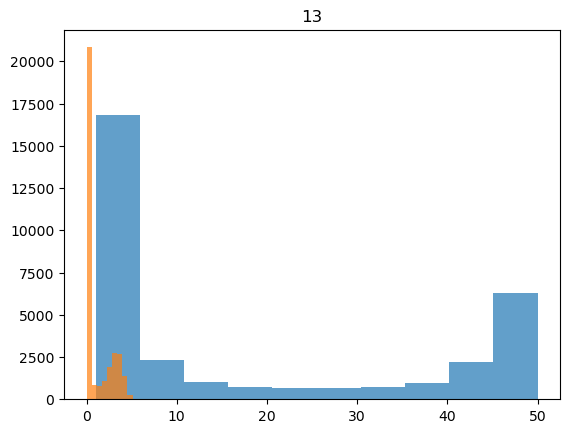

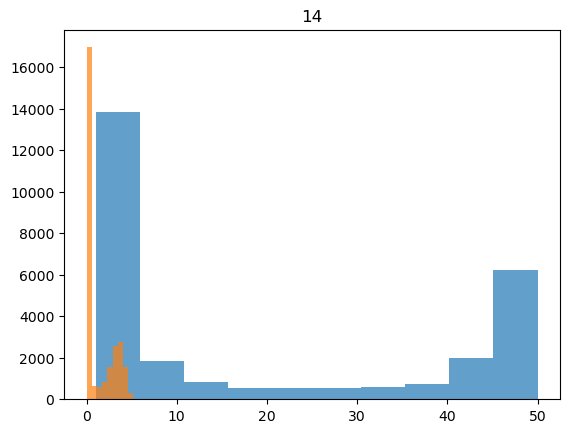

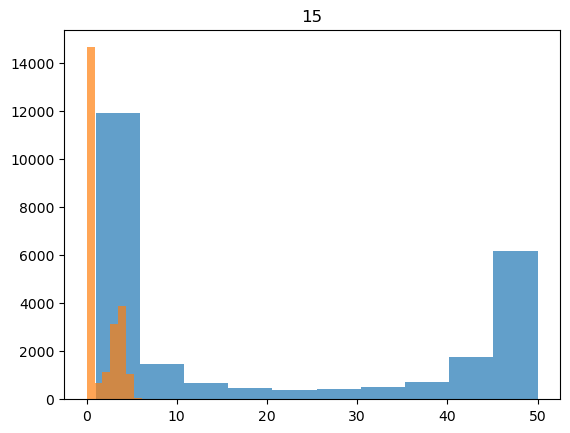

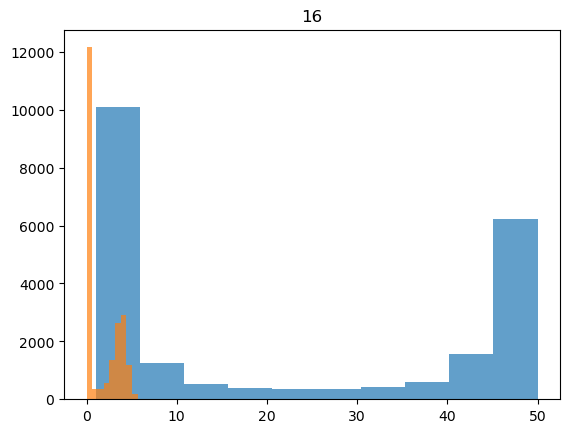

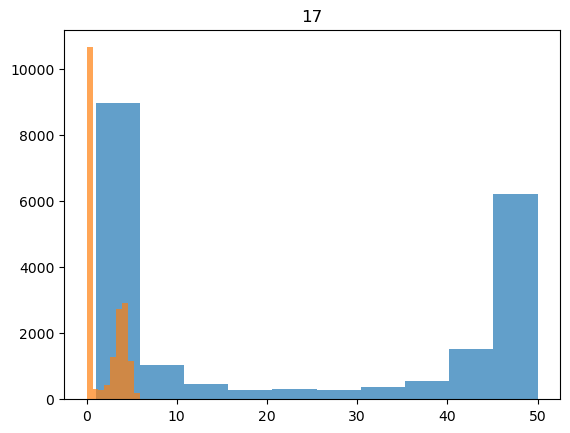

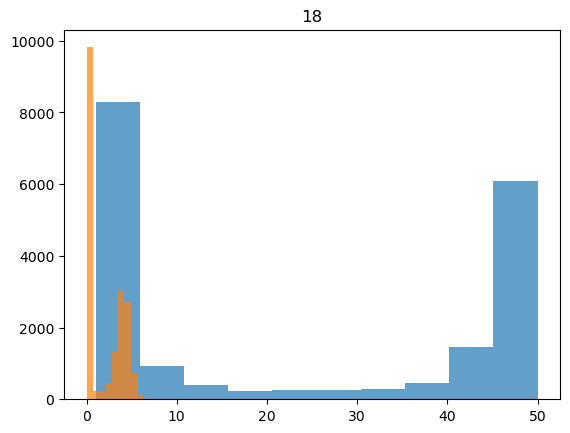

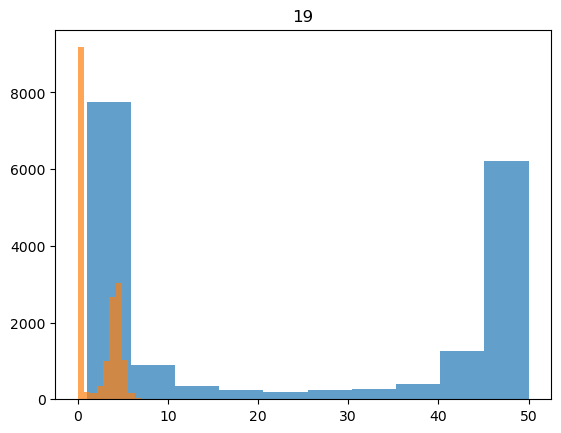

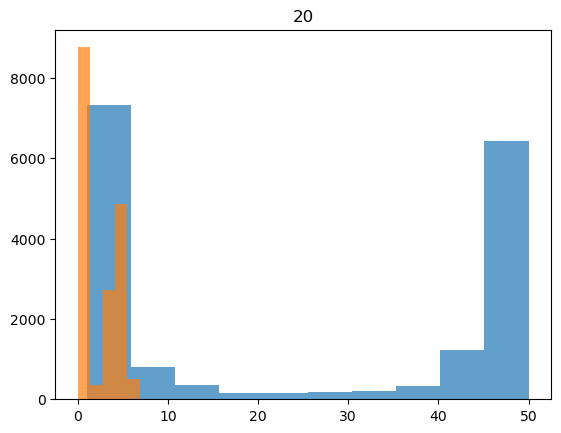

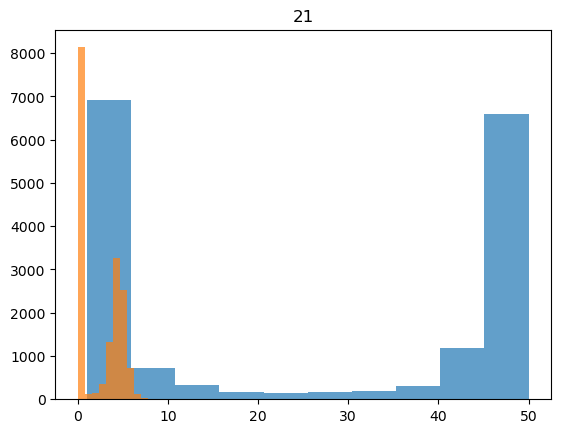

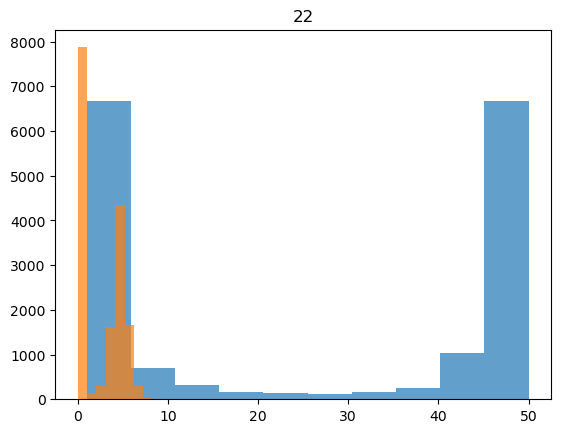

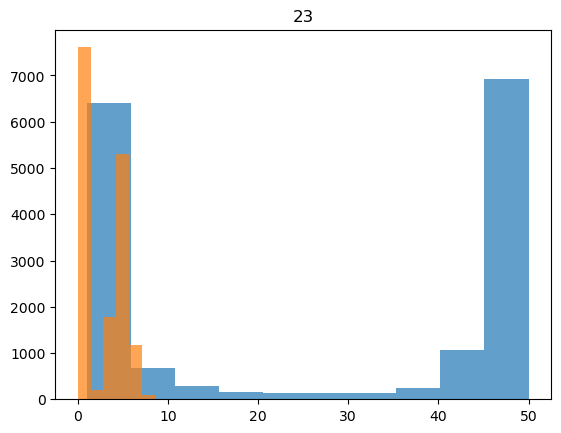

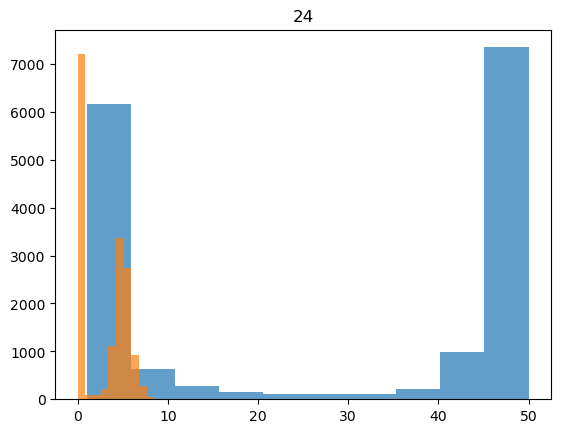

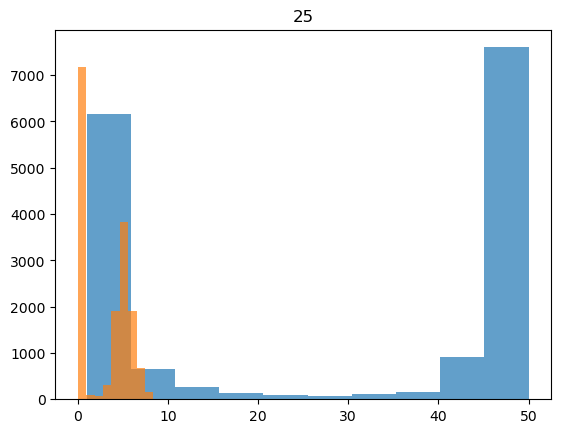

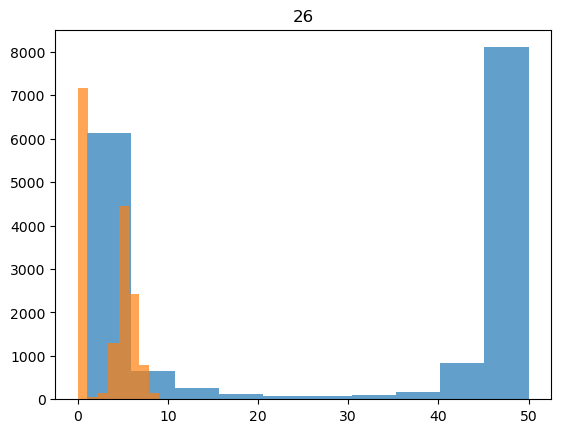

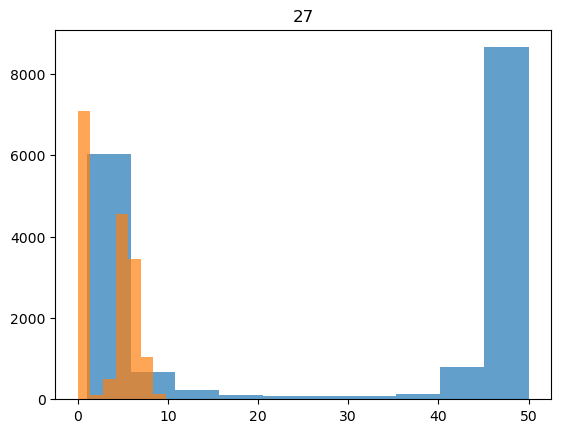

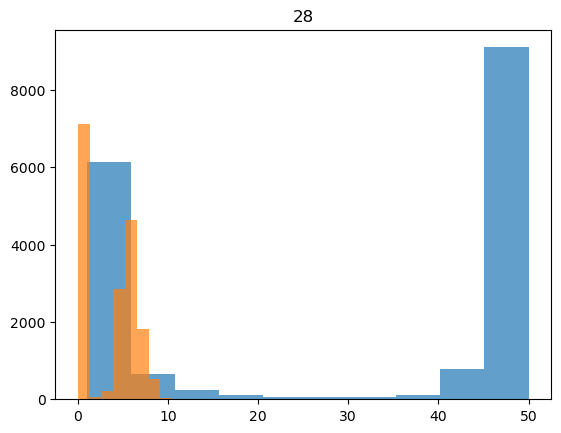

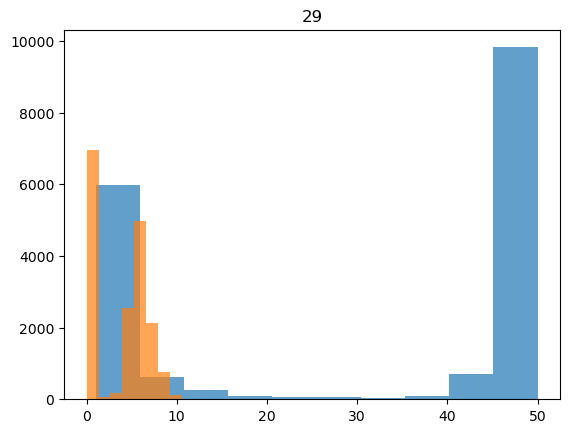

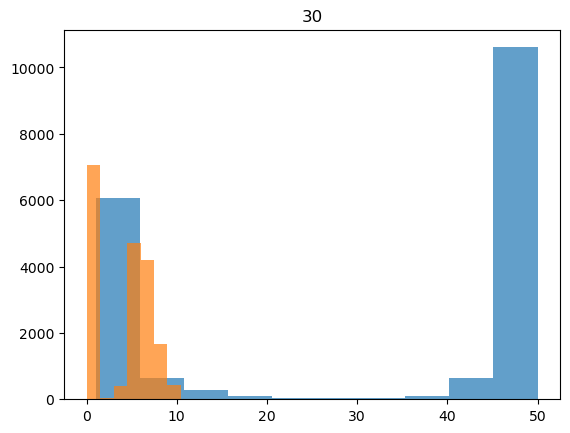

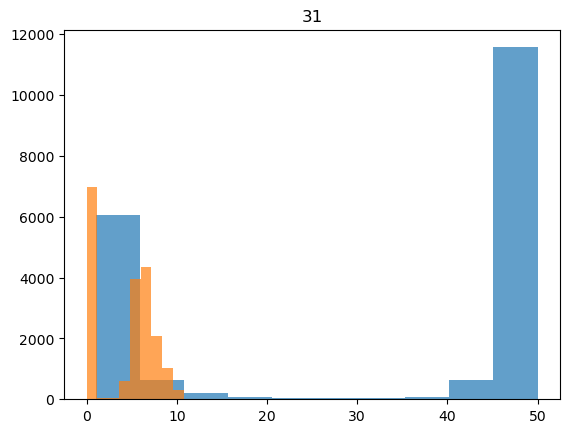

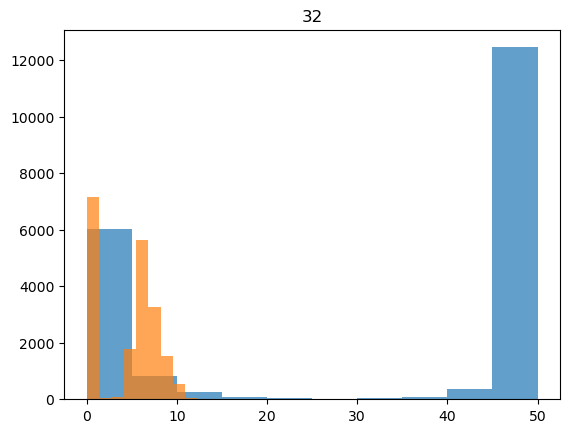

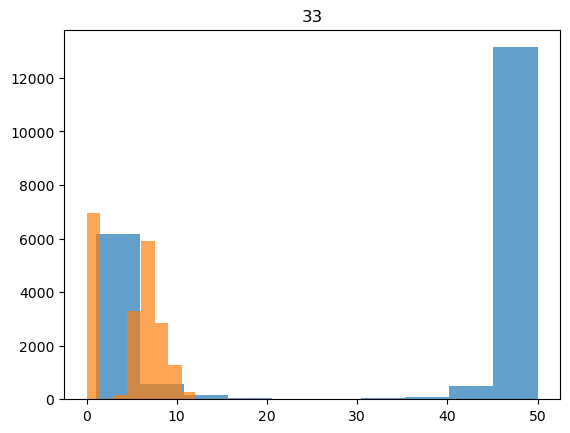

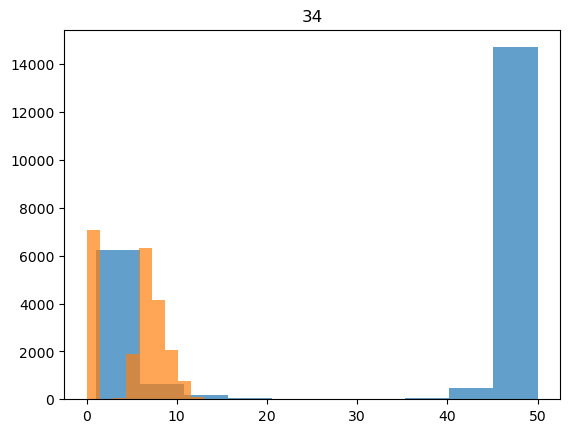

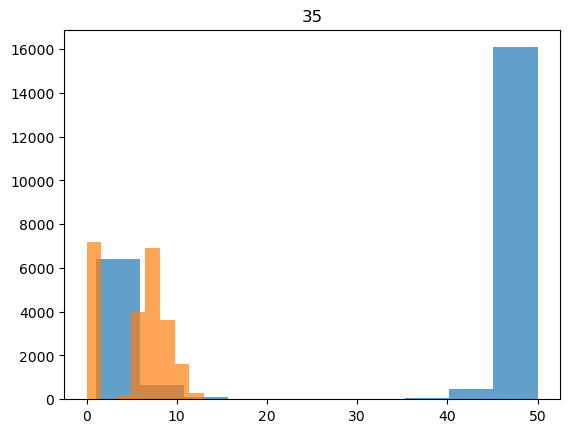

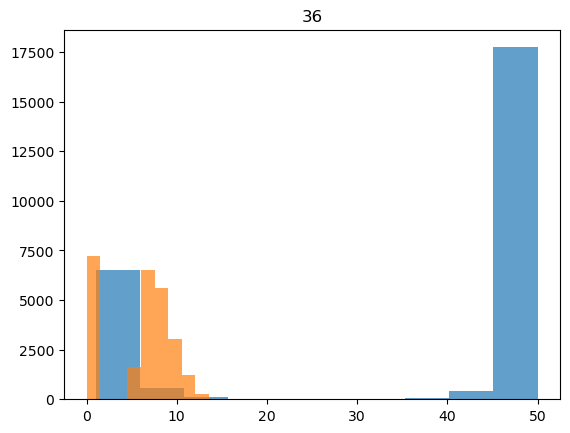

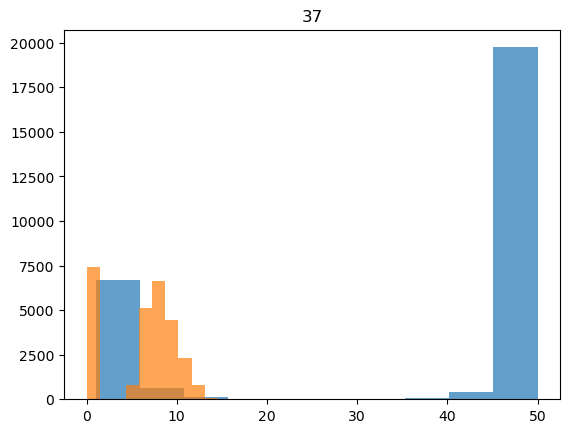

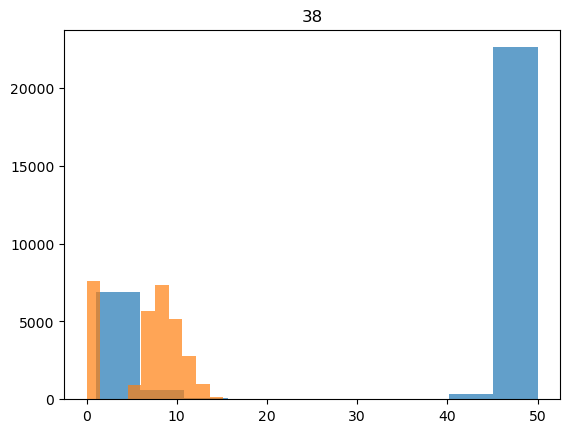

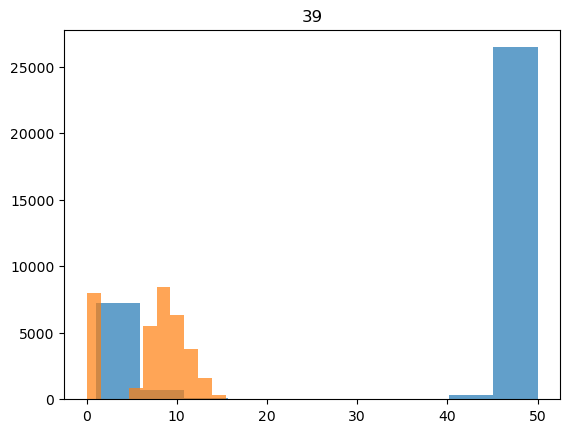

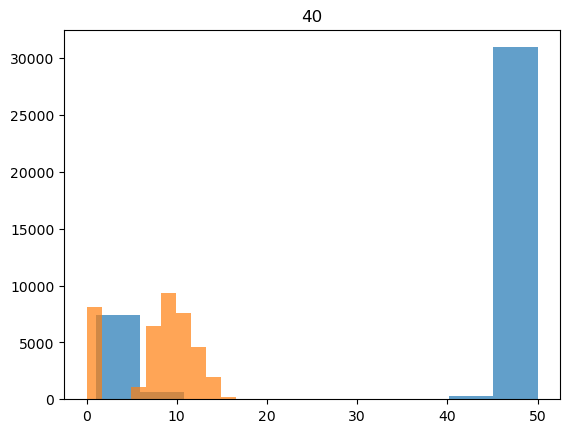

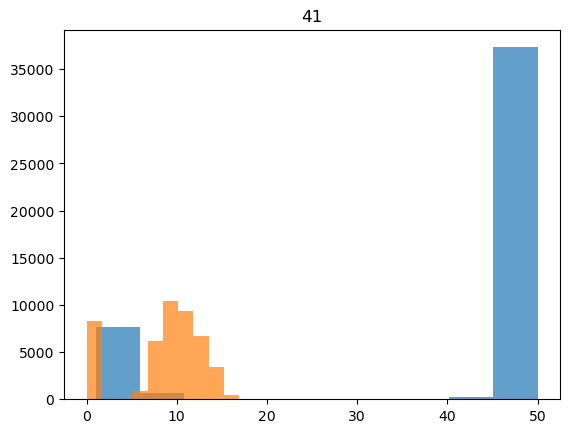

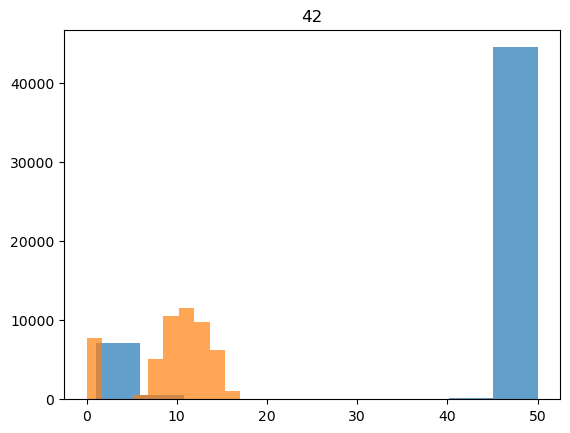

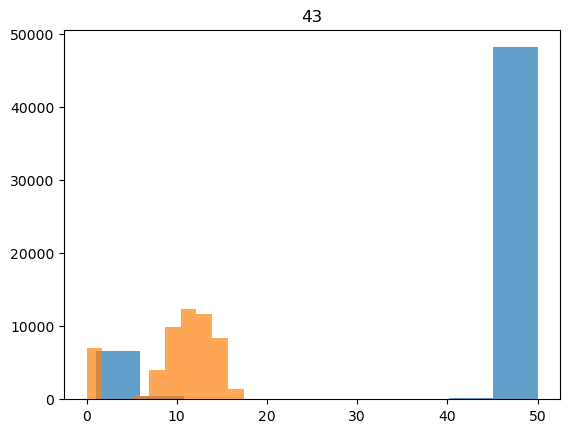

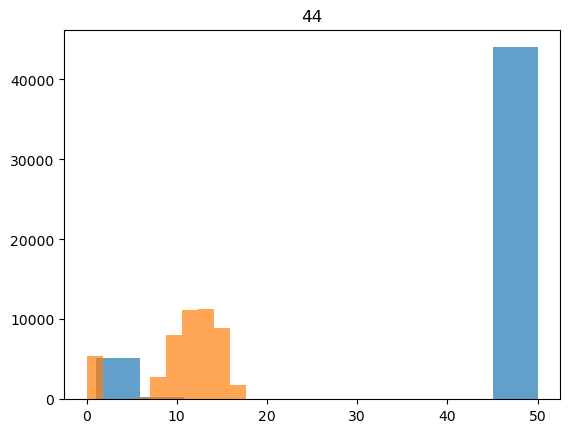

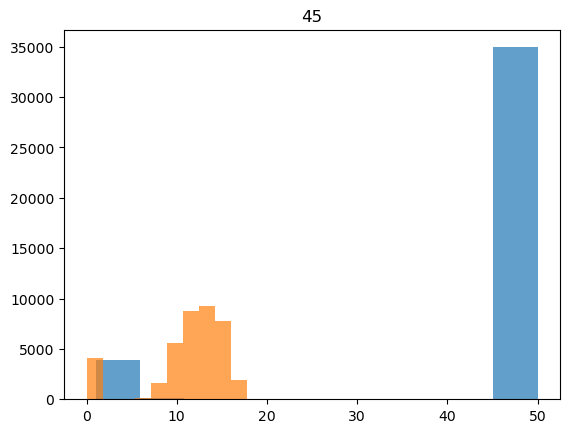

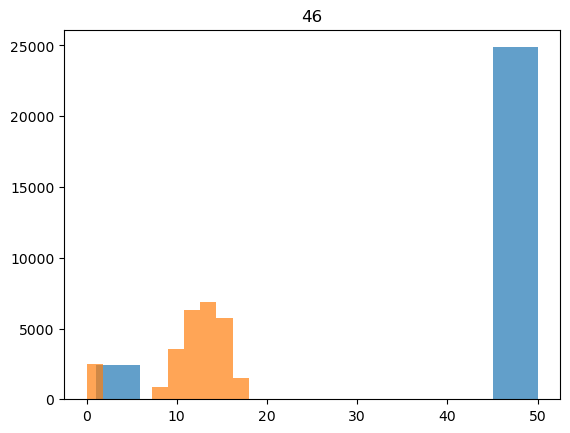

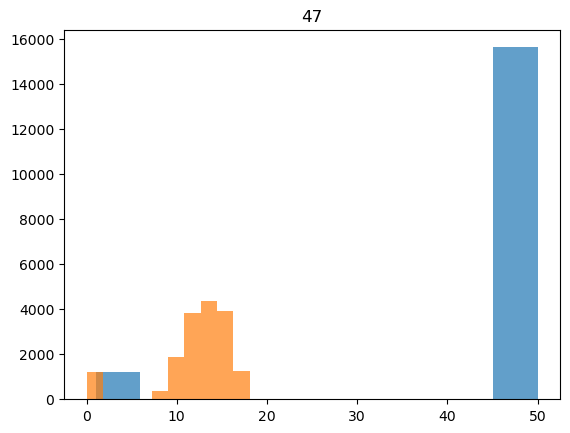

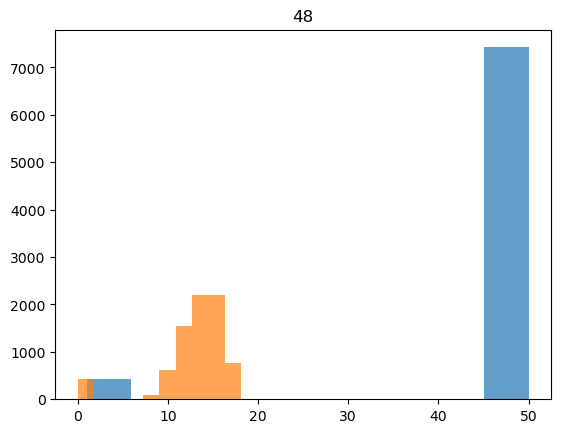

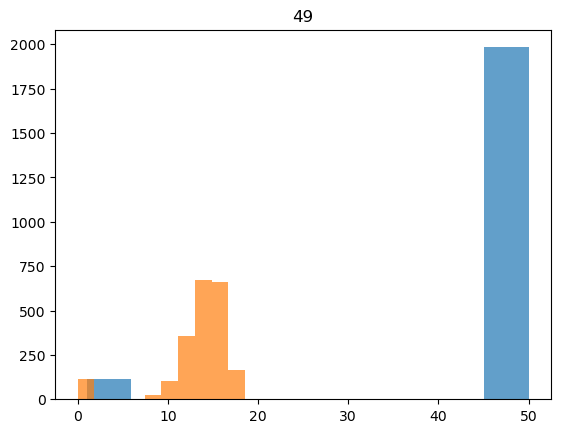

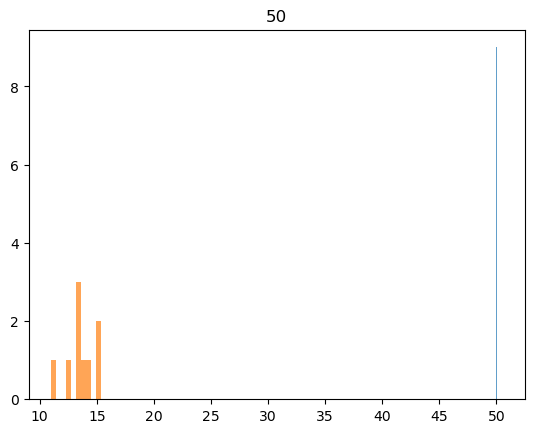

In [53]:
for i in range(L+1):
    plt.title(i)
    plt.hist(dataDic2[i],alpha=0.7)
    plt.hist(dataDic1[i],alpha=0.7)
    plt.show()

In [124]:
# for eps2 in np.arange(0.32,0.34,0.001):
#     x = 0.1*np.random.uniform(-1,1,L).astype(dtype=np.float32) 
#     v = np.zeros(L,dtype=np.float32)
#     t = 0

#     x,v,t,eventsSize,eventsBlocks,ls= run(x,v,t,10_000_000)

#     par = np.linalg.norm(ls[:,0]- eventsBlocks[:,0])
#     print(eps2, par)

0.32 318.3834166535688
0.321 311.3647378878989
0.322 261.9236529983499
0.323 274.7544358149655
0.324 288.5359596306845
0.325 299.2072860075436
0.326 279.4995527724508
0.327 320.99532706879086
0.328 280.53520278211073
0.329 301.18266882408756
0.33 259.5399776527693
0.331 277.36618395182927
0.332 279.62296043064845
0.333 277.05956038368356
0.334 276.31503759296197
0.335 283.4572278140037
0.336 295.1796063416306


KeyboardInterrupt: 

<BarContainer object of 15 artists>

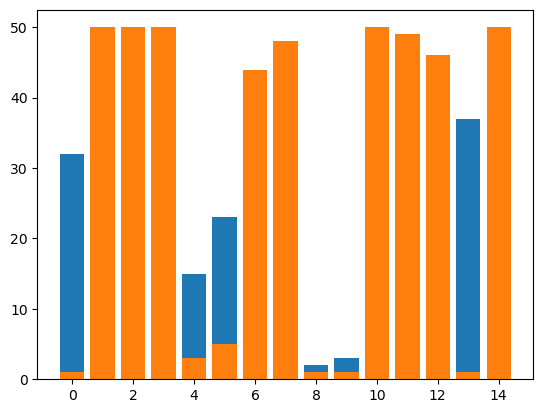

In [142]:
plt.bar(np.arange(eventsSize.shape[0]),ls[:,0])
plt.bar(np.arange(eventsSize.shape[0]),eventsBlocks[:,0])

<BarContainer object of 15 artists>

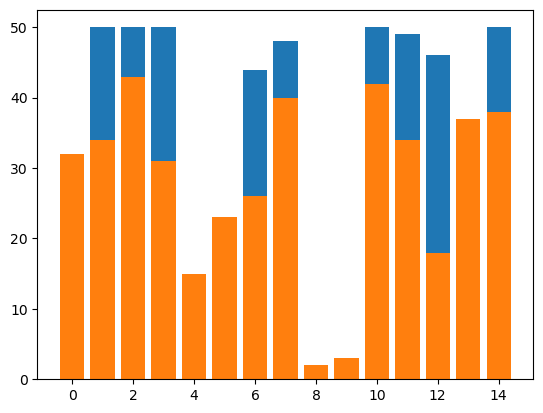

In [141]:
plt.bar(np.arange(eventsSize.shape[0]),eventsBlocks[:,0])
plt.bar(np.arange(eventsSize.shape[0]),ls[:,0])


In [15]:
x = 0.1*np.random.uniform(-1,1,L).astype(dtype=np.float32) 
v = np.zeros(L,dtype=np.float32)
t = 0

In [16]:
x,v,t,eventsSize,eventsBlock = run(x,v,t,1_000_000)

/tmp/ipykernel_6185/3979528276.py:4: NumbaExperimentalFeatureWarning: Use of isinstance() detected. This is an experimental feature.
  l1 = acc(x,v,t)


In [24]:
tenstion(x,v,t)

array([ 0.92941733,  0.39425291,  0.4371245 ,  0.71820021,  0.70737958,
        0.60290386,  0.62557907,  0.61770189,  0.61775298,  0.67026785,
        0.64546022,  0.6365137 ,  0.62800613,  0.62532608,  0.6189285 ,
        0.62843162,  0.64384358,  0.59178559,  0.7004657 ,  0.59966988,
        0.60100563,  0.58277573,  0.56930126,  0.57896695,  0.59328478,
        0.66335909,  0.62447646,  0.54804957,  0.59503295,  0.56122593,
        0.57973318,  0.60369594,  0.6053518 ,  0.55898939,  0.53016622,
        0.52690777,  0.58243967,  0.58768241,  0.58523719,  0.5481633 ,
        0.43488768,  0.33948725,  0.40667135,  0.29418131,  0.22082487,
        0.59470805,  0.46832282,  0.39387153,  0.29062339, -0.11250414])

In [114]:
x = 0.1*np.random.uniform(-1,1,L).astype(dtype=np.float64) 
v = np.zeros(L,dtype=np.float64)
t = 0

parts = 100
steps = 1_000_000
eventsSizes = np.array([])
eventsBlocks = np.array([]).reshape((0,1))
for p in range(parts):
    x,v,t,eventsSize,eventsBlock,_ = run(x,v,t,steps)
    eventsSizes = np.concatenate((eventsSizes,eventsSize))
    eventsBlocks = np.concatenate((eventsBlocks,eventsBlock))
    print(p)

# np.save("eventsSizes",eventsSizes)
# np.save("eventsBlocks",eventsBlocks)

    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [120]:
dists = []
for i in range(L):
    dists.append(eventsSizes[(eventsBlocks==i)[:,0]])

In [132]:
len(dists)

50

(501914, 1)

In [136]:
distsMean = np.zeros(L)
distsVar = np.zeros(L)

for i in range(0,L):
    distsMean[i] = np.mean(dists[i])
    distsVar[i] = np.var(dists[i])

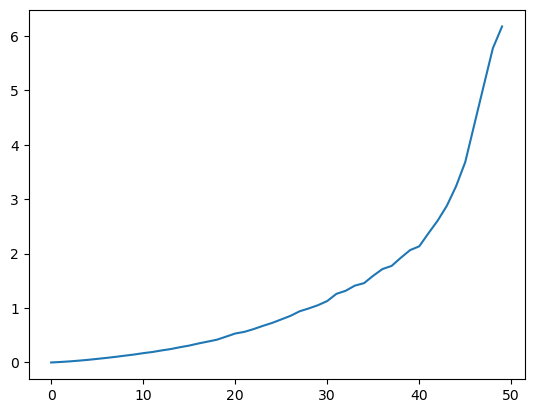

In [137]:
plt.plot(np.arange(L),distsMean)

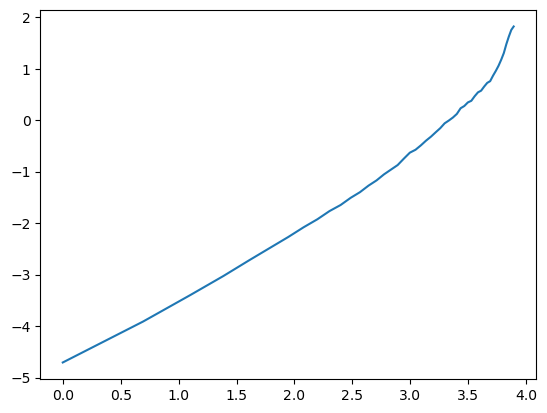

In [143]:
plt.plot(np.log(np.arange(1,L)),np.log(distsMean[1:]))

In [ ]:
plt.plot(np.arange(L),distsVar)

/tmp/ipykernel_4590/1380549109.py:1: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(np.arange(L)),np.log(distsVar))


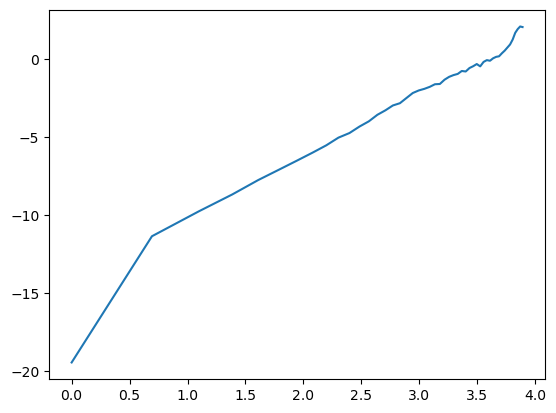

In [140]:
plt.plot(np.log(np.arange(L)),np.log(distsVar))

In [144]:
scipy.stats.linregress(np.log(np.arange(1,L)),np.log(distsMean[1:]))

LinregressResult(slope=1.6765538617794296, intercept=-5.449163230034136, rvalue=0.9828089898304063, pvalue=3.8590763157729996e-36, stderr=0.04593995857850813, intercept_stderr=0.14142123945631804)

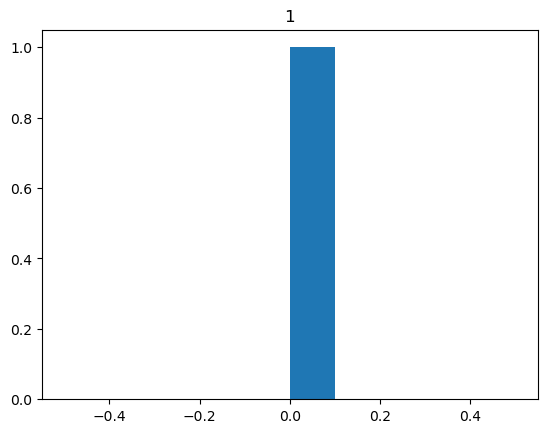

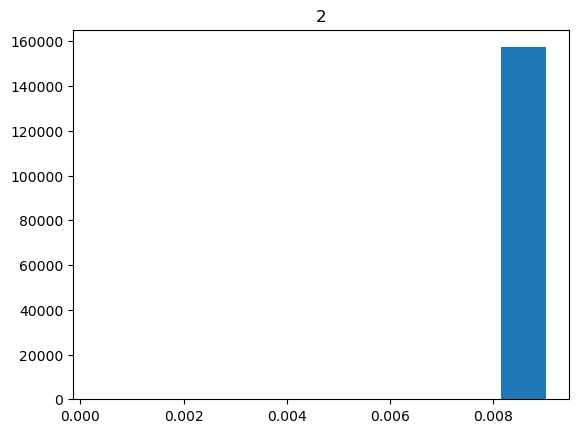

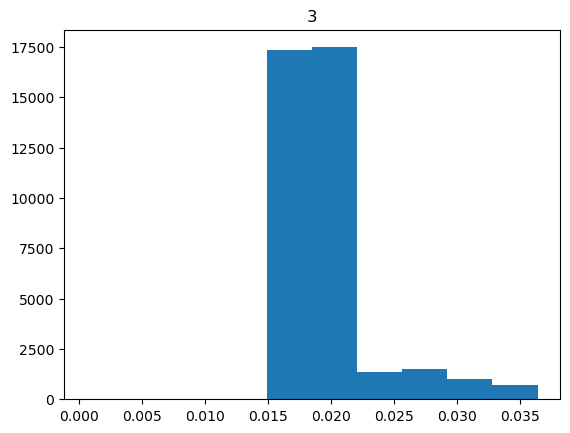

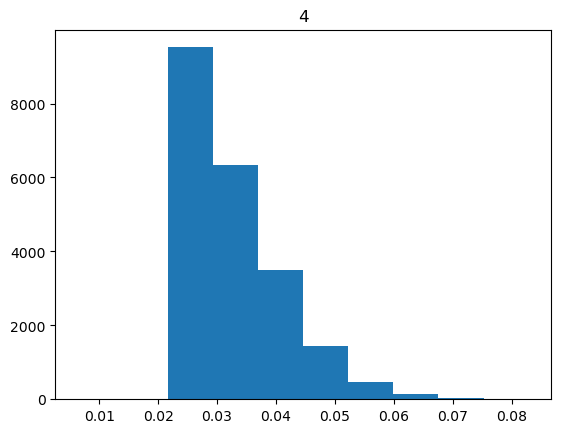

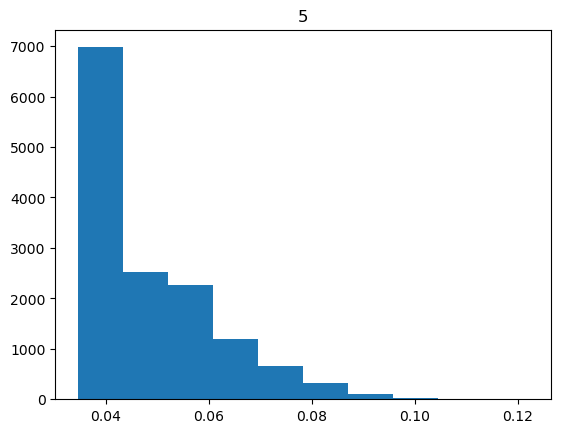

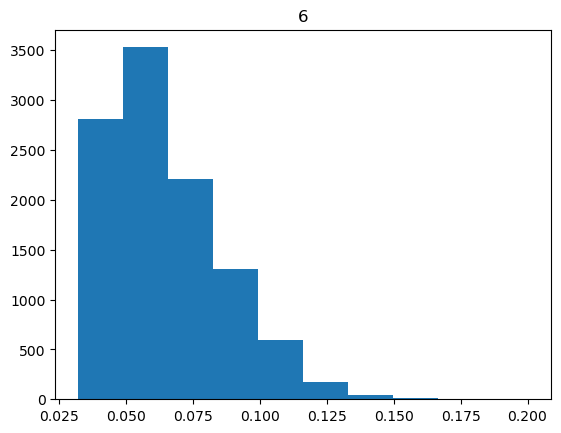

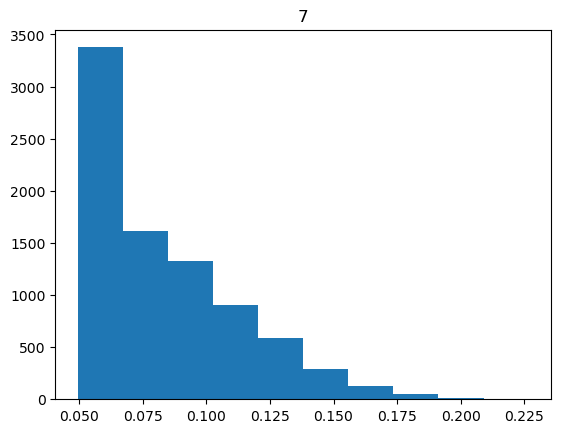

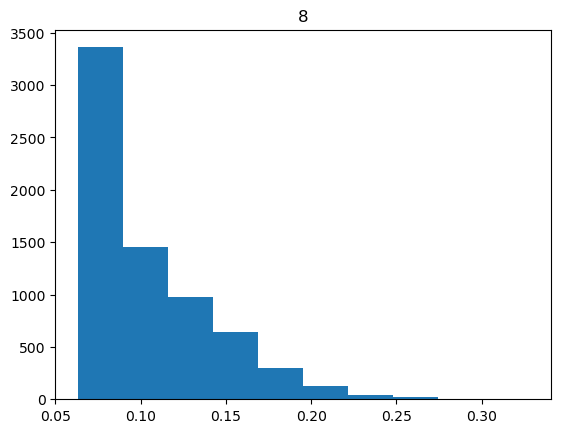

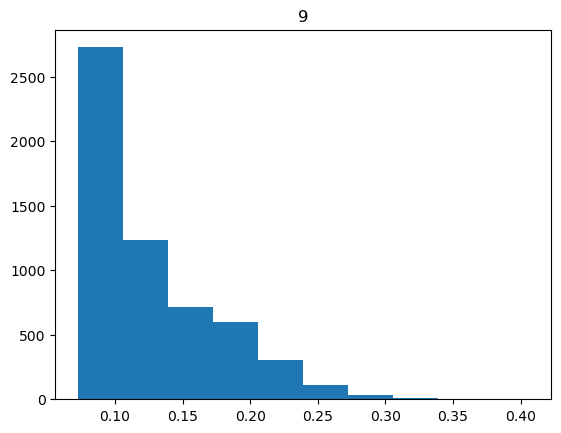

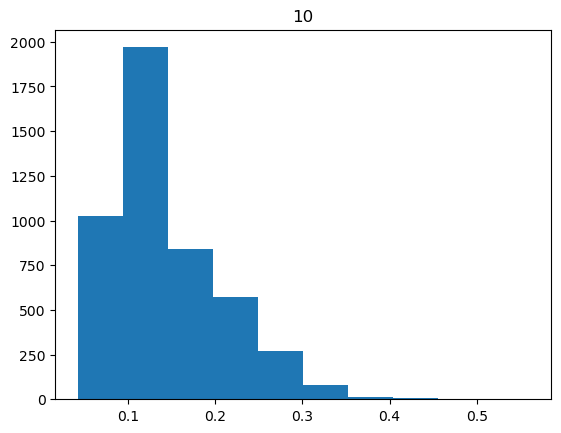

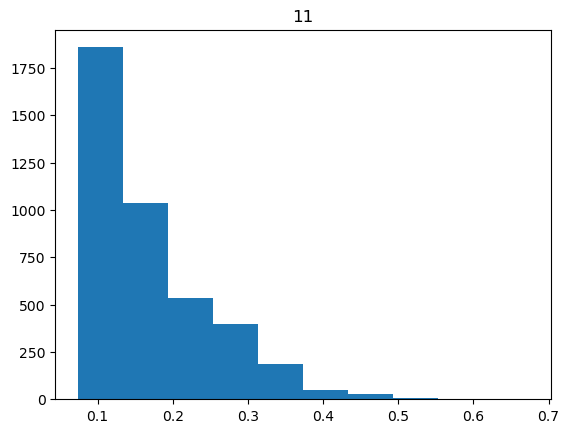

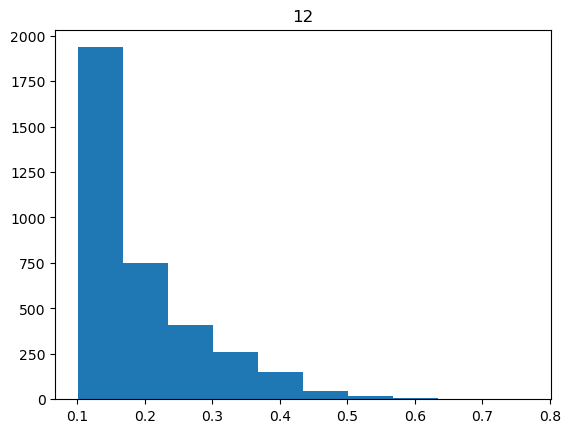

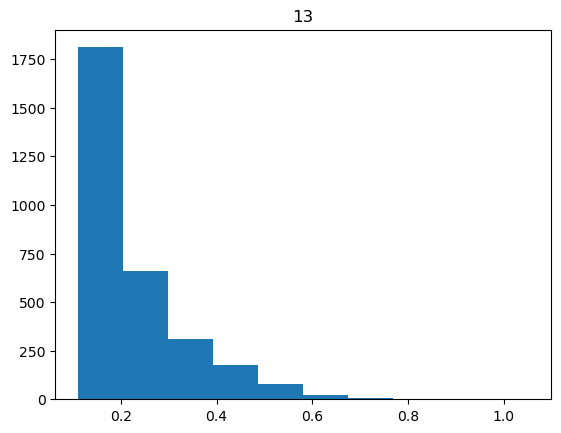

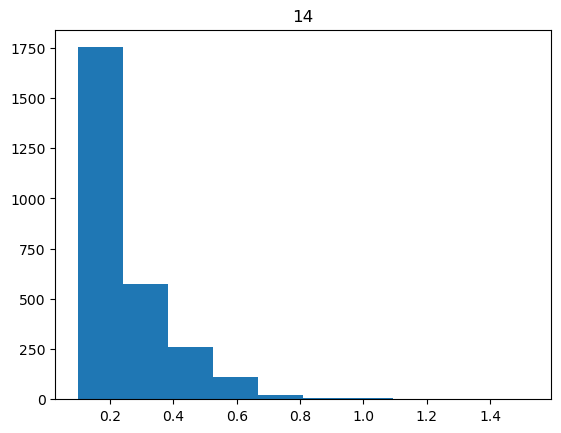

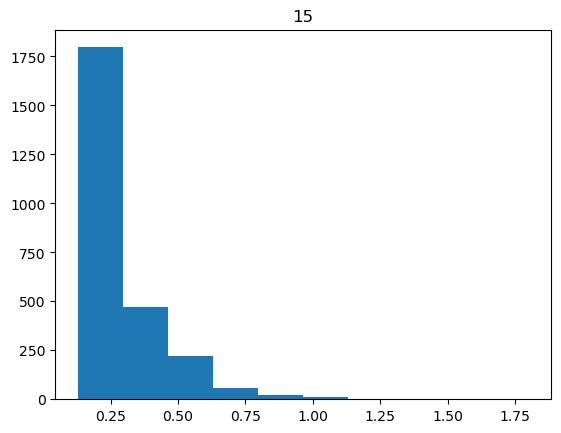

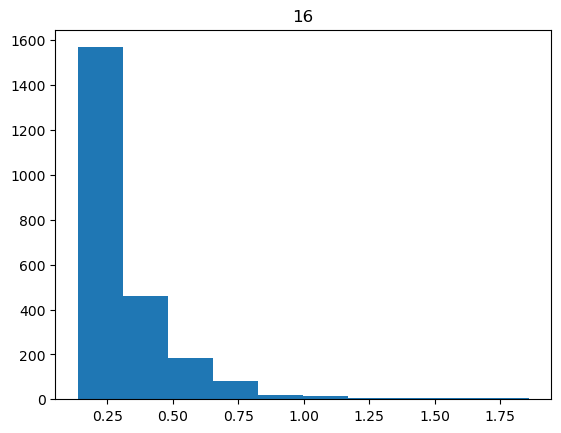

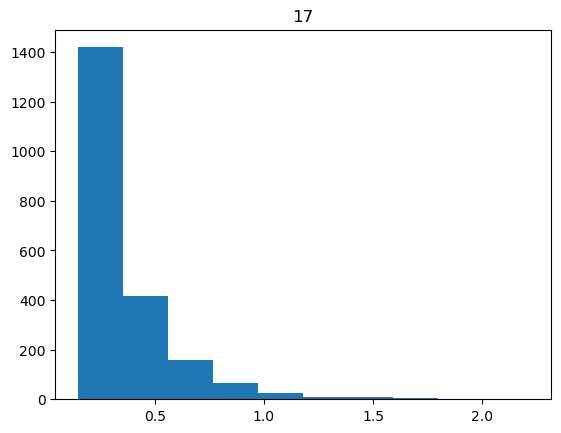

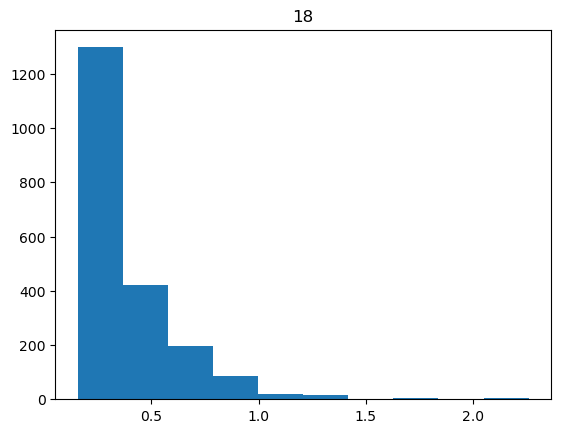

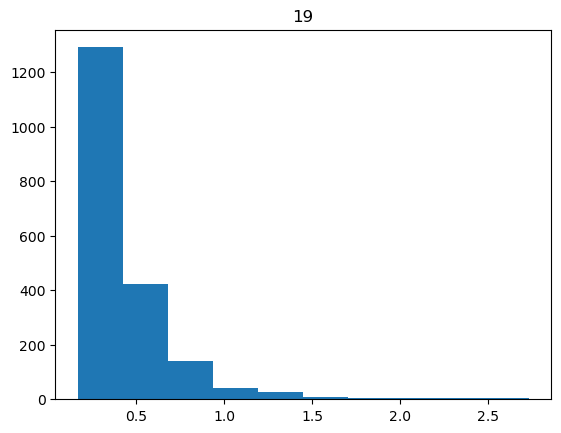

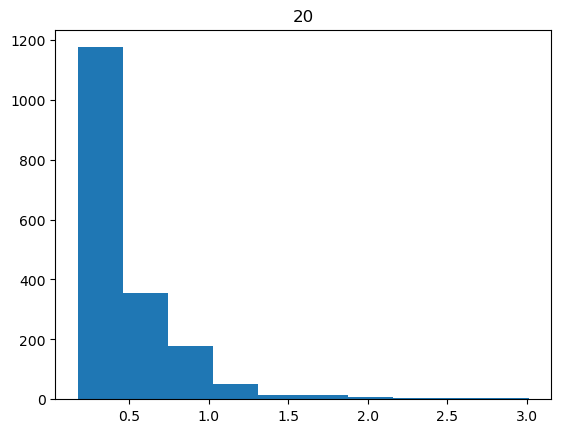

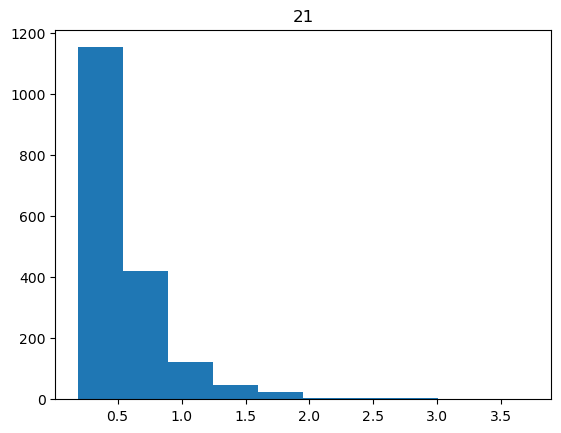

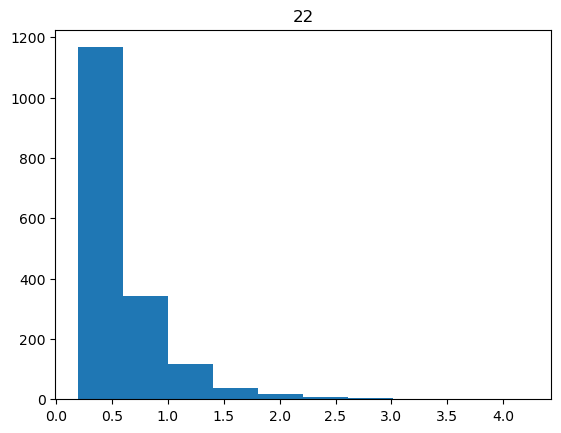

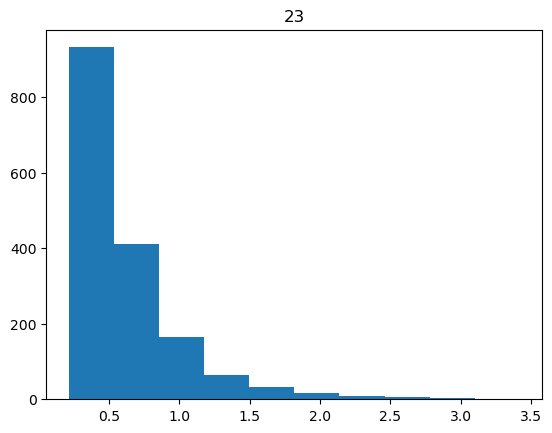

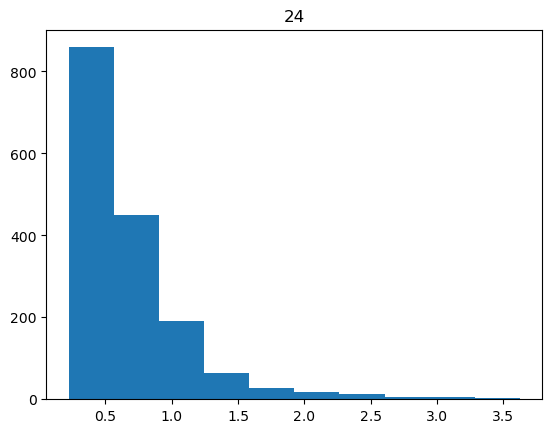

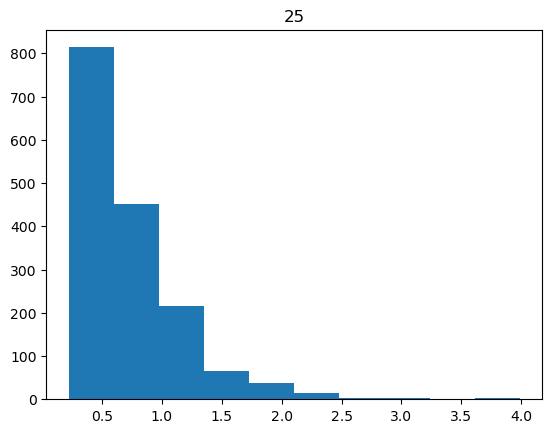

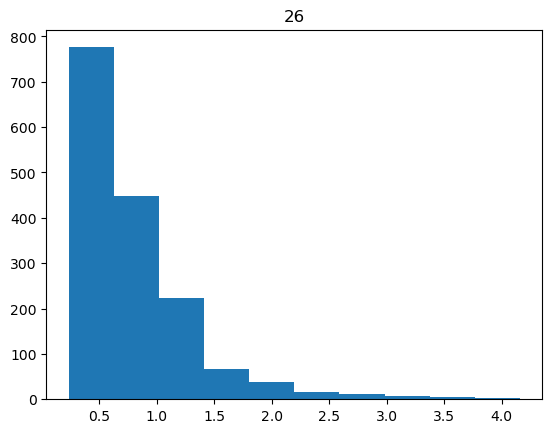

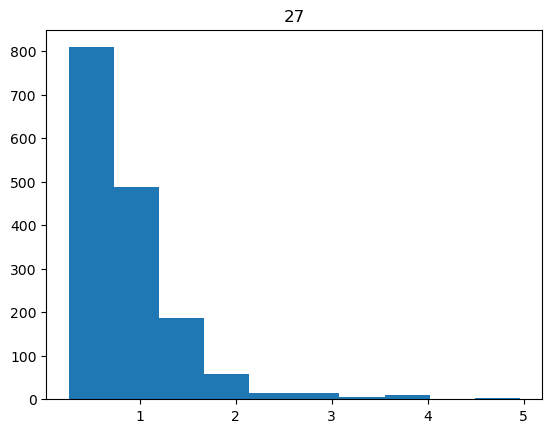

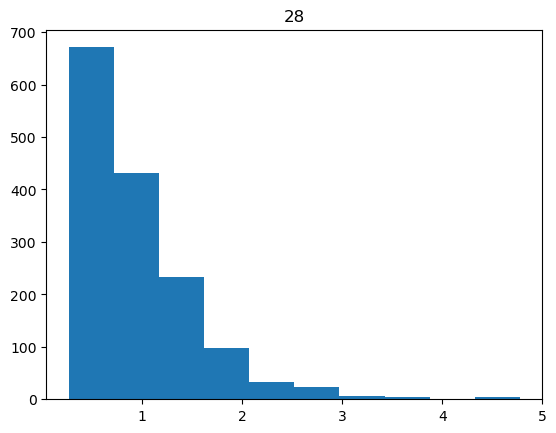

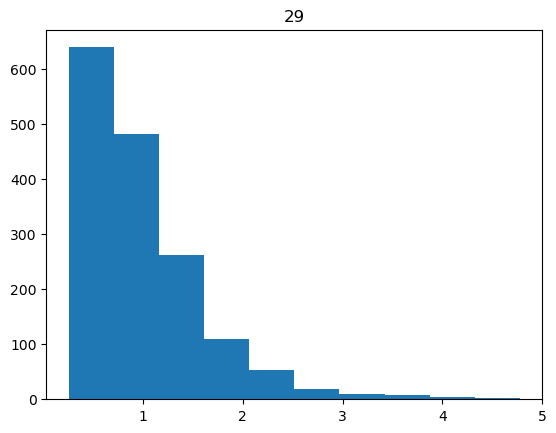

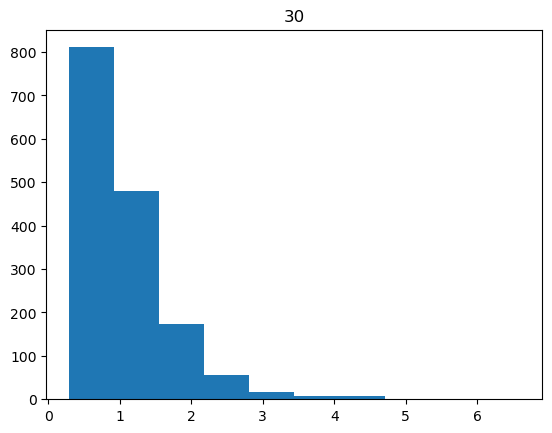

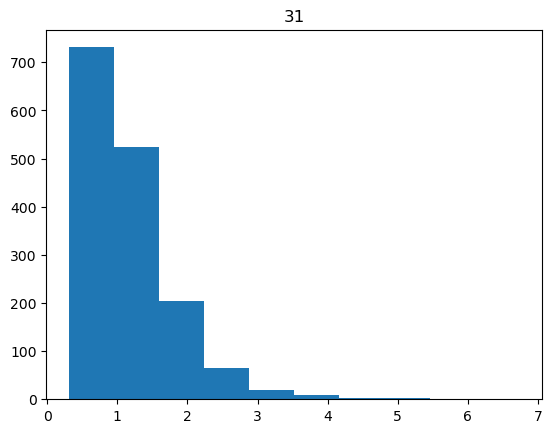

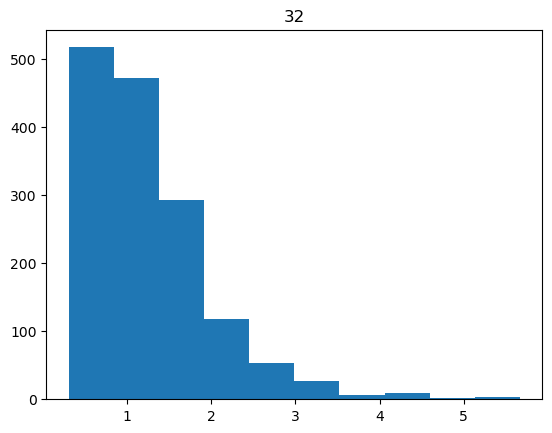

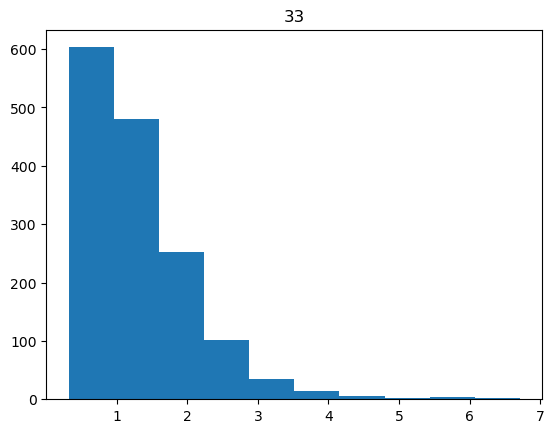

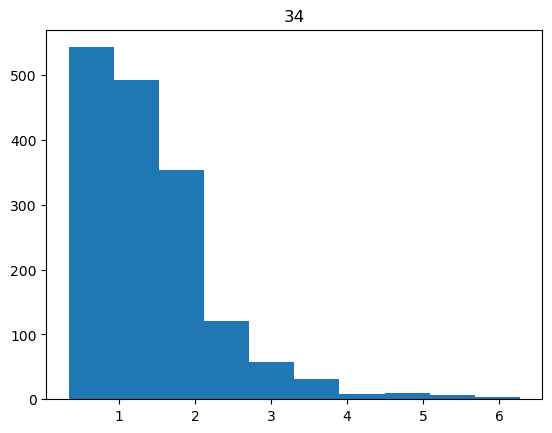

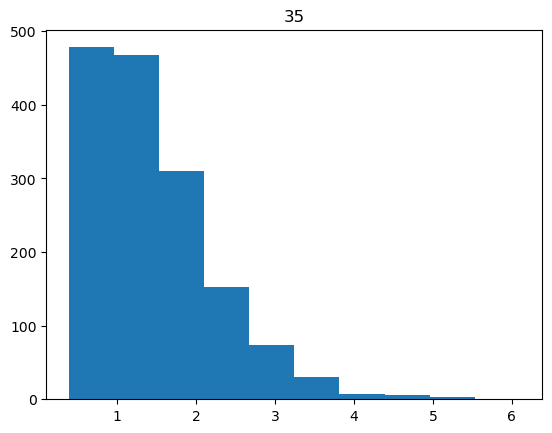

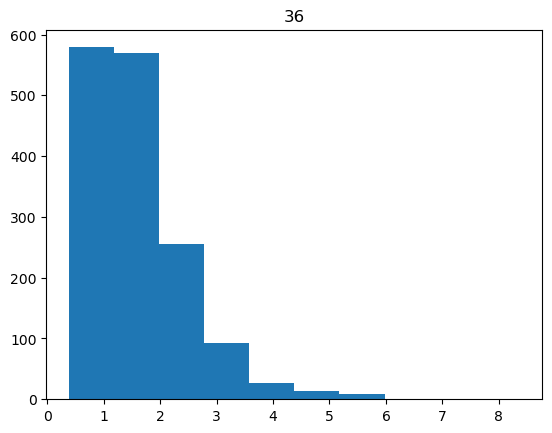

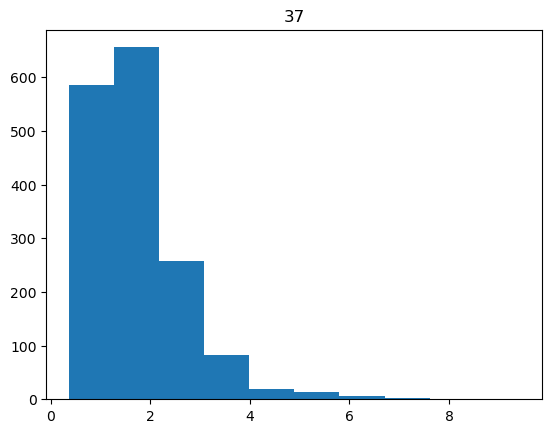

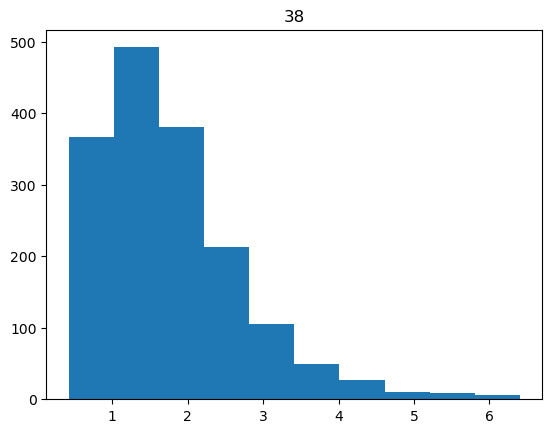

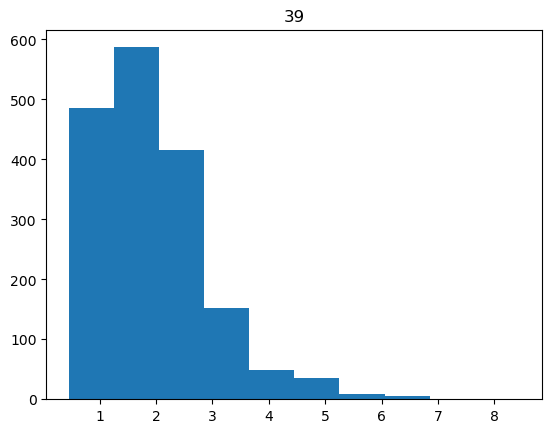

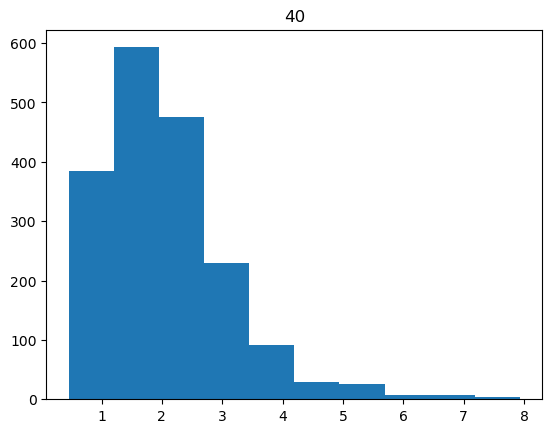

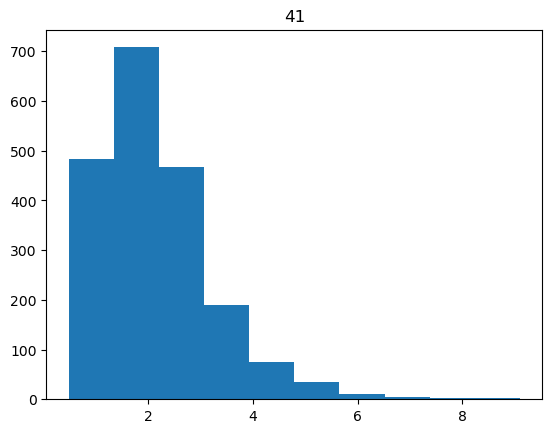

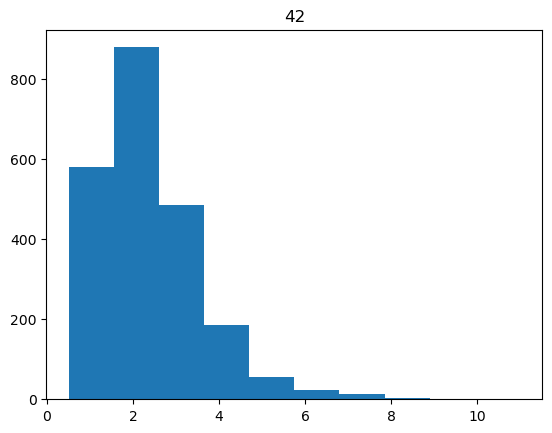

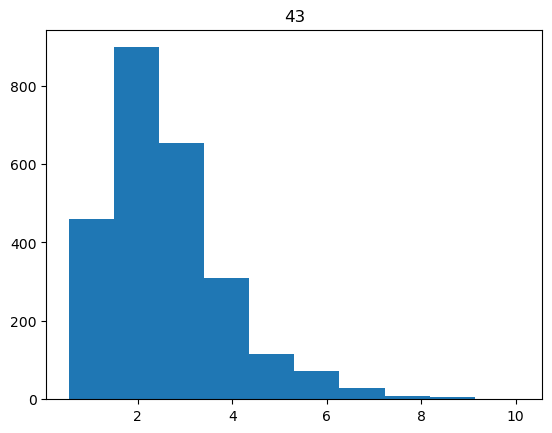

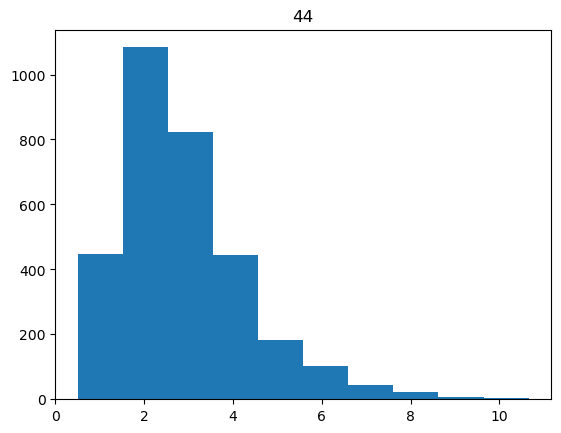

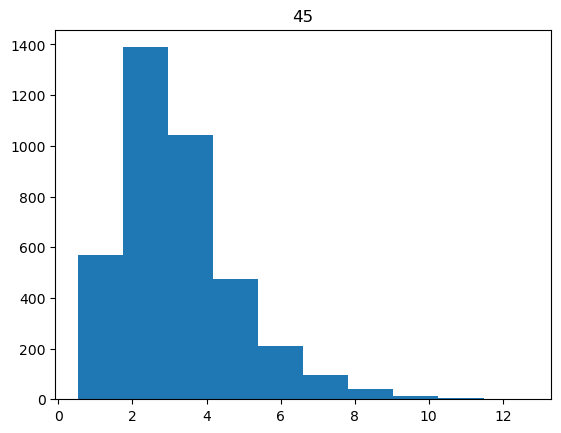

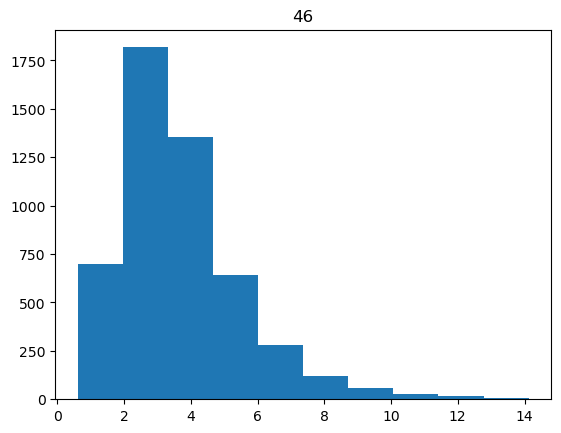

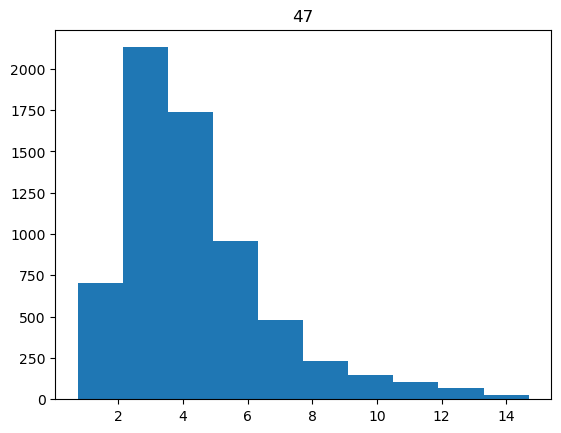

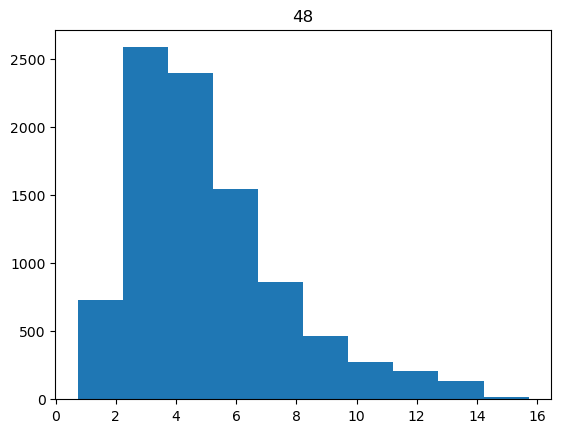

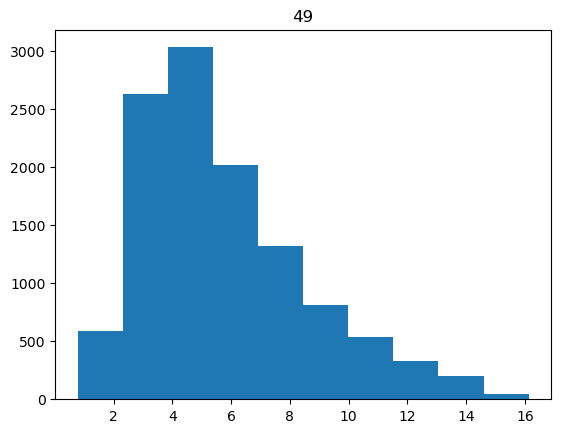

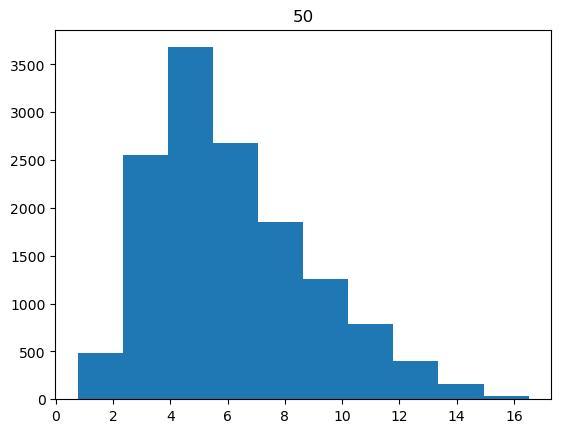

In [133]:
for i in range(0,L):
    plt.title(i+1)
    plt.hist(dists[i])
    plt.show()

In [127]:
eventsSizes.shape

(501914,)

(array([327054.,  27426.,  26227.,  24600.,  24268.,  23959.,  20959.,
         16362.,   9638.,   1421.]),
 array([ 0.        ,  1.81291481,  3.62582962,  5.43874444,  7.25165925,
         9.06457406, 10.87748887, 12.69040368, 14.50331849, 16.31623331,
        18.12914812]),
 <BarContainer object of 10 artists>)

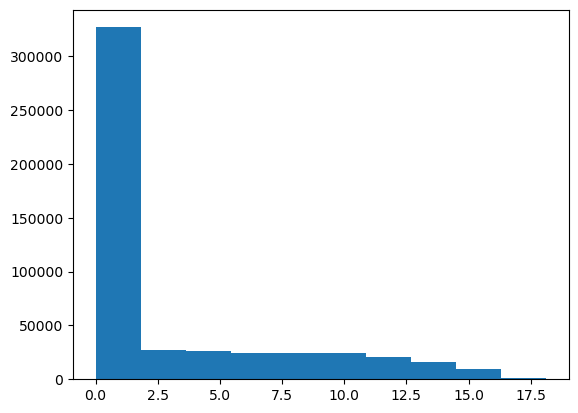

In [124]:
plt.hist(eventsSizes)

In [50]:
eventsSize

(5067,)

In [45]:
freq,size = getHist(eventsSize)

NameError: name 'getHist' is not defined

In [42]:
freq,size = np.histogram(eventsSize,bins=50)

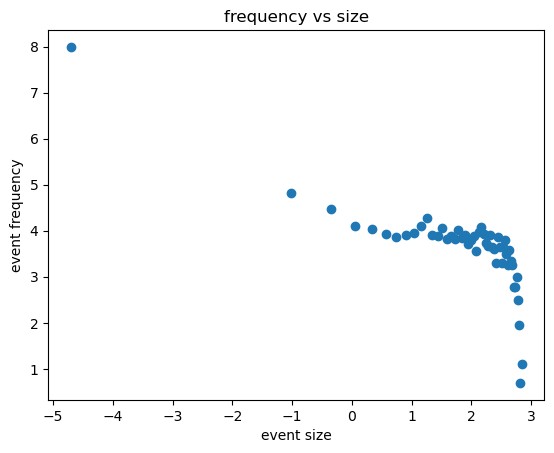

In [43]:
#slope , intercept, rvalue ,_,_= scipy.stats.linregress(np.log(size[:-1]),np.log(freq))

plt.title("frequency vs size")
plt.xlabel("event size")
plt.ylabel("event frequency")
plt.scatter(np.log(size[:-1]),np.log(freq))
#plt.plot([np.log(size[0]),np.log(size[-2])],[intercept + slope.astype(np.float32)*np.log(size[0]), intercept + slope.astype(np.float32)*np.log(size[-2])])
#plt.text(-1,10,s = f"slope = {np.round(slope,3)}, intercept = {np.round(intercept,3)}, rval = {np.round(rvalue,3)}")
plt.savefig("plot.png")

In [ ]:
x = 0
v = 0
t = 0
steps = 100_000
xData = np.zeros(steps)
vData = np.zeros(steps)

In [ ]:
for i in range(steps):
    xData[i] = x
    vData[i] = v
    x,v,t = step2(x,v,t)


In [128]:
plt.plot(np.arange(steps),xData)

NameError: name 'xData' is not defined

In [ ]:
plt.plot(np.arange(steps),vData)

In [ ]:
tensionData= np.zeros(steps)
for i in range(steps):
    tensionData[i] = tenstion(xData[i],vData[i],i*h)

In [ ]:
fData= np.zeros(steps)
for i in range(steps):
    fData[i] = f2(xData[i],vData[i],i*h)

In [ ]:
plt.plot(np.arange(9900,10100),xData[9900:10100])

In [ ]:
plt.plot(np.arange(9900,10100),vData[9900:10100])

In [ ]:
plt.plot(np.arange(9900,10100),fData[9900:10100])

In [ ]:
plt.plot(np.arange(9900,10100),tensionData[9900:10100])

In [ ]:
plt.plot(np.arange(steps),tensionData)